In [1]:
# Rates plot

In [1]:
import config, parse_midas_data, sample_utils as su, temporal_changes_utils, stats_utils, midas_db_utils, parse_patric, plot_utils
from collections import defaultdict
import numpy as np
from numpy.random import binomial as sample_binomial
import math, pickle, sys, random
from math import log10,ceil,log,exp
import scipy

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.ticker
from matplotlib.patches import Patch
from matplotlib import rcParams
from matplotlib import gridspec
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Plot directory
plot_dir = "%s/" % (config.analysis_directory)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

# Sample-subject-order-cohort maps
sys.stderr.write("Loading sample metadata...\n")
subject_sample_map = su.parse_subject_sample_map()
sample_order_map = su.parse_sample_order_map()
sample_subject_map = su.parse_sample_subject_map()
sample_cohort_map = su.parse_sample_cohort_map()
same_mi_pair_dict = su.get_same_mi_pair_dict(subject_sample_map)
subject_delivery_mode_map = su.parse_subject_delivery_mode_map()
subject_feeding_mode_map = su.parse_subject_feeding_mode_map()
sys.stderr.write("Done!\n")

# Cohorts
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao']

# Samples for each cohort
samples = {cohort: su.get_sample_names(cohort) for cohort in cohorts}
hmp_samples = su.get_sample_names('hmp')
mother_samples = su.get_sample_names('mother')
infant_samples = su.get_sample_names('infant')
olm_samples = su.get_sample_names('olm')
infant_samples = [sample for sample in infant_samples if sample not in olm_samples] # Exclude Olm
mother_samples = [sample for sample in mother_samples if sample not in olm_samples] # Exclude Olm
mi_samples = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples] # Exclude Olm

# Sample-timepoint map
mi_sample_day_dict = su.get_mi_sample_day_dict(exclude_cohorts=['olm'])
mi_tp_sample_dict = su.get_mi_tp_sample_dict(exclude_cohorts=['olm']) # no binning
mi_tp_sample_dict_binned, mi_tp_binned_labels = su.get_mi_tp_sample_dict(exclude_cohorts=['olm'], binned=True)

# Narrow down samples to no Olm, and mother only at delivery
infant_samples = [sample for sample in infant_samples if sample not in olm_samples]
mother_samples = [sample for sample in mother_samples if (mi_sample_day_dict[sample] < 7 and mi_sample_day_dict[sample] > -7)]
mi_samples = [sample for sample in (mother_samples + infant_samples) if sample not in olm_samples]

# Sample identity wrapper functions
is_infant = lambda sample: sample in infant_samples
is_mother = lambda sample: sample in mother_samples
is_adult = lambda sample: sample in hmp_samples

Loading sample metadata...
Done!


In [2]:
# ======================================================================
# Load pickled data
# ======================================================================

# Parameters
sweep_type = 'full'
pp_prev_cohort = 'all'
min_coverage = 0

ddir = config.data_directory
pdir = "%s/pickles/cov%i_prev_%s/" % (ddir, min_coverage, pp_prev_cohort)

snp_changes = pickle.load(open('%s/big_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
gene_changes = pickle.load(open('%s/big_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
snp_change_freqs = pickle.load(open('%s/snp_change_freqs_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
snp_change_null_freqs = pickle.load(open('%s/snp_change_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
gene_gain_freqs = pickle.load(open('%s/gene_gain_freqs_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
gene_loss_freqs = pickle.load(open('%s/gene_loss_freqs_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
gene_loss_null_freqs = pickle.load(open('%s/gene_loss_null_freqs_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
between_snp_change_counts = pickle.load(open('%s/between_snp_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')
between_gene_change_counts = pickle.load(open('%s/between_gene_change_counts_%s.pkl' % (pdir, sweep_type), 'rb'), encoding='latin1')

# nonconsecutive
pdir = "%s/pickles/cov%i_prev_%s/nonconsecutive/" % (ddir, min_coverage, pp_prev_cohort)

dnds_info = pickle.load(open('%s/dnds_info.pkl' % (pdir), 'rb'), encoding='latin1')
snp_change_freqs_with_opps = pickle.load(open('%s/snp_change_freqs_with_opps_full.pkl' % (pdir), 'rb'), encoding='latin1')

In [3]:
# Calculate number of days for a sample pair (mother-infant)
def mi_sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    return days

# Rough approximation of HMP time intervals
def adult_sample_pair_to_days(sample1, sample2):
    order1 = sample_order_map[sample1][1]
    order2 = sample_order_map[sample2][1]
    return (order2 - order1)*183

# Unify days calculation (assume if not AA, then must be mother-infant)
def sample_pair_to_days(sample1, sample2):
    if is_adult(sample1) and is_adult(sample2):
        return adult_sample_pair_to_days(sample1, sample2)
    else:
        return mi_sample_pair_to_days(sample1, sample2)

In [4]:
# Define function for bootstrapping

def bootstrapped_agg_from_list_dict(listdict, aggregator_fn, num_bootstraps=20, n=50):
    bootstrapped_agg_dict = defaultdict(list)
    for key in listdict:
        all_items = listdict[key]
        if len(all_items) < n:
            print("Skipping %s" % key)
            continue
        for _ in np.arange(num_bootstraps):
            bootstrap = [random.choice(all_items) for i in np.arange(n)]
            bootstrapped_agg_dict[key].append(aggregator_fn(bootstrap))
    return bootstrapped_agg_dict

# Plot function
def plot_interval(y, xstart, xstop, color='b', tickh=0.1):
    """Plot interval at y from xstart to xstop with given color."""   
    plt.hlines(y, xstart, xstop, color, lw=1)
    plt.vlines(xstart, y+tickh, y-tickh, color, lw=1)
    plt.vlines(xstop, y+tickh, y-tickh, color, lw=1)

# Plot function on specific ax
def plot_interval_on_ax(ax, y, xstart, xstop, color='b', tickh=0.1):
    """Plot interval at y from xstart to xstop with given color."""   
    ax.hlines(y, xstart, xstop, color, lw=1)
    ax.vlines(xstart, y+tickh, y-tickh, color, lw=1)
    ax.vlines(xstop, y+tickh, y-tickh, color, lw=1)

# Significance tests
# function to calculate Cohen's d for independent samples
def cohenD(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

def summarize_ttest(a, b, simple=False):
    t, p = scipy.stats.ttest_ind(a, b)
    D = cohenD(a, b)
    if simple:
        print("t=%.04f" % t)
        print("P=" + str(p))
        print("d=" + str(D))
    else:
        print("Group 1 size: %i | Group 2 size: %i" % (len(a), len(b)))
        print("T-statistic: %.04f" % t)
        print("P-value: " + str(p))
        print("Cohen's D: " + str(cohenD(a, b)))
    return t, p, D 

def MWU_effect_size(p, n1, n2):
    return stats.norm.isf(p/2.0)/np.sqrt(n1 + n2)

def summarize_utest(a, b, simple=False):
    U, p = scipy.stats.mannwhitneyu(a, b)
    es = MWU_effect_size(p, len(a), len(b))
    if simple:
        print("U=%.04f" % U)
        print("P=" + str(p))
        print("Effect size: " + str(es))
    else:
        print("Group 1 size: %i | Group 2 size: %i" % (len(a), len(b)))
        print("U-statistic: %.04f" % U)
        print("P-value: " + str(p))
        print("Effect size: " + str(MWU_effect_size(p, len(a), len(b))))
    return U, p, es

# Statistical significance to asterisk representation mapping
def get_sig_str(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    elif pval > 0.05:
        return 'ns'

In [5]:
def permutation_test_p(nulls, true):
    # Firstly check if true is above or below median
    median = np.median(nulls); n = len(nulls)
    if true < median: # Below median
        sorted_nulls = sorted(nulls)
        for rank, null in zip(np.arange(0, n), sorted_nulls):
            if true < null:
                return rank/float(n)
    else: # Above median
        sorted_nulls = sorted(nulls, reverse=True)
        for rank, null in zip(np.arange(n, 0, step=-1), sorted_nulls):
            if true > null:
                return 1-(rank/float(n))

In [19]:
# Define function needed for survival curve plots

def calculate_unnormalized_survival_from_vector(counts):
    counts = sorted(counts)
    xs = [0]
    ns = [len(counts)]
    ns_cur = len(counts)
    min_count = -1
    for count in counts:
        if count > min_count:
            ns.append(ns_cur) # Number of elements greater or equal
            xs.append(count)
            min_count = count
        ns_cur -= 1
    xs.append(xs[len(xs)-1]+1)
    ns.append(0)
    return xs, np.array(ns)

# Calculating rate from tuples
def get_rate_from_tuples(sweep_day_tuple_list):
    total_sweeps = 0
    total_days = 0
    for num_sweeps, days in sweep_day_tuple_list:
        total_sweeps += num_sweeps
        total_days += days
    rate = float(total_sweeps)/total_days
    return rate

# Calculating replacement rate from all tuples
def get_replacement_rate_from_tuples(snp_diffs_day_tuple_list):
    total_replacements = 0
    total_days = 0
    for num_snp_changes, days in snp_diffs_day_tuple_list:
        if num_snp_changes >= 500:
            total_replacements += 1
        total_days += days
    rate = (float(total_replacements)/total_days)
    return rate

In [129]:
# Custom sample pair cohorts [not just sample!]
# Alternate version where a sample pair may be assigned multiple cohorts

# custom_cohort_tests: dictionary where keys are cohort names and values are 
# boolean functions taking in sample_i, sample_j as arguments

def custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species='dummy'):
    my_cohorts = set()
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j, species):
            my_cohorts.add(cohort)
    return my_cohorts

# Establish custom cohorts to be used for all three rates plots

custom_cohort_tests = {}

custom_cohort_tests['Mother-Infant(all)']        = lambda s1, s2, sp: (is_mother(s1) and is_infant(s2))

# Within the first week (BOTH mother and infant timepoints!)
custom_cohort_tests['Mother-Infant']             = lambda s1, s2, sp: ((is_mother(s1) and is_infant(s2)) 
                                                        and mi_sample_day_dict[s1] >= 0 and mi_sample_day_dict[s1] <= 7 
                                                        and mi_sample_day_dict[s2] <= 7)

custom_cohort_tests['Infant-Infant']        = lambda s1, s2, sp: (is_infant(s1) and is_infant(s2))

custom_cohort_tests['Day 0-Week 1']   = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                        and mi_sample_day_dict[s1] >= 0
                                                        and mi_sample_day_dict[s2] <= 7)

custom_cohort_tests['Week 1-Month 1'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                        and mi_sample_day_dict[s1] >= 7
                                                        and mi_sample_day_dict[s2] <= 31)

custom_cohort_tests['Month 1-Year 1'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                        and mi_sample_day_dict[s1] >= 31 
                                                        and mi_sample_day_dict[s2] <= 367)

custom_cohort_tests['Adult-Adult']             = lambda s1, s2, sp: (is_adult(s1) and is_adult(s2))

# 1mon and 3mon are alternatives
custom_cohort_tests['II-1mon'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                     and (sample_pair_to_days(s1, s2) < 32))

custom_cohort_tests['II-3mon'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                    and (sample_pair_to_days(s1, s2) <= 90))

custom_cohort_tests['II-1yr'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2))
                                                    and (sample_pair_to_days(s1, s2) > 90))

custom_cohort_tests['6mon duration infant'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= 175) 
                                                              and (sample_pair_to_days(s1, s2) <= 191))

custom_cohort_tests['6mon duration adult'] = lambda s1, s2, sp: ((is_adult(s1) and is_adult(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= 175) 
                                                              and (sample_pair_to_days(s1, s2) <= 191))

# 6 months +/- 8 days: if days >= 175 and days <= 191

custom_cohort_tests['4-8mon duration infant'] = lambda s1, s2, sp: ((is_infant(s1) and is_infant(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= (4*30.5)) 
                                                              and (sample_pair_to_days(s1, s2) <= (8*30.5)))

custom_cohort_tests['4-8mon duration adult'] = lambda s1, s2, sp: ((is_adult(s1) and is_adult(s2)) 
                                                              and (sample_pair_to_days(s1, s2) >= (4*30.5)) 
                                                              and (sample_pair_to_days(s1, s2) <= (8*30.5)))

In [8]:
# species -> mother_sample -> infant_sample -> # days of infant_sample
# mother timepoint at delivery (-1 to 7 days)
mi_dict = {species: defaultdict(dict) for species in gene_gain_freqs}

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        # MI: restrict to earliest mother-infant pair per host
        if 'Mother-Infant(all)' in custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
            mother_days = mi_sample_day_dict[sample_i]
            if mother_days >= -1 and mother_days <= 7:
                mi_dict[species][sample_i][sample_j] = mi_sample_day_dict[sample_j]

# species -> mother_sample -> earliest infant sample
mi_earliest_infant_sample_dict = defaultdict(dict)

# Distribution of which day the earliest infant tp occurs at
# Hopefully nothing too late
earliest_infant_days = []

for species in mi_dict:
    for mother_sample in mi_dict[species]:
        ordered_infant_days = sorted(mi_dict[species][mother_sample].items(), key=lambda x: x[1])
        infant_sample, days = ordered_infant_days[0]
        mi_earliest_infant_sample_dict[species][mother_sample] = infant_sample
        earliest_infant_days.append(days)

In [9]:
print(sorted(earliest_infant_days))

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 11, 14, 14, 14, 14, 21, 21, 30, 30, 30, 114, 115, 115, 116, 119, 119, 120, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 123, 123, 123, 123, 124, 128, 211, 221, 266, 271, 311, 311, 353, 358, 358, 358, 359, 359, 359, 359, 360, 360, 360, 360, 360, 363, 364, 364, 364, 365, 365, 366, 366, 366, 366, 367, 367, 367, 368, 368, 368, 369, 371, 371, 371, 372, 373, 373, 373, 374, 374, 374, 375, 378, 380, 380, 380, 383]


In [10]:
# Add one more category
custom_cohort_tests['Mother-Infant(earliest)']  = lambda s1, s2, sp: ((is_mother(s1) and is_infant(s2) 
                                                                       and (s1 in mi_earliest_infant_sample_dict[sp]) 
                                                                       and (s2 == mi_earliest_infant_sample_dict[sp][s1])))

In [11]:
# General permutation test setup
# Have two versions: permute labels by subject vs. by sample

# Returns null_differences and true_difference
# Assumes only permuting two things, and difference will be for label_set[0]-label_set[1]
def permutation_test(orig_label_data_dict, label_set, aggregator_fn, num_bootstraps=1000):
    
    orig_data = []; labels = []
    for label in label_set:
        for orig_datum in orig_label_data_dict[label]:
            orig_data.append(orig_datum)
            labels.append(label)
    
    # First compute true rate
    true_value_by_label = {label: aggregator_fn(orig_label_data_dict[label]) for label in orig_label_data_dict}
    
    # Next compute null rates
    permuted_values_by_label = {label: [] for label in label_set}
    
    for _ in range(num_bootstraps):        
        random.shuffle(labels) # Randomly permute labels    
        label_data_dict = defaultdict(list)
        for datum, label in zip(orig_data, labels):
            label_data_dict[label].append(datum)
        
        for label in label_set:
            permuted_values_by_label[label].append(aggregator_fn(label_data_dict[label]))
    
    # Compute differences between the labels
    label1, label2 = label_set[0], label_set[1]
    
    null_differences = []
    for val1, val2 in zip(permuted_values_by_label[label1], permuted_values_by_label[label2]):
        null_differences.append(val1-val2)
    
    true_difference = true_value_by_label[label1]-true_value_by_label[label2]
    
    return (null_differences, true_difference)

In [12]:
# This time orig_label_subject_data_dict values must be of the form (subject, datum)
def permutation_test_subject(orig_label_subject_data_dict, label_set, aggregator_fn, num_bootstraps=1000):
    
    subjects = []; labels = []
    
    for label in label_set:
        for subject, orig_datum in orig_label_subject_data_dict[label]:
            if subject not in subjects: # First appearance
                labels.append(label)
                subjects.append(subject)
    
    # First compute true rate
    true_value_by_label = {}
    for label in label_set:
        orig_data_list = [orig_datum for subject, orig_datum in orig_label_subject_data_dict[label]]
        true_value_by_label[label] = aggregator_fn(orig_data_list)
    
    # Next compute null rates
    permuted_values_by_label = {label: [] for label in label_set}
    
    for _ in range(num_bootstraps):        
        random.shuffle(labels) # Randomly permute labels according to subject
        subject_label_dict = {subject: label for subject, label in zip(subjects, labels)}
        
        label_data_dict = defaultdict(list)
        for label in label_set: # Basically ignore old label
            for subject, datum in orig_label_subject_data_dict[label]:
                new_label = subject_label_dict[subject]
                label_data_dict[new_label].append(datum)
        
        for label in label_set:
            permuted_values_by_label[label].append(aggregator_fn(label_data_dict[label]))
    
    # Compute differences between the labels
    label1, label2 = label_set[0], label_set[1]
    
    null_differences = []
    for val1, val2 in zip(permuted_values_by_label[label1], permuted_values_by_label[label2]):
        null_differences.append(val1-val2)
    
    true_difference = true_value_by_label[label1]-true_value_by_label[label2]
    
    return (null_differences, true_difference)

In [13]:
feeding_modes = ['breast', 'mixed', 'formula']
delivery_modes = ['Vaginal', 'C-section']

dmode_subjects = list(subject_delivery_mode_map.keys())
fmode_subjects = list(subject_feeding_mode_map.keys())
comb_subjects = list(set(dmode_subjects).intersection(set(fmode_subjects)))
print("%i subjects with both delivery and feeding mode information" % len(comb_subjects))

dmode_fmode_dict = {dmode: {fmode: 0 for fmode in feeding_modes} for dmode in delivery_modes}

for subject in comb_subjects:
    dmode = subject_delivery_mode_map[subject]
    fmode = subject_feeding_mode_map[subject]
    dmode_fmode_dict[dmode][fmode] += 1

for dmode in dmode_fmode_dict:
    for fmode in dmode_fmode_dict[dmode]:
        print("%s\t%s: %i" % (dmode, fmode, dmode_fmode_dict[dmode][fmode]))

# Try to get numbers for QP pairs

733 subjects with both delivery and feeding mode information
Vaginal	breast: 186
Vaginal	mixed: 201
Vaginal	formula: 48
C-section	breast: 72
C-section	mixed: 180
C-section	formula: 46


In [16]:
# Do four-way comparison
'''
Vaginal vs. c-section, breast only
Vaginal vs. c-section, formula only
Breast vs. formula, Vaginal only
Breast vs. formula, C-section only
'''

'\nVaginal vs. c-section, breast only\nVaginal vs. c-section, formula only\nBreast vs. formula, Vaginal only\nBreast vs. formula, C-section only\n'

# =================
# SNV change rates
# =================

In [191]:
# MUST RUN THIS FOR SNV CHANGE AND REPLACEMENT RATES
# Store SNP change information in CSV

'''
f = open('%s/snp_change_rate.csv' % config.analysis_directory, 'w')
f.write(','.join(['sample_1', 'sample_2', 'species', 'subject', 'cohort', 'day_1', 'day_2', 'days', 'day_mid', 'tp_cat', 
                  'snp_changes', 'snp_change_rate', 'breast', 'formula', 'vaginal', 'csection']) + '\n')
'''
tp_types_all = list(custom_cohort_tests.keys())
tp_types_subset = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']

# Store SNP change information

replacement_time_tups_by_tp_type = defaultdict(list)
all_time_tups_by_tp_type = defaultdict(list)
subject_all_time_tups_by_tp_type = defaultdict(list)
count_time_tups_by_tp_type = defaultdict(list)
subject_count_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        subject = sample_subject_map[s2]
        cohort = sample_cohort_map[s2]
        
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        
        # SPECIAL: try recoding mother-infant duration as sum
        if 'Mother-Infant' in custom_cohorts:
            day1 = mi_sample_day_dict[s1]
            day2 = mi_sample_day_dict[s2]
            days = day1 + day2
            if days == 0:
                days = 1
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        '''
        # Arbitrarily set same mother and infant (in particular, 0-0 or 1-1) as 1 day
        if is_mother(s1) and is_infant(s2) and mi_sample_day_dict[s2] == mi_sample_day_dict[s1]:
            days = 1
        '''
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                
                replacement_time_tups_by_tp_type[custom_cohort].append((1, days))
                
                all_time_tups_by_tp_type[custom_cohort].append((val, days))
                subject_all_time_tups_by_tp_type[custom_cohort].append((subject, val, days))
                
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                
                count_time_tups_by_tp_type[custom_cohort].append((len(val), days))
                subject_count_time_tups_by_tp_type[custom_cohort].append((subject, len(val), days))
                
                all_time_tups_by_tp_type[custom_cohort].append((len(val), days))
                subject_all_time_tups_by_tp_type[custom_cohort].append((subject, len(val), days))
                
                rate = len(val)/float(days)
                
                if custom_cohort in tp_types_subset: # Should be mother-infant or infant-infant in unique tp bins
                    day1 = mi_sample_day_dict[s1]; day2 = mi_sample_day_dict[s2]
                    day_mid = day1 + (days/2.0)
                    feeding_mode = subject_feeding_mode_map[subject] if subject in subject_feeding_mode_map else 'NA'
                    if feeding_mode == 'breast':
                        breast = 1; formula = 0
                    elif feeding_mode == 'mixed':
                        breast = 1; formula = 1
                    elif feeding_mode == 'formula':
                        breast = 0; formula = 1
                    delivery_mode = subject_delivery_mode_map[subject] if subject in subject_delivery_mode_map else 'NA'
                    if delivery_mode == 'Vaginal':
                        vaginal = 1; csection = 0
                    elif delivery_mode == 'C-section':
                        vaginal = 0; csection = 1
                    
                    '''
                    f.write(','.join([str(x) for x in [s1, s2, species, subject, cohort, day1, day2, days, day_mid, 
                                                       custom_cohort, len(val), rate, breast, formula, vaginal, csection]]) + '\n')
                    '''

f.close()

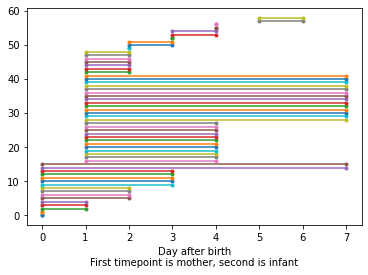

In [71]:
# Investigate the Mother-Infant category
# Namely, how much does Backhed higher resolution timepoint assignment change results?
# Are rates being inflated due to a smaller denominator due to mother timepoints 
# being mistakenly considered 0 when they are actually not 0?
total_days = 0
n = 0
day_tups = []

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        subject = sample_subject_map[s2]
        cohort = sample_cohort_map[s2]
        
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        if 'Mother-Infant' in custom_cohorts:
            day1 = mi_sample_day_dict[s1]
            day2 = mi_sample_day_dict[s2]
            # print('Mother %i\tInfant %i' % (day1, day2))
            day_tups.append((day1, day2))
            if days >= 0:
                total_days += days
                n += 1

fig, ax = plt.subplots()
idx = 0
for day1, day2 in sorted(day_tups):
    ax.plot([day1, day2], [idx, idx], '.-')
    idx += 1
ax.set_xlabel("Day after birth\nFirst timepoint is mother, second is infant")
plt.show()

Skipping 6mon duration infant
Mother-Infant: 0.11510791366906475
Day 0-Week 1: 0.01834862385321101
Week 1-Month 1: 0.011333643844123583
Month 1-Year 1: 0.0031162866983762507
Adult-Adult: 0.0014128695796713


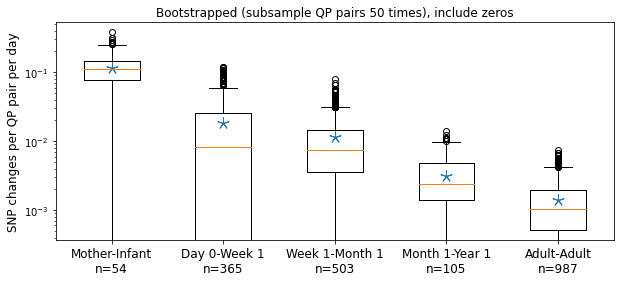

In [192]:
# Subsample QP pairs in a category to n=40 (since MI only has 44) and get #sweeps/day, bootstrap 20 times
bootstrapped_rates_by_tp_type = bootstrapped_agg_from_list_dict(count_time_tups_by_tp_type, get_rate_from_tuples, 
                                                               num_bootstraps=1000, n=40)

# SNP change rates boxplot
fig, ax = plt.subplots(figsize=(10,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    if len(count_time_tups_by_tp_type[tp_type]) == 0:
        annotations.append(0)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_tp_type[tp_type])))
        continue
    snp_count, total_days = (0,0)
    for count, days in count_time_tups_by_tp_type[tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
# ax.set_ylim(0, 0.14)
ax.set_yscale('log')
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")
for tp_type, annotation in zip(tp_types, annotations):
    print("%s: %s" % (tp_type, annotation))

plt.show()

In [154]:
# Perform PERMUTATION tests between all pairs

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

snp_change_rate_tp_pair_ptests = {} # (tp1, tp2) -> (n1, n2, p)

print("SNP CHANGE RATE TIMEPOINT PAIRWISE COMPARISONS")

for i in range(len(tp_types)):
    tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        tp_type2 = tp_types[j]
        # Permutation test for tp_type 1 vs._tp type2
        label_set = [tp_type1, tp_type2]
        orig_label_data_dict = {label: count_time_tups_by_tp_type[label] for label in label_set}
        null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                             aggregator_fn=get_rate_from_tuples,
                                                            num_bootstraps=10000)
        p = permutation_test_p(null_differences, true_difference)
        n1 = len(orig_label_data_dict[tp_type1])
        n2 = len(orig_label_data_dict[tp_type2])
        snp_change_rate_tp_pair_ptests[(tp_type1, tp_type2)] = (n1, n2, p)
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        print(str(p) + '\t' + get_sig_str(p))

SNP CHANGE RATE TIMEPOINT PAIRWISE COMPARISONS
Mother-Infant vs. Day 0-Week 1
0.008499999999999952	**
Mother-Infant vs. Week 1-Month 1
0.0	***
Mother-Infant vs. Month 1-Year 1
0.0	***
Mother-Infant vs. Adult-Adult
0.0	***
Day 0-Week 1 vs. Week 1-Month 1
0.13090000000000002	ns
Day 0-Week 1 vs. Month 1-Year 1
0.0	***
Day 0-Week 1 vs. Adult-Adult
0.0	***
Week 1-Month 1 vs. Month 1-Year 1
0.0	***
Week 1-Month 1 vs. Adult-Adult
0.0	***
Month 1-Year 1 vs. Adult-Adult
0.03190000000000004	*


In [132]:
# Store for later use
snp_change_rates = bootstrapped_rates
snp_change_rate_annotations = annotations
snp_change_rate_tp_type_labels = tp_type_labels

# Get statistics for paper
print(snp_change_rate_annotations)

[0.11510791366906475, 0.01834862385321101, 0.011333643844123583, 0.0031162866983762507, 0.0014128695796713]


T: 38.76	p: 1.313E-245


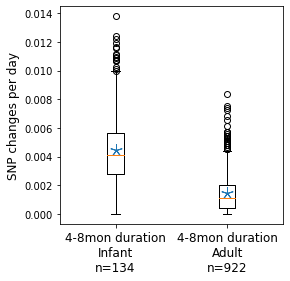

In [46]:
# Matched
# SNP change rates boxplot
# Rerun above block for combined infant vs. adult figure

# Uses bootstrapped_rates_by_tp_type from above with num_bootstraps=1000, n=40

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    snp_count, total_days = (0,0)
    for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
        snp_count += count
        total_days += days
    annotations.append(float(snp_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (label, len(count_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("SNP changes per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_rates[0], bootstrapped_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

In [135]:
# Old permutation test code...
'''
num_bootstraps = 1000

orig_data = []; labels = []

for label in label_set:
    for count, days in count_time_tups_by_tp_type[label]:
        orig_data.append((count, days))
        labels.append(label)

label_data_dict = defaultdict(list)
for datum, label in zip(orig_data, labels):
    label_data_dict[label].append(datum)

# First compute true rate
true_value_by_label = {}
for label in label_data_dict:
    snp_count, total_days = (0,0)
    for count, days in label_data_dict[label]:
        snp_count += count
        total_days += days
    true_value_by_label[label] = (float(snp_count)/total_days)

permuted_values_by_label = {label: [] for label in label_set}

i = 0
while i < num_bootstraps:
    
    random.shuffle(labels) # Randomly permute labels    
    label_data_dict = defaultdict(list)
    for datum, label in zip(orig_data, labels):
        label_data_dict[label].append(datum)
    
    
    for label in label_set:
        snp_count, total_days = (0,0)
        for count, days in label_data_dict[label]:
            snp_count += count
            total_days += days
        permuted_values_by_label[label].append(float(snp_count)/total_days)
    
    i += 1
'''
print()

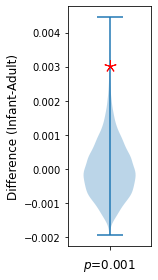

In [32]:
# Permutation test for infant vs. adult

label_set = ['4-8mon duration infant', '4-8mon duration adult']
orig_label_data_dict = {label: count_time_tups_by_tp_type[label] for label in label_set}
null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, aggregator_fn=get_rate_from_tuples,
                                                    num_bootstraps=10000)

# Plot permutation test results
fig, ax = plt.subplots(figsize=(2.3, 4))
p = permutation_test_p(null_differences, true_difference)
color = 'red' if p < 0.05 else 'gray'
ax.violinplot(null_differences)
ax.plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
ax.set_xticks([1]); ax.set_xticklabels([]); ax.set_xlim((0.6, 1.4))
ax.set_ylabel("Difference (Infant-Adult)", fontsize=12)
ax.set_xlabel(r'$\it{p}$' + ("<0.0001" if p == 0 else "=%.03f" % p), fontsize=12)
plt.tight_layout()
fig.savefig('%s/infant_vs_adult_comparison_snv_change_rate.pdf' % config.analysis_directory)

In [61]:
# Perform tests between all pairs

snp_change_rate_tp_pair_tests = {} # (tp1, tp2) -> (t, p, es) Store for later table

print("SNP CHANGE RATE TIMEPOINT PAIRWISE COMPARISONS")
print("Note: all sample sizes are equal to number of bootstraps")

for i in range(len(tp_types)):
    ind_rates1 = bootstrapped_rates[i]; tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        ind_rates2 = bootstrapped_rates[j]; tp_type2 = tp_types[j]
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        stat, p, es = summarize_utest(ind_rates1, ind_rates2, simple=True)
        snp_change_rate_tp_pair_tests[(tp_type1, tp_type2)] = (stat, p, es)
        print(get_sig_str(p))        

SNP CHANGE RATE TIMEPOINT PAIRWISE COMPARISONS
Note: all sample sizes are equal to number of bootstraps
Mother-Infant vs. Day 0-Week 1
U=990243.0000
P=0.0
Effect size: inf
***
Mother-Infant vs. Week 1-Month 1
U=996061.5000
P=0.0
Effect size: inf
***
Mother-Infant vs. Month 1-Year 1
U=997878.0000
P=0.0
Effect size: inf
***
Mother-Infant vs. Adult-Adult
U=998034.0000
P=0.0
Effect size: inf
***
Day 0-Week 1 vs. Week 1-Month 1
U=448122.0000
P=4.481885018729941e-05
Effect size: 0.09125665876500938
***
Day 0-Week 1 vs. Month 1-Year 1
U=475844.0000
P=0.058988297621672604
Effect size: 0.042223236605013544
ns
Day 0-Week 1 vs. Adult-Adult
U=485891.0000
P=0.26934177872530907
Effect size: 0.0246991515406445
ns
Week 1-Month 1 vs. Month 1-Year 1
U=764896.0000
P=1.5688988500869576e-93
Effect size: 0.45873817228217745
***
Week 1-Month 1 vs. Adult-Adult
U=857554.5000
P=8.26457593345967e-169
Effect size: 0.6192548735499891
***
Month 1-Year 1 vs. Adult-Adult
U=742570.5000
P=1.0038294022012134e-78
Effect 

In [30]:
# Store SNP change information, separate by cohort

cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']

replacement_time_tups_by_cohort_tp_type = {ds: defaultdict(list) for ds in cohorts}
all_time_tups_by_cohort_tp_type = {ds: defaultdict(list) for ds in cohorts}
count_time_tups_by_cohort_tp_type = {ds: defaultdict(list) for ds in cohorts}

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        dataset = sample_cohort_map[s1]
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                replacement_time_tups_by_cohort_tp_type[dataset][custom_cohort].append((1, days))
                all_time_tups_by_cohort_tp_type[dataset][custom_cohort].append((val, days))
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                count_time_tups_by_cohort_tp_type[dataset][custom_cohort].append((len(val), days))
                all_time_tups_by_cohort_tp_type[dataset][custom_cohort].append((len(val), days))

In [31]:
# Matched timepoint comparison

n = 10
num_bootstraps = 1000

bootstrapped_rates_by_cohort_tp_type = defaultdict(dict)

for tp_type in tp_types:
    for dataset in ['backhed', 'ferretti', 'yassour', 'shao']:
        tups = count_time_tups_by_cohort_tp_type[dataset][tp_type]
        if len(tups) < n:
            print("Not enough data")
            continue
        average = get_rate_from_tuples(tups)
        bootstrapped_rates = []
        for _ in np.arange(num_bootstraps):
            bootstrap = [random.choice(tups) for i in np.arange(n)]
            bootstrapped_rates.append(get_rate_from_tuples(bootstrap))
        
        bootstrapped_rates_by_cohort_tp_type[dataset][tp_type] = bootstrapped_rates

Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data


In [32]:
for tp_type in tp_types:
    print("===================================")
    print(tp_type)
    datasets_with_data = []
    for dataset in ['backhed', 'ferretti', 'yassour', 'shao']:
        if tp_type in bootstrapped_rates_by_cohort_tp_type[dataset]:
            datasets_with_data.append(dataset)
    for i in range(len(datasets_with_data)):
        d1 = datasets_with_data[i]
        for j in range(i+1, len(datasets_with_data)):
            d2 = datasets_with_data[j]
            t, p = stats.ttest_ind(bootstrapped_rates_by_cohort_tp_type[d1][tp_type], bootstrapped_rates_by_cohort_tp_type[d2][tp_type])
            print("%s vs %s: t= %.03f, P=%s" % (d1, d2, t, str(p)))

Mother-Infant
backhed vs shao: t= -0.990, P=0.3236197000351281
Day 0-Week 1
ferretti vs shao: t= -3.001, P=0.0030374432017142615
Week 1-Month 1
ferretti vs yassour: t= -7.883, P=2.095931670784442e-13
ferretti vs shao: t= -6.516, P=5.850219919322068e-10
yassour vs shao: t= -4.847, P=2.5315136968729915e-06
Month 1-Year 1
backhed vs yassour: t= 1.946, P=0.05308951824098055
Adult-Adult


Skipping Mother-Infant
Skipping Day 0-Week 1
Skipping Week 1-Month 1
Skipping Adult-Adult
Skipping II-1yr
Skipping Mother-Infant(all)
Skipping Mother-Infant(earliest)
Skipping Week 1-Month 1
Skipping Mother-Infant
Skipping Day 0-Week 1
Skipping Month 1-Year 1
Skipping Adult-Adult
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping II-1yr
Skipping Day 0-Week 1
Skipping Adult-Adult
Skipping 6mon duration infant
Skipping Month 1-Year 1
Skipping Adult-Adult


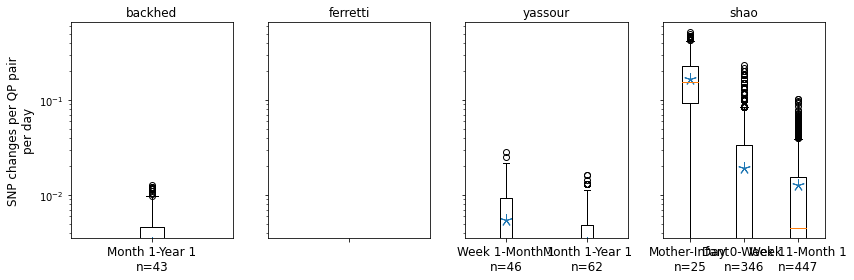

In [34]:
# SNP change rates boxplot, matched timepoint comparison
fig, ax = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

for i in range(4):
    
    dataset = cohorts[i]
    # Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 1000 times
    bootstrapped_rates_by_tp_type = bootstrapped_agg_from_list_dict(count_time_tups_by_cohort_tp_type[dataset], get_rate_from_tuples, 
                                                                    num_bootstraps=1000, n=20)
    
    annotations = [] # These are the true "average" rates per category
    tp_type_labels = [] # These are used as x-axis labels
    bootstrapped_rates = [] # Data
    
    for tp_type in tp_types:
        if len(bootstrapped_rates_by_tp_type[tp_type]) < 10:
            continue
        snp_count, total_days = (0,0)
        for count, days in count_time_tups_by_cohort_tp_type[dataset][tp_type]:
            snp_count += count
            total_days += days
        bootstrapped_rates.append(bootstrapped_rates_by_tp_type[tp_type])
        annotations.append(float(snp_count)/total_days)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_cohort_tp_type[dataset][tp_type])))

    ax[i].plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
    ax[i].boxplot(bootstrapped_rates)
    # ax.set_ylim(0, 0.14)
    ax[i].set_yscale('log')
    ax[i].set_xticklabels(tp_type_labels, fontsize=12)    
    ax[i].set_title(dataset)
    # ax[i].set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

ax[0].set_ylabel("SNP changes per QP pair\nper day", fontsize=12)
plt.tight_layout()
plt.show()

In [165]:
# Compare delivery modes

cats = ['Vaginal', 'C-section']
replacement_time_tups_by_cat_tp_type = {cat: defaultdict(list) for cat in cats}

all_time_tups_by_cat_tp_type = {cat: defaultdict(list) for cat in cats}
subject_all_time_tups_by_tp_type = defaultdict(list) # For later delivery mode permutation

count_time_tups_by_cat_tp_type = {cat: defaultdict(list) for cat in cats}
subject_count_time_tups_by_tp_type = defaultdict(list) # For later delivery mode permutation

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        subject = sample_subject_map[s2]
        if subject not in subject_delivery_mode_map: # Skip non-infant second sample
            continue
        
        delivery_mode = subject_delivery_mode_map[subject]; cat = delivery_mode
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                replacement_time_tups_by_cat_tp_type[cat][custom_cohort].append((1, days))
                all_time_tups_by_cat_tp_type[cat][custom_cohort].append((val, days))
                subject_all_time_tups_by_tp_type[custom_cohort].append((subject, val, days))
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                count_time_tups_by_cat_tp_type[cat][custom_cohort].append((len(val), days))
                subject_count_time_tups_by_tp_type[custom_cohort].append((subject, len(val), days))
                all_time_tups_by_cat_tp_type[cat][custom_cohort].append((len(val), days))
                subject_all_time_tups_by_tp_type[custom_cohort].append((subject, len(val), days))


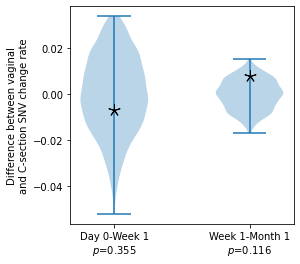

In [166]:
# Permutation test for delivery mode
# 1. permute C and V for all the babies
# 2. compute the SNV change rate for new C and new V babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between C and V

num_bootstraps = 1000
cats = ['Vaginal', 'C-section']

subjects = list(subject_delivery_mode_map.keys()) # Order matters!!
delivery_modes = [] # True/original
for subject in subjects:
    delivery_modes.append(subject_delivery_mode_map[subject])

true_snv_change_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in subject_count_time_tups_by_tp_type:
    total_days_by_cat_dict = defaultdict(int)
    total_snv_change_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
        delivery_mode = subject_delivery_mode_map[subject]
        total_days_by_cat_dict[delivery_mode] += days
        total_snv_change_count_by_cat_dict[delivery_mode] += count

    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        snv_change_rate = total_snv_change_count_by_cat_dict[cat]/days
        true_snv_change_rate_by_cat_tp_type_dict[cat][tp_type] = snv_change_rate

permuted_snv_change_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(delivery_modes) # Randomly permute delivery modes
    permuted_subject_delivery_mode_map = {}
    for subject, delivery_mode in zip(subjects, delivery_modes):
        permuted_subject_delivery_mode_map[subject] = delivery_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_snv_change_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            delivery_mode = permuted_subject_delivery_mode_map[subject]
            total_days_by_cat_dict[delivery_mode] += days
            total_snv_change_count_by_cat_dict[delivery_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                snv_change_rate = total_snv_change_count_by_cat_dict[cat]/days
            else:
                snv_change_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_snv_change_rates_by_cat_tp_type_dict[cat][tp_type].append(snv_change_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4, 4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for vrate, crate in zip(permuted_snv_change_rates_by_cat_tp_type_dict['Vaginal'][tp_type], 
                            permuted_snv_change_rates_by_cat_tp_type_dict['C-section'][tp_type]):
        null_differences.append(vrate-crate)
    null_differences_by_tp_type.append(null_differences)
    
    true_vrate = true_snv_change_rate_by_cat_tp_type_dict['Vaginal'][tp_type]
    true_crate = true_snv_change_rate_by_cat_tp_type_dict['C-section'][tp_type]
    true_difference = true_vrate-true_crate
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between vaginal\nand C-section SNV change rate")
plt.show()
fig.savefig('%s/delivery_mode_comparison_snv_change_rate.pdf' % config.analysis_directory)

In [133]:
# Summarize distribution by delivery, feeding mode
time_interval_category = 'Day 0-Week 1'
feeding_delivery_count_dict = {fmode: defaultdict(int) for fmode in ['breast', 'formula', 'mixed']}
for subject, count, days in subject_count_time_tups_by_tp_type[time_interval_category]:
    if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
        feeding_mode = subject_feeding_mode_map[subject]
        delivery_mode = subject_delivery_mode_map[subject]
        feeding_delivery_count_dict[feeding_mode][delivery_mode] += 1

dmodes = ['Vaginal', 'C-section']
fmodes = ['breast', 'formula', 'mixed']
print("SNV changes | %s" % time_interval_category)
print('----------------------')
print('\t' + '\t'.join(dmodes))
for fmode in fmodes:
    vals = [str(feeding_delivery_count_dict[fmode][dmode]) for dmode in dmodes]
    print("%s\t" % (fmode) + '\t'.join(vals))

SNV changes | Day 0-Week 1
----------------------
	Vaginal	C-section
breast	83	29
formula	44	23
mixed	109	59


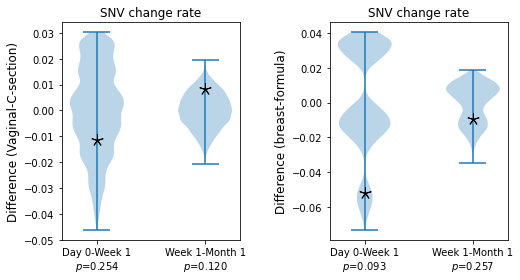

In [187]:
# Reproduce in the more elegant way heh
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']

# Vaginal vs. c-section
label_sets = [['Vaginal', 'C-section'], ['breast', 'formula']]
label_mode_type_list = [0, 1] # 0 for delivery mode, 1 for feeding mode

for i in range(2):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    
    null_differences_list = []
    true_difference_list = []
    labels = []
    for time_interval_category in time_interval_categories:
        orig_label_subject_data_dict = defaultdict(list)
        for label in label_set:
            for subject, count, days in subject_count_time_tups_by_tp_type[time_interval_category]:
                if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                    feeding_mode = subject_feeding_mode_map[subject]
                    delivery_mode = subject_delivery_mode_map[subject]
                    if label_mode_type == 0:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                    if label_mode_type == 1:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

        null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                     aggregator_fn=get_rate_from_tuples, num_bootstraps=10000)
        null_differences_list.append(null_differences)
        true_difference_list.append(true_difference)
        p = permutation_test_p(null_differences, true_difference)
        color = 'red' if p < 0.05 else 'black'
        labels.append('%s\n' % time_interval_category + r'$\it{p}$' + "=%.03f" % p)
    
    ax[i].violinplot(null_differences_list)
    ax[i].plot([1, 2], true_difference_list, marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(labels)
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    # ax[i].set_xlabel(r'$\it{p}$' + "=%.03f" % p, fontsize=12)
    ax[i].set_title("SNV change rate")

plt.subplots_adjust(wspace=0.5)
plt.show()
fig.savefig('%s/mode_comparisons_snv_change_rate.pdf' % config.analysis_directory)
fig.savefig('%s/mode_comparisons_snv_change_rate.png' % config.analysis_directory, dpi=200)

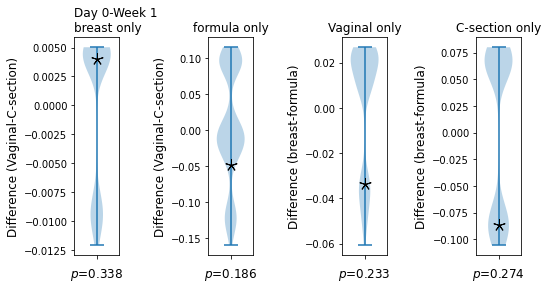

In [96]:
# Reproduce in the more elegant way heh
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 4, figsize=(8, 4))

time_interval_category = 'Day 0-Week 1'

# Vaginal vs. c-section, breast only
# Vaginal vs. c-section, formula only
# Breast vs. formula, Vaginal only
# Breast vs. formula, C-section only
label_sets = [['Vaginal', 'C-section'], ['Vaginal', 'C-section'], ['breast', 'formula'], ['breast', 'formula']]
label_mode_type_list = [0, 0, 1, 1] # 0 for delivery mode, 1 for feeding mode
restrict_other_mode_list = ['breast', 'formula', 'Vaginal', 'C-section']

for i in range(4):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    restrict_other_mode = restrict_other_mode_list[i]
    
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_count_time_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                if label_mode_type == 0:
                    if feeding_mode == restrict_other_mode:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                if label_mode_type == 1:
                    if delivery_mode == restrict_other_mode:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))
    
    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, aggregator_fn=get_rate_from_tuples)

    p = permutation_test_p(null_differences, true_difference)
    color = 'red' if p < 0.05 else 'black'
    ax[i].violinplot(null_differences)
    ax[i].plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
    ax[i].set_xticks([1]); ax[i].set_xticklabels([]); ax[i].set_xlim((0.6, 1.4))
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    ax[i].set_xlabel(r'$\it{p}$' + "=%.03f" % p, fontsize=12)
    if i == 0:
        ax[i].set_title("%s\n%s only" % (time_interval_category, restrict_other_mode), loc='left')
    else:
        ax[i].set_title("%s only" % restrict_other_mode)

plt.subplots_adjust(wspace=2)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


Skipping Month 1-Year 1
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Mother-Infant(all)
Skipping Mother-Infant(earliest)
Skipping II-1yr
Skipping Month 1-Year 1
Skipping 4-8mon duration infant
Skipping 6mon duration infant
Skipping Mother-Infant


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


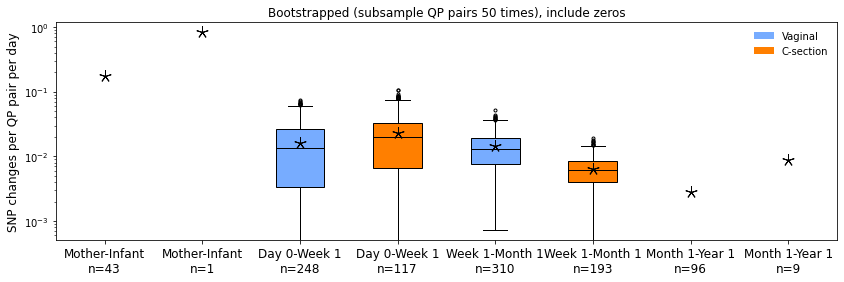

In [12]:
# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_rates_by_cat_tp_type = {cat: bootstrapped_agg_from_list_dict(count_time_tups_by_cat_tp_type[cat], 
                                                                          get_rate_from_tuples, num_bootstraps=1000, n=100) for cat in cats}

# SNP change rates boxplot
fig, ax = plt.subplots(figsize=(14,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = []
for tp_type in tp_types:
    for cat in cats:
        bootstrapped_rates.append(bootstrapped_rates_by_cat_tp_type[cat][tp_type])

for tp_type in tp_types:
    for cat in cats:
        snp_count, total_days = (0,0)
        for count, days in count_time_tups_by_cat_tp_type[cat][tp_type]:
            snp_count += count
            total_days += days
        annotations.append(float(snp_count)/total_days)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_cat_tp_type[cat][tp_type])))

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')
boxplots = ax.boxplot(bootstrapped_rates, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(bootstrapped_rates), step=2):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # C-section

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)

# ax.set_ylim(0, 0.14)
ax.set_yscale('log')
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Vaginal'), 
                   Patch(facecolor=plot_utils.col_orange, label='C-section')]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

In [27]:
# Store for later use
snp_change_rates_devmode = bootstrapped_rates[2:6]
snp_change_rate_annotations_devmode = annotations[2:6]
snp_change_rate_tp_type_labels_devmode = tp_type_labels[2:6]

Skipping Mother-Infant
Skipping Month 1-Year 1
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Mother-Infant(earliest)
Skipping Mother-Infant(all)
Skipping II-1yr
Skipping 4-8mon duration infant
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Month 1-Year 1


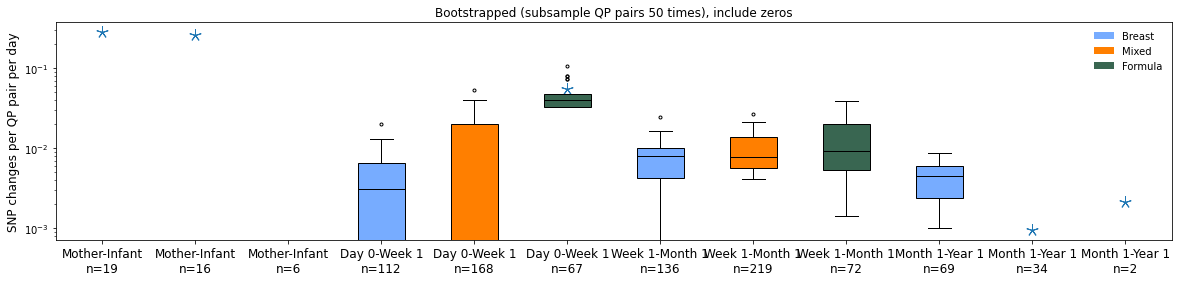

In [140]:
# Compare feeding modes

cats = ['breast', 'mixed', 'formula']

replacement_time_tups_by_cat_tp_type = {cat: defaultdict(list) for cat in cats}
all_time_tups_by_cat_tp_type = {cat: defaultdict(list) for cat in cats}
subject_all_time_tups_by_tp_type = defaultdict(list) # For later permutation tests
count_time_tups_by_cat_tp_type = {cat: defaultdict(list) for cat in cats}
subject_count_time_tups_by_tp_type = defaultdict(list) # For later permutation tests

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        subject = sample_subject_map[s2]
        if subject not in subject_feeding_mode_map: # Skip non-infant second sample
            continue
        
        feeding_mode = subject_feeding_mode_map[subject]; cat = feeding_mode
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                replacement_time_tups_by_cat_tp_type[cat][custom_cohort].append((1, days))
                
                all_time_tups_by_cat_tp_type[cat][custom_cohort].append((val, days))
                subject_all_time_tups_by_tp_type[custom_cohort].append((subject, val, days))
                
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                
                count_time_tups_by_cat_tp_type[cat][custom_cohort].append((len(val), days))
                subject_count_time_tups_by_tp_type[custom_cohort].append((subject, len(val), days))
                
                all_time_tups_by_cat_tp_type[cat][custom_cohort].append((len(val), days))
                subject_all_time_tups_by_tp_type[custom_cohort].append((subject, len(val), days))

# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_rates_by_cat_tp_type = {cat: bootstrapped_agg_from_list_dict(count_time_tups_by_cat_tp_type[cat], get_rate_from_tuples) for cat in cats}

# SNP change rates boxplot
fig, ax = plt.subplots(figsize=(20,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = []
for tp_type in tp_types:
    for cat in cats:
        bootstrapped_rates.append(bootstrapped_rates_by_cat_tp_type[cat][tp_type])

for tp_type in tp_types:
    for cat in cats:
        snp_count, total_days = (0,0)
        for count, days in count_time_tups_by_cat_tp_type[cat][tp_type]:
            snp_count += count
            total_days += days
        annotations.append(float(snp_count)/total_days)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(count_time_tups_by_cat_tp_type[cat][tp_type])))
    
ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')
boxplots = ax.boxplot(bootstrapped_rates, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(bootstrapped_rates), step=3):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Breast
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # Mixed
    boxplots['boxes'][i+2].set_facecolor(plot_utils.col_darkgreen) # Formula

# ax.set_ylim(0, 0.14)
ax.set_yscale('log')
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("SNP changes per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Breast'), 
                   Patch(facecolor=plot_utils.col_orange, label='Mixed'),
                   Patch(facecolor=plot_utils.col_darkgreen, label='Formula')]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

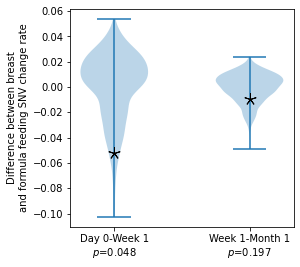

In [97]:
# Permutation test for feeding mode
# 1. permute feeding mode (formula vs. breast, ignore mixed) for all the babies
# 2. compute the SNV change rate for new B and new F babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between feeding modes

num_bootstraps = 1000
cats = ['formula', 'breast']
tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

subjects = list(subject_feeding_mode_map.keys()) # Order matters!!
feeding_modes = [] # True/original
for subject in subjects:
    feeding_modes.append(subject_feeding_mode_map[subject])

true_snv_change_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in tp_types:
    total_days_by_cat_dict = defaultdict(int)
    total_snv_change_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
        feeding_mode = subject_feeding_mode_map[subject]
        total_days_by_cat_dict[feeding_mode] += days
        total_snv_change_count_by_cat_dict[feeding_mode] += count
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        if days == 0:
            print("Can't use %s" % tp_type)
            continue
        snv_change_rate = total_snv_change_count_by_cat_dict[cat]/days
        true_snv_change_rate_by_cat_tp_type_dict[cat][tp_type] = snv_change_rate

permuted_snv_change_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(feeding_modes) # Randomly permute feeding modes
    permuted_subject_feeding_mode_map = {}
    for subject, feeding_mode in zip(subjects, feeding_modes):
        permuted_subject_feeding_mode_map[subject] = feeding_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_snv_change_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            feeding_mode = permuted_subject_feeding_mode_map[subject]
            total_days_by_cat_dict[feeding_mode] += days
            total_snv_change_count_by_cat_dict[feeding_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                snv_change_rate = total_snv_change_count_by_cat_dict[cat]/days
            else:
                snv_change_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_snv_change_rates_by_cat_tp_type_dict[cat][tp_type].append(snv_change_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for rate1, rate2 in zip(permuted_snv_change_rates_by_cat_tp_type_dict['breast'][tp_type], 
                            permuted_snv_change_rates_by_cat_tp_type_dict['formula'][tp_type]):
        null_differences.append(rate1-rate2)
    null_differences_by_tp_type.append(null_differences)
    true_rate1 = true_snv_change_rate_by_cat_tp_type_dict['breast'][tp_type]
    true_rate2 = true_snv_change_rate_by_cat_tp_type_dict['formula'][tp_type]
    true_difference = true_rate1-true_rate2
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between breast\nand formula feeding SNV change rate")
plt.show()
fig.savefig('%s/feeding_mode_comparison_snv_change_rate.pdf' % config.analysis_directory)

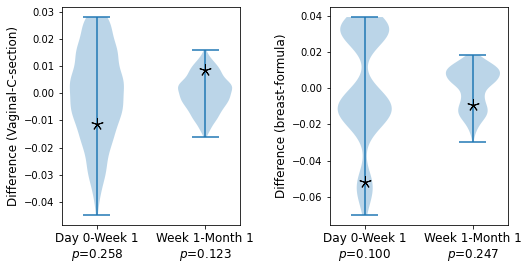

In [156]:
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# =====================================================================
# Delivery mode
time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']
mult_null_differences = []
mult_true_differences = []
plot_labels = []

label_set = ['Vaginal', 'C-section']

for time_interval_category in time_interval_categories:
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_count_time_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))

    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_rate_from_tuples)
    p = permutation_test_p(null_differences, true_difference)
    
    mult_null_differences.append(null_differences)
    mult_true_differences.append(true_difference)
    plot_labels.append(("%s\n" % time_interval_category) + r'$\it{p}$' + ("=%.03f" % (p)))

i = 0

xs = np.arange(1, 1+len(mult_true_differences))
ax[i].violinplot(mult_null_differences)
ax[i].plot(xs, mult_true_differences, marker=(5, 2), 
           linestyle='None', markersize=12, color=color, zorder=9)

ax[i].set_xticks(xs)
ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
ax[i].set_xticklabels(plot_labels, fontsize=12)
# =====================================================================

# =====================================================================
# Feeding mode
time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']
mult_null_differences = []
mult_true_differences = []
plot_labels = []

label_set = ['breast', 'formula']

for time_interval_category in time_interval_categories:
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_count_time_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_rate_from_tuples)
    p = permutation_test_p(null_differences, true_difference)
    
    mult_null_differences.append(null_differences)
    mult_true_differences.append(true_difference)
    plot_labels.append(("%s\n" % time_interval_category) + r'$\it{p}$' + ("=%.03f" % (p)))

i += 1

xs = np.arange(1, 1+len(mult_true_differences))
ax[i].violinplot(mult_null_differences)
ax[i].plot(xs, mult_true_differences, marker=(5, 2), 
           linestyle='None', markersize=12, color=color, zorder=9)

ax[i].set_xticks(xs)
ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
ax[i].set_xticklabels(plot_labels, fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.show()

# ==================
# Replacement rates
# ==================

Skipping 6mon duration infant
Mother-Infant: 0.016286644951140065
Day 0-Week 1: 0.008857395925597875
Week 1-Month 1: 0.0013646702047005307
Month 1-Year 1: 0.0009921250077509767
Adult-Adult: 0.00012590969756490645


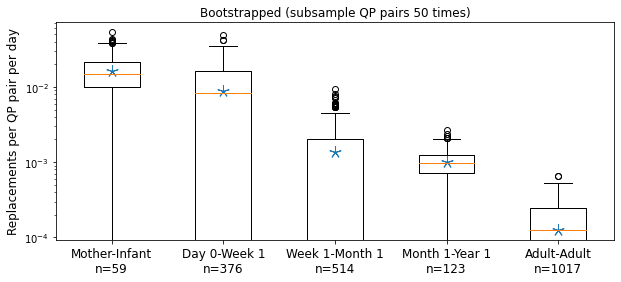

In [193]:
# Subsample QP pairs in a category to n=40 and get #sweeps/day, bootstrap x times
bootstrapped_rates_by_tp_type = bootstrapped_agg_from_list_dict(all_time_tups_by_tp_type, get_replacement_rate_from_tuples,
                                                               num_bootstraps=1000, n=40)

# Replacement rates boxplot
fig, ax = plt.subplots(figsize=(10,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type in tp_types:
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (tp_type, len(all_time_tups_by_tp_type[tp_type])))

ax.set_yscale('log')
ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("Replacements per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")
for tp_type, annotation in zip(tp_types, annotations):
    print("%s: %s" % (tp_type, annotation))

plt.show()

# fig.savefig('%s/replacement_rates_by_tp_type_overall_with_zeros_labelled.pdf' % plot_dir, bbox_inches='tight')

In [134]:
# store for later use
replacement_rates = bootstrapped_rates
replacement_rate_annotations = annotations
replacement_rate_tp_type_labels = tp_type_labels

# Get statistics for paper
print(replacement_rate_annotations)

[0.016286644951140065, 0.008857395925597875, 0.0013646702047005307, 0.0009921250077509767, 0.00012590969756490645]


T: 96.74	p: 0.000E+00


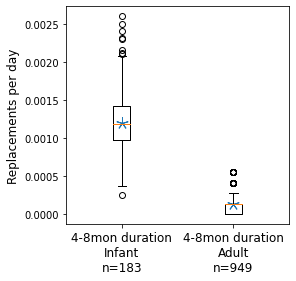

In [49]:
# Matched
# replacement rates boxplot
# Uses bootstrapped_rates_by_tp_type from above with n=40, num_bootstraps=1000

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels

bootstrapped_rates = [bootstrapped_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    replacement_count, total_days = (0,0)
    for num_snp_changes, days in all_time_tups_by_tp_type[tp_type]:
        if num_snp_changes >= 500:
            replacement_count += 1
        total_days += days
    annotations.append(float(replacement_count)/total_days)
    tp_type_labels.append('%s\nn=%i' % (label, len(all_time_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("Replacements per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_rates[0], bootstrapped_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

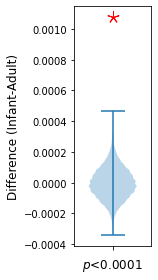

In [36]:
# Permutation test for infant vs. adult
label_set = ['4-8mon duration infant', '4-8mon duration adult']
orig_label_data_dict = {label: all_time_tups_by_tp_type[label] for label in label_set}
null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                     aggregator_fn=get_replacement_rate_from_tuples,
                                                    num_bootstraps=10000)

# Plot permutation test results
fig, ax = plt.subplots(figsize=(2.3, 4))
p = permutation_test_p(null_differences, true_difference)
color = 'red' if p < 0.05 else 'gray'
ax.violinplot(null_differences)
ax.plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
ax.set_xticks([1]); ax.set_xticklabels([]); ax.set_xlim((0.6, 1.4))
ax.set_ylabel("Difference (Infant-Adult)", fontsize=12)
ax.set_xlabel(r'$\it{p}$' + ("<0.0001" if p == 0 else "=%.03f" % p), fontsize=12)
plt.tight_layout()
fig.savefig('%s/infant_vs_adult_comparison_replacement_rate.pdf' % config.analysis_directory)

In [155]:
# Perform PERMUTATION tests between all pairs

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

replacement_rate_tp_pair_ptests = {} # (tp1, tp2) -> n1, n2, p

print("REPLACEMENT RATE TIMEPOINT PAIRWISE COMPARISONS")

for i in range(len(tp_types)):
    tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        tp_type2 = tp_types[j]
        # Permutation test for tp_type 1 vs._tp type2
        label_set = [tp_type1, tp_type2]
        orig_label_data_dict = {label: all_time_tups_by_tp_type[label] for label in label_set}
        null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                             aggregator_fn=get_replacement_rate_from_tuples,
                                                            num_bootstraps=10000)
        p = permutation_test_p(null_differences, true_difference)
        n1 = len(orig_label_data_dict[tp_type1])
        n2 = len(orig_label_data_dict[tp_type2])
        replacement_rate_tp_pair_ptests[(tp_type1, tp_type2)] = (n1, n2, p)
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        print(str(p) + '\t' + get_sig_str(p))

REPLACEMENT RATE TIMEPOINT PAIRWISE COMPARISONS
Mother-Infant vs. Day 0-Week 1
0.13129999999999997	ns
Mother-Infant vs. Week 1-Month 1
0.0	***
Mother-Infant vs. Month 1-Year 1
0.0	***
Mother-Infant vs. Adult-Adult
0.0	***
Day 0-Week 1 vs. Week 1-Month 1
0.0	***
Day 0-Week 1 vs. Month 1-Year 1
0.0	***
Day 0-Week 1 vs. Adult-Adult
0.0	***
Week 1-Month 1 vs. Month 1-Year 1
0.2469	ns
Week 1-Month 1 vs. Adult-Adult
0.0	***
Month 1-Year 1 vs. Adult-Adult
0.0	***


In [162]:
# Perform tests between all pairs

replacement_rate_tp_pair_tests = {} # (tp1, tp2) -> (t, p, es) Store for later table

print("REPLACEMENT RATE TIMEPOINT PAIRWISE COMPARISONS")
print("Note: all sample sizes are the same")

for i in range(len(tp_types)):
    ind_rates1 = bootstrapped_rates[i]; tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        ind_rates2 = bootstrapped_rates[j]; tp_type2 = tp_types[j]
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        stat, p, es = summarize_utest(ind_rates1, ind_rates2, simple=True)
        replacement_rate_tp_pair_tests[(tp_type1, tp_type2)] = (stat, p, es)
        print(get_sig_str(p))        

REPLACEMENT RATE TIMEPOINT PAIRWISE COMPARISONS
Note: all sample sizes are the same
Mother-Infant vs. Day 0-Week 1
U=992270.0000
P=0.0
Effect size: inf
***
Mother-Infant vs. Week 1-Month 1
U=997957.0000
P=0.0
Effect size: inf
***
Mother-Infant vs. Month 1-Year 1
U=999890.0000
P=0.0
Effect size: inf
***
Mother-Infant vs. Adult-Adult
U=1000000.0000
P=0.0
Effect size: inf
***
Day 0-Week 1 vs. Week 1-Month 1
U=444344.5000
P=1.1925403877007798e-05
Effect size: 0.09791623524046694
***
Day 0-Week 1 vs. Month 1-Year 1
U=473084.0000
P=0.03534633526836691
Effect size: 0.047055104949414756
*
Day 0-Week 1 vs. Adult-Adult
U=481695.5000
P=0.15177014104520622
Effect size: 0.03204971738757313
ns
Week 1-Month 1 vs. Month 1-Year 1
U=774079.0000
P=5.442584262338112e-100
Effect size: 0.4746377658978996
***
Week 1-Month 1 vs. Adult-Adult
U=864463.5000
P=2.59287073393339e-175
Effect size: 0.6312148928437669
***
Month 1-Year 1 vs. Adult-Adult
U=744484.0000
P=6.087904225346112e-80
Effect size: 0.4233568592606

Skipping II-1yr
Skipping Mother-Infant(earliest)
Skipping Mother-Infant(all)
Skipping Week 1-Month 1
Skipping Mother-Infant
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping II-1yr


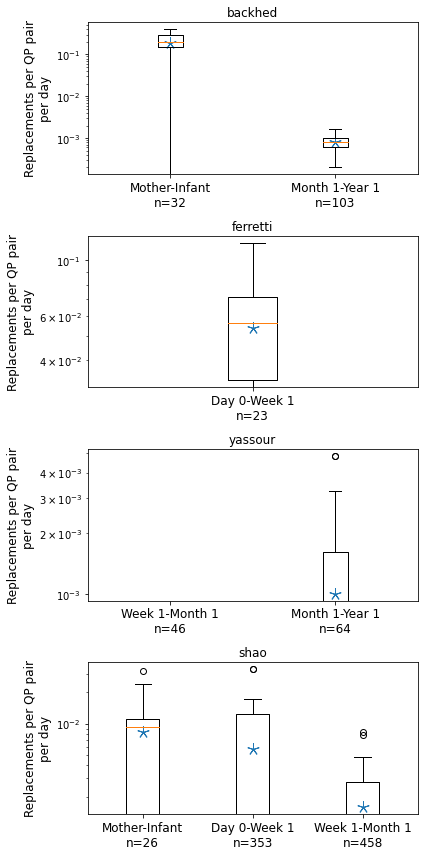

In [81]:
# Replacement rates by cohort boxplot
fig, ax = plt.subplots(4, 1, figsize=(6, 12))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

for i in range(4):
    
    dataset = cohorts[i]
    # Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
    bootstrapped_rates_by_tp_type = bootstrapped_agg_from_list_dict(all_time_tups_by_cohort_tp_type[dataset], get_replacement_rate_from_tuples, n=20)
    
    annotations = [] # These are the true "average" rates per category
    tp_type_labels = [] # These are used as x-axis labels
    bootstrapped_rates = [] # Data
    
    for tp_type in tp_types:
        if len(bootstrapped_rates_by_tp_type[tp_type]) < 10:
            continue
        replacement_count, total_days = (0,0)
        for num_snp_changes, days in all_time_tups_by_cohort_tp_type[dataset][tp_type]:
            if num_snp_changes >= 500:
                replacement_count += 1
            total_days += days
        bootstrapped_rates.append(bootstrapped_rates_by_tp_type[tp_type])
        annotations.append(float(replacement_count)/total_days)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(all_time_tups_by_cohort_tp_type[dataset][tp_type])))
    
    ax[i].plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
    ax[i].boxplot(bootstrapped_rates)
    # ax.set_ylim(0, 0.14)
    ax[i].set_yscale('log')
    ax[i].set_xticklabels(tp_type_labels, fontsize=12)
    ax[i].set_ylabel("Replacements per QP pair\nper day", fontsize=12)
    ax[i].set_title(dataset)
    # ax[i].set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

plt.tight_layout()
plt.show()

Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Mother-Infant(earliest)
Skipping Mother-Infant(all)
Skipping II-1yr
Skipping 4-8mon duration infant
Skipping 6mon duration infant
Skipping Month 1-Year 1
Skipping Mother-Infant


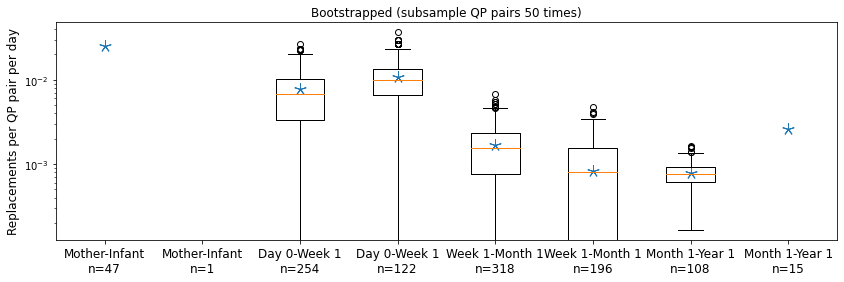

In [137]:
all_time_tups_by_devmode_tp_type = all_time_tups_by_cat_tp_type
devmodes = ['Vaginal', 'C-section']

# Subsample QP pairs in a category and get #sweeps/day, bootstrap 1000 times
bootstrapped_rates_by_devmode_tp_type = {dm: bootstrapped_agg_from_list_dict(all_time_tups_by_devmode_tp_type[dm], 
                                                                             get_replacement_rate_from_tuples,
                                                                            num_bootstraps=1000, n=100) for dm in devmodes}

# Replacement rates boxplot
fig, ax = plt.subplots(figsize=(14,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels
                                         
bootstrapped_rates = []
for tp_type in tp_types:
    for dm in devmodes:
        bootstrapped_rates.append(bootstrapped_rates_by_devmode_tp_type[dm][tp_type])

for tp_type in tp_types:
    for dm in devmodes:
        replacement_count, total_days = (0,0)
        for num_snp_changes, days in all_time_tups_by_devmode_tp_type[dm][tp_type]:
            if num_snp_changes >= 500:
                replacement_count += 1
            total_days += days
        annotations.append(float(replacement_count)/total_days)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(all_time_tups_by_devmode_tp_type[dm][tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_rates)
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_yscale('log')
ax.set_ylabel("Replacements per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times)")

plt.show()

In [32]:
# Store for later use
replacement_rates_devmode = bootstrapped_rates[2:6]
replacement_rate_annotations_devmode = annotations[2:6]
replacement_rate_tp_type_labels_devmode = tp_type_labels[2:6]

In [135]:
# Summarize distribution by delivery, feeding mode
time_interval_category = 'Week 1-Month 1'
feeding_delivery_count_dict = {fmode: defaultdict(int) for fmode in ['breast', 'formula', 'mixed']}
for subject, count, days in subject_all_time_tups_by_tp_type[time_interval_category]:
    if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
        feeding_mode = subject_feeding_mode_map[subject]
        delivery_mode = subject_delivery_mode_map[subject]
        feeding_delivery_count_dict[feeding_mode][delivery_mode] += 1

dmodes = ['Vaginal', 'C-section']
fmodes = ['breast', 'formula', 'mixed']
print("SNV changes | %s" % time_interval_category)
print('----------------------')
print('\t' + '\t'.join(dmodes))
for fmode in fmodes:
    vals = [str(feeding_delivery_count_dict[fmode][dmode]) for dmode in dmodes]
    print("%s\t" % (fmode) + '\t'.join(vals))

SNV changes | Week 1-Month 1
----------------------
	Vaginal	C-section
breast	108	31
formula	46	29
mixed	118	106


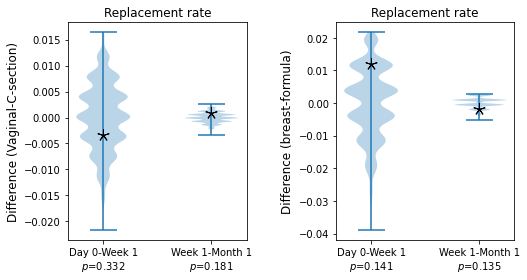

In [188]:
# Reproduce in the more elegant way heh
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']

# Vaginal vs. c-section
label_sets = [['Vaginal', 'C-section'], ['breast', 'formula']]
label_mode_type_list = [0, 1] # 0 for delivery mode, 1 for feeding mode

for i in range(2):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    
    null_differences_list = []
    true_difference_list = []
    labels = []
    for time_interval_category in time_interval_categories:
        orig_label_subject_data_dict = defaultdict(list)
        for label in label_set:
            for subject, count, days in subject_all_time_tups_by_tp_type[time_interval_category]:
                if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                    feeding_mode = subject_feeding_mode_map[subject]
                    delivery_mode = subject_delivery_mode_map[subject]
                    if label_mode_type == 0:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                    if label_mode_type == 1:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

        null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                     aggregator_fn=get_replacement_rate_from_tuples, num_bootstraps=10000)
        null_differences_list.append(null_differences)
        true_difference_list.append(true_difference)
        p = permutation_test_p(null_differences, true_difference)
        color = 'red' if p < 0.05 else 'black'
        labels.append('%s\n' % time_interval_category + r'$\it{p}$' + "=%.03f" % p)
    
    ax[i].violinplot(null_differences_list)
    ax[i].plot([1, 2], true_difference_list, marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(labels)
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    # ax[i].set_xlabel(r'$\it{p}$' + "=%.03f" % p, fontsize=12)
    ax[i].set_title("Replacement rate")

plt.subplots_adjust(wspace=0.5)
plt.show()
fig.savefig('%s/mode_comparisons_replacement_rate.pdf' % config.analysis_directory)
fig.savefig('%s/mode_comparisons_replacement_rate.png' % config.analysis_directory, dpi=200)

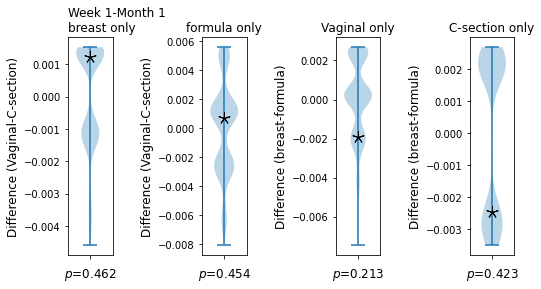

In [98]:
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 4, figsize=(8, 4))

time_interval_category = 'Week 1-Month 1'

label_sets = [['Vaginal', 'C-section'], ['Vaginal', 'C-section'], ['breast', 'formula'], ['breast', 'formula']]
label_mode_type_list = [0, 0, 1, 1] # 0 for delivery mode, 1 for feeding mode
restrict_other_mode_list = ['breast', 'formula', 'Vaginal', 'C-section']

for i in range(4):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    restrict_other_mode = restrict_other_mode_list[i]
    
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_all_time_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                if label_mode_type == 0:
                    if feeding_mode == restrict_other_mode:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                if label_mode_type == 1:
                    if delivery_mode == restrict_other_mode:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))
    
    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_replacement_rate_from_tuples)

    p = permutation_test_p(null_differences, true_difference)
    color = 'red' if p < 0.05 else 'black'
    ax[i].violinplot(null_differences)
    ax[i].plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
    ax[i].set_xticks([1]); ax[i].set_xticklabels([]); ax[i].set_xlim((0.6, 1.4))
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    ax[i].set_xlabel(r'$\it{p}$' + ("<0.0001" if p == 0 else "=%.03f" % p), fontsize=12)
    if i == 0:
        ax[i].set_title("%s\n%s only" % (time_interval_category, restrict_other_mode), loc='left')
    else:
        ax[i].set_title("%s only" % restrict_other_mode)

plt.subplots_adjust(wspace=2)
plt.show()

Skipping Mother-Infant
Skipping Month 1-Year 1
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Mother-Infant(earliest)
Skipping Mother-Infant(all)
Skipping II-1yr
Skipping 4-8mon duration infant
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Month 1-Year 1


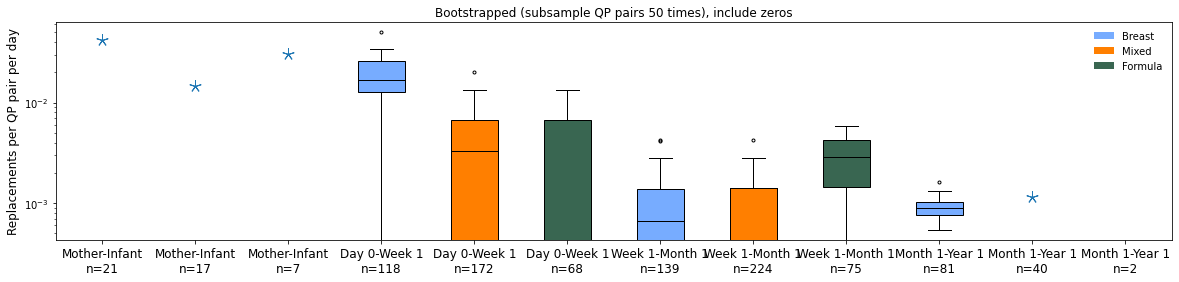

In [141]:
# Compare feeding modes

cats = ['breast', 'mixed', 'formula']

# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_rates_by_cat_tp_type = {cat: bootstrapped_agg_from_list_dict(all_time_tups_by_cat_tp_type[cat], get_replacement_rate_from_tuples) for cat in cats}

# Replacement rates boxplot
fig, ax = plt.subplots(figsize=(20,4))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']
annotations = [] # These are the true "average" rates per category
tp_type_labels = [] # These are used as x-axis labels
                                         
bootstrapped_rates = []
for tp_type in tp_types:
    for cat in cats:
        bootstrapped_rates.append(bootstrapped_rates_by_cat_tp_type[cat][tp_type])

for tp_type in tp_types:
    for cat in cats:
        replacement_count, total_days = (0,0)
        for num_snp_changes, days in all_time_tups_by_cat_tp_type[cat][tp_type]:
            if num_snp_changes >= 500:
                replacement_count += 1
            total_days += days
        annotations.append(float(replacement_count)/total_days)
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(all_time_tups_by_cat_tp_type[cat][tp_type])))

ax.plot(np.arange(1, 1+len(annotations)), annotations, marker=(5, 2), linestyle='None', markersize=12)

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')
boxplots = ax.boxplot(bootstrapped_rates, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(bootstrapped_rates), step=3):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Breast
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # Mixed
    boxplots['boxes'][i+2].set_facecolor(plot_utils.col_darkgreen) # Formula

# ax.set_ylim(0, 0.14)
ax.set_yscale('log')
ax.set_xticklabels(tp_type_labels, fontsize=12)
ax.set_ylabel("Replacements per QP pair per day", fontsize=12)
ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Breast'), 
                   Patch(facecolor=plot_utils.col_orange, label='Mixed'),
                   Patch(facecolor=plot_utils.col_darkgreen, label='Formula')]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

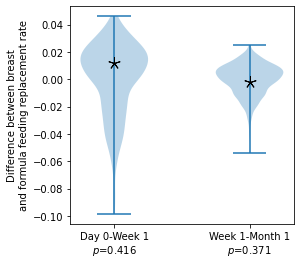

In [142]:
# Permutation test for feeding mode
# 1. permute feeding mode (formula vs. breast, ignore mixed) for all the babies
# 2. compute the SNV change rate for new B and new F babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between feeding modes

num_bootstraps = 1000
cats = ['formula', 'breast']
tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

subjects = list(subject_feeding_mode_map.keys()) # Order matters!!
feeding_modes = [] # True/original
for subject in subjects:
    feeding_modes.append(subject_feeding_mode_map[subject])

true_replacement_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in tp_types:
    total_days_by_cat_dict = defaultdict(int)
    total_replacement_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_all_time_tups_by_tp_type[tp_type]:
        feeding_mode = subject_feeding_mode_map[subject]
        total_days_by_cat_dict[feeding_mode] += days
        if count >= 500:
            total_replacement_count_by_cat_dict[feeding_mode] += 1
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        replacement_rate = total_replacement_count_by_cat_dict[cat]/days
        true_replacement_rate_by_cat_tp_type_dict[cat][tp_type] = replacement_rate

permuted_replacement_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(feeding_modes) # Randomly permute feeding modes
    permuted_subject_feeding_mode_map = {}
    for subject, feeding_mode in zip(subjects, feeding_modes):
        permuted_subject_feeding_mode_map[subject] = feeding_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_replacement_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            feeding_mode = permuted_subject_feeding_mode_map[subject]
            total_days_by_cat_dict[feeding_mode] += days
            total_replacement_count_by_cat_dict[feeding_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                replacement_rate = total_replacement_count_by_cat_dict[cat]/days
            else:
                replacement_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_replacement_rates_by_cat_tp_type_dict[cat][tp_type].append(replacement_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for rate1, rate2 in zip(permuted_replacement_rates_by_cat_tp_type_dict['breast'][tp_type], 
                            permuted_replacement_rates_by_cat_tp_type_dict['formula'][tp_type]):
        null_differences.append(rate1-rate2)
    null_differences_by_tp_type.append(null_differences)
    true_rate1 = true_replacement_rate_by_cat_tp_type_dict['breast'][tp_type]
    true_rate2 = true_replacement_rate_by_cat_tp_type_dict['formula'][tp_type]
    true_difference = true_rate1-true_rate2
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between breast\nand formula feeding replacement rate")
plt.show()
fig.savefig('%s/feeding_mode_comparison_replacement_rate.pdf' % config.analysis_directory)

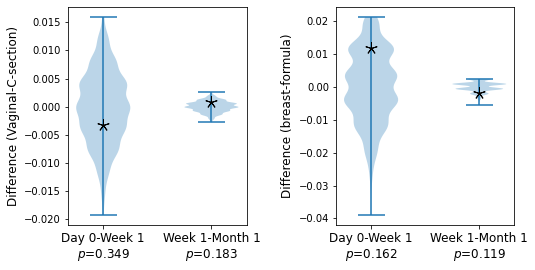

In [154]:
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# =====================================================================
# Delivery mode
time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']
mult_null_differences = []
mult_true_differences = []
plot_labels = []

label_set = ['Vaginal', 'C-section']

for time_interval_category in time_interval_categories:
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_all_time_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))

    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_replacement_rate_from_tuples)
    p = permutation_test_p(null_differences, true_difference)
    
    mult_null_differences.append(null_differences)
    mult_true_differences.append(true_difference)
    plot_labels.append(("%s\n" % time_interval_category) + r'$\it{p}$' + ("=%.03f" % (p)))

i = 0

xs = np.arange(1, 1+len(mult_true_differences))
ax[i].violinplot(mult_null_differences)
ax[i].plot(xs, mult_true_differences, marker=(5, 2), 
           linestyle='None', markersize=12, color=color, zorder=9)

ax[i].set_xticks(xs)
ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
ax[i].set_xticklabels(plot_labels, fontsize=12)
# =====================================================================

# =====================================================================
# Feeding mode
time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']
mult_null_differences = []
mult_true_differences = []
plot_labels = []

label_set = ['breast', 'formula']

for time_interval_category in time_interval_categories:
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_all_time_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_replacement_rate_from_tuples)
    p = permutation_test_p(null_differences, true_difference)
    
    mult_null_differences.append(null_differences)
    mult_true_differences.append(true_difference)
    plot_labels.append(("%s\n" % time_interval_category) + r'$\it{p}$' + ("=%.03f" % (p)))

i += 1

xs = np.arange(1, 1+len(mult_true_differences))
ax[i].violinplot(mult_null_differences)
ax[i].plot(xs, mult_true_differences, marker=(5, 2), 
           linestyle='None', markersize=12, color=color, zorder=9)

ax[i].set_xticks(xs)
ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
ax[i].set_xticklabels(plot_labels, fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
# Change to violin plot
# Add p value in the xlabel
# Combine feeding and delivery mode into one huge plot

In [ ]:
# Get rank of given value in given list
# where rank ranges from 0 (<= min(list)) to len()

In [65]:
# Closer look at replacement rates data

num_replacement = 0
total = 0

for num_snp_diffs, days in all_time_tups_by_devmode_tp_type['Vaginal']['Month 1-Year 1']:
    total += 1
    if num_snp_diffs > 20:
        num_replacement += 1

num_replacement_csection = 0
total_csection = 0

for num_snp_diffs, days in all_time_tups_by_devmode_tp_type['C-section']['Month 1-Year 1']:
    total_csection += 1
    if num_snp_diffs > 20:
        num_replacement_csection += 1

print("%i/%i vaginal QP pairs are replacements" % (num_replacement, total))
print("%i/%i C-section QP pairs are replacements" % (num_replacement_csection, total_csection))
print()
for num_snp_diffs, days, subject in all_time_tups_with_subject_by_devmode_tp_type['C-section']['Month 1-Year 1']:
    if num_snp_diffs > 20:
        print((num_snp_diffs, days, subject))
print('======')
for num_snp_diffs, days, subject in all_time_tups_with_subject_by_devmode_tp_type['C-section']['Month 1-Year 1']:
    if num_snp_diffs <= 20:
        print((num_snp_diffs, days, subject))

18/149 vaginal QP pairs are replacements
6/18 C-section QP pairs are replacements

(1373, 244, '23-I')
(15995, 244, '64-I')
(29530, 244, '60-I')
(4003, 244, '60-I')
(468, 244, '66-I')
(22240, 31, 'M0901-C')
(5, 244, '25-I')
(1, 31, 'M0901-C')
(0, 31, 'M0744-C')
(0, 31, 'M0369-C')
(0, 31, 'M0072-C')
(0, 31, 'M0744-C')
(1, 31, 'M0744-C')
(0, 244, '65-I')
(0, 244, '72-I')
(0, 31, 'M0369-C')
(4, 244, '23-I')
(3, 244, '98-I')


In [53]:
all_time_tups_with_subject_by_devmode_tp_type = {dm: defaultdict(list) for dm in devmodes}

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        subject = sample_subject_map[s2]
        if subject not in subject_delivery_mode_map: # Skip non-infant second sample
            continue
        
        delivery_mode = subject_delivery_mode_map[subject]
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                all_time_tups_with_subject_by_devmode_tp_type[delivery_mode][custom_cohort].append((val, days, subject))
                
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                all_time_tups_with_subject_by_devmode_tp_type[delivery_mode][custom_cohort].append((len(val), days, subject))

In [52]:
print(num_replacement)
print(total)
print(num_replacement_csection)
print(total_csection)

17
149
5
18


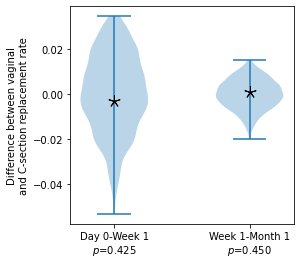

In [90]:
# Permutation test for delivery mode
# 1. permute C and V for all the babies
# 2. compute the SNV change rate for new C and new V babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between C and V

num_bootstraps = 1000
cats = ['Vaginal', 'C-section']

subjects = list(subject_delivery_mode_map.keys()) # Order matters!!
delivery_modes = [] # True/original
for subject in subjects:
    delivery_modes.append(subject_delivery_mode_map[subject])

true_replacement_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in subject_all_time_tups_by_tp_type:
    total_days_by_cat_dict = defaultdict(int)
    total_replacement_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_all_time_tups_by_tp_type[tp_type]:
        delivery_mode = subject_delivery_mode_map[subject]
        total_days_by_cat_dict[delivery_mode] += days
        if count >= 500:
            total_replacement_count_by_cat_dict[delivery_mode] += 1
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        replacement_rate = total_replacement_count_by_cat_dict[cat]/days
        true_replacement_rate_by_cat_tp_type_dict[cat][tp_type] = replacement_rate

permuted_replacement_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(delivery_modes) # Randomly permute delivery modes
    permuted_subject_delivery_mode_map = {}
    for subject, delivery_mode in zip(subjects, delivery_modes):
        permuted_subject_delivery_mode_map[subject] = delivery_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_replacement_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            delivery_mode = permuted_subject_delivery_mode_map[subject]
            total_days_by_cat_dict[delivery_mode] += days
            total_replacement_count_by_cat_dict[delivery_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                replacement_rate = total_replacement_count_by_cat_dict[cat]/days
            else:
                replacement_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_replacement_rates_by_cat_tp_type_dict[cat][tp_type].append(replacement_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4, 4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for vrate, crate in zip(permuted_replacement_rates_by_cat_tp_type_dict['Vaginal'][tp_type], 
                            permuted_replacement_rates_by_cat_tp_type_dict['C-section'][tp_type]):
        null_differences.append(vrate-crate)
    null_differences_by_tp_type.append(null_differences)
    
    true_vrate = true_replacement_rate_by_cat_tp_type_dict['Vaginal'][tp_type]
    true_crate = true_replacement_rate_by_cat_tp_type_dict['C-section'][tp_type]
    true_difference = true_vrate-true_crate
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between vaginal\nand C-section replacement rate")
plt.show()
fig.savefig('%s/delivery_mode_comparison_replacement_rate.pdf' % config.analysis_directory)

# ================
# Gene change rates
# ================

In [194]:
# Store gene change information

gain_tups_by_tp_type = defaultdict(list)
loss_tups_by_tp_type = defaultdict(list)
genes_gained_by_tp_type = defaultdict(set)

subject_gain_tups_by_tp_type = defaultdict(list)
subject_loss_tups_by_tp_type = defaultdict(list)

# infant subject -> (species, gene) genes gained
genes_gained_m1y1 = defaultdict(list)

bad = []

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        subject = sample_subject_map[s2]
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # SPECIAL: try recoding mother-infant duration as sum
        if 'Mother-Infant' in custom_cohorts:
            day1 = mi_sample_day_dict[s1]
            day2 = mi_sample_day_dict[s2]
            days = day1 + day2
            if days == 0:
                days = 1
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        '''
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        '''
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        # Try excluding the Mother-Infant(wk1) QP pair with unsually high number of losses
        if (num_losses >= 13) and ('Mother-Infant' in custom_cohorts):
            print("Sample pair %s, %s | %s" % (s1, s2, species))
            print("Num losses: %i | Num gains: %i" % (num_losses, num_gains))
            continue
        
        for custom_cohort in custom_cohorts:
            
            gain_tups_by_tp_type[custom_cohort].append((num_gains, days))
            subject_gain_tups_by_tp_type[custom_cohort].append((subject, num_gains, days))
            
            loss_tups_by_tp_type[custom_cohort].append((num_losses, days))
            subject_loss_tups_by_tp_type[custom_cohort].append((subject, num_losses, days))
            
            for gene, _, _, _, _ in gains:
                genes_gained_by_tp_type[custom_cohort].add((species, gene))
            
        if 'Month 1-Year 1' in custom_cohorts:
            if sample_subject_map[s1] != sample_subject_map[s2]:
                print("What??")
            infant_subject = sample_subject_map[s1]
            for gene, _, _, _, _ in gains:
                genes_gained_m1y1[infant_subject].append((species, gene))

Sample pair ERR3405407, ERR3405406 | Bacteroides_vulgatus_57955
Num losses: 13 | Num gains: 0


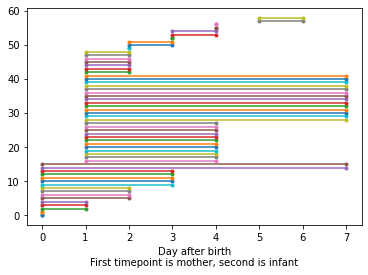

In [73]:
# Investigate the Mother-Infant category
# Namely, how much does Backhed higher resolution timepoint assignment change results?
# Are rates being inflated due to a smaller denominator due to mother timepoints 
# being mistakenly considered 0 when they are actually not 0?
total_days = 0
n = 0
day_tups = []

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        subject = sample_subject_map[s2]
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        if 'Mother-Infant' in custom_cohorts:
            day1 = mi_sample_day_dict[s1]
            day2 = mi_sample_day_dict[s2]
            # print('Mother %i\tInfant %i' % (day1, day2))
            day_tups.append((day1, day2))
            if days >= 0:
                total_days += days
                n += 1

fig, ax = plt.subplots()
idx = 0
for day1, day2 in sorted(day_tups):
    ax.plot([day1, day2], [idx, idx], '.-')
    idx += 1
ax.set_xlabel("Day after birth\nFirst timepoint is mother, second is infant")
plt.show()

In [97]:
genes_gained_by_tp_type.keys()

dict_keys(['Infant-Infant', 'II-1yr', '4-8mon duration adult', 'Adult-Adult', '6mon duration adult', '4-8mon duration infant', 'II-1mon', 'II-3mon', 'Mother-Infant(all)', 'Mother-Infant(earliest)', 'Day 0-Week 1', 'Week 1-Month 1', '6mon duration infant', 'Month 1-Year 1', 'Mother-Infant'])

In [69]:
# Check right away: Are the gene gains observed between 1 month and 1 year in infant observed in the mother?

tp_gene_presabs_dict = defaultdict(dict) # tp -> gene -> array of 0s and 1s

import bz2
for tp in genes_gained_by_tp_type:
    print(tp)
    all_species = set([species for species, gene in genes_gained_by_tp_type[tp]])
    for species in all_species:
        f = bz2.open('%s/genes/%s/genes_presabs.txt.bz2' % (config.data_directory, species), 'rt')
        header = f.readline().strip().split('\t') # Includes gene_id first column and with-c sample names
        mother_sample_idx_name_tups = [(header.index(s), s) for s in mother_samples if (s in header or (s+'c') in header)]
        # print(len(mother_sample_idx_name_tups))
        for line in f:
            items = line.strip().split('\t')
            gene = items[0]
            if (species, gene) in genes_gained_by_tp_type[tp]:
                tp_gene_presabs_dict[tp][gene] = [int(items[i]) for i, sample in mother_sample_idx_name_tups]

II-1yr
4-8mon duration infant
Month 1-Year 1
Infant-Infant
Adult-Adult
4-8mon duration adult
6mon duration adult
Mother-Infant(earliest)
Mother-Infant(all)
II-1mon
II-3mon
Day 0-Week 1
Week 1-Month 1
6mon duration infant
Mother-Infant


In [ ]:
num_total = len(mother_samples)
num_gene_pres_list = []

for gene in mother_gene_presabs_dict:
    num_species = len(mother_gene_presabs_dict[gene])
    num_gene_pres = sum(mother_gene_presabs_dict[gene]); num_gene_pres_list.append(num_gene_pres)
    print('%s:\tpresent in %i/%i mothers with species' % (gene, num_gene_pres, num_species))

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(20, 12), sharex=True)
tps = ['Mother-Infant(earliest)', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']
i=0
for tp in tps:
    num_gene_pres_list = [sum(tp_gene_presabs_dict[tp][gene]) for gene in tp_gene_presabs_dict[tp]]
    xs = np.arange(len(num_gene_pres_list))
    ax[i].set_title(tp)
    ax[i].bar(xs, height=num_gene_pres_list)
    ax[i].set_ylabel("Number of genes")
    i += 1
ax[0].set_title("Presence of genes gained in infant among %i mothers\n%s" % (len(mother_samples), tps[0]))
ax[4].set_xlabel("Number of mothers")

In [42]:
# Ok change to: Are the gene gains observed between 1 month and 1 year in infant observed in the same infant's mother?

subject_gene_presabs_dict = defaultdict(dict) # infant subject -> gene -> True/False

import bz2
for infant_subject in genes_gained_m1y1:
    genes_gained = genes_gained_m1y1[infant_subject]
    mother_subject = same_mi_pair_dict[infant_subject]
    my_mother_samples = list(subject_sample_map[mother_subject].keys())
    print(infant_subject)
    
    all_species = set([species for species, gene in genes_gained])
    for species in all_species:
        f = bz2.open('%s/genes/%s/genes_presabs.txt.bz2' % (config.data_directory, species), 'rt')
        header = f.readline().strip().split('\t') # Includes gene_id first column and with-c sample names
        mother_sample_idx_name_tups = [(header.index(s), s) for s in my_mother_samples if s in header]
        # print(len(mother_sample_idx_name_tups))
        for line in f:
            items = line.strip().split('\t')
            gene = items[0]
            if (species, gene) in genes_gained:
                subject_gene_presabs_dict[infant_subject][gene] = (1 in [int(items[i]) for i, sample in mother_sample_idx_name_tups])

26-I
M0346-C
31-I
54-I
M0764-C
78-I
M0744-C
M0450-C
94-I
67-I
14-I
10-I
56-I
47-I
59-I
29-I
93-I
3-I
21-I
1-I


In [44]:
subject_num_genes_pres_dict = defaultdict(int)

for infant_subject in subject_gene_presabs_dict:
    for gene in subject_gene_presabs_dict[infant_subject]:
        is_pres = subject_gene_presabs_dict[infant_subject][gene]
        subject_num_genes_pres_dict[infant_subject] += int(is_pres)

In [46]:
for infant_subject in subject_num_genes_pres_dict:
    print("Infant %s:\t%i of %i genes gained (M1-Y1) are present in mother" % (infant_subject, 
                                                                               subject_num_genes_pres_dict[infant_subject], 
                                                                              len(subject_gene_presabs_dict[infant_subject])))

Infant 26-I:	0 of 1 genes gained (M1-Y1) are present in mother
Infant M0346-C:	0 of 2 genes gained (M1-Y1) are present in mother
Infant 31-I:	0 of 1 genes gained (M1-Y1) are present in mother
Infant 54-I:	1 of 1 genes gained (M1-Y1) are present in mother
Infant M0764-C:	0 of 19 genes gained (M1-Y1) are present in mother
Infant 78-I:	3 of 3 genes gained (M1-Y1) are present in mother
Infant M0744-C:	0 of 2 genes gained (M1-Y1) are present in mother
Infant M0450-C:	0 of 20 genes gained (M1-Y1) are present in mother
Infant 94-I:	0 of 2 genes gained (M1-Y1) are present in mother
Infant 67-I:	3 of 9 genes gained (M1-Y1) are present in mother
Infant 14-I:	1 of 5 genes gained (M1-Y1) are present in mother
Infant 10-I:	21 of 21 genes gained (M1-Y1) are present in mother
Infant 56-I:	0 of 1 genes gained (M1-Y1) are present in mother
Infant 47-I:	0 of 5 genes gained (M1-Y1) are present in mother
Infant 59-I:	2 of 2 genes gained (M1-Y1) are present in mother
Infant 29-I:	2 of 2 genes gained (M1-Y1

In [25]:
for num_losses, days in loss_tups_by_tp_type['Mother-Infant']:
    if num_losses > 0:
        print((num_losses, days))

(1, 7)
(1, 3)
(1, 6)
(3, 3)
(2, 1)
(1, 1)
(2, 1)
(1, 6)
(1, 3)
(1, 1)
(1, 1)
(2, 1)


In [26]:
for num_gains, days in gain_tups_by_tp_type['Mother-Infant']:
    if num_gains > 0:
        print((num_gains, days))

(1, 7)
(1, 6)


Skipping 6mon duration infant
Skipping 6mon duration infant
Mother-Infant: 0.007407407407407408
Day 0-Week 1: 0.0779816513761468
Week 1-Month 1: 0.017388604253997825
Month 1-Year 1: 0.005904543217976054
Adult-Adult: 0.0005506035861954331
Mother-Infant: 0.06296296296296296
Day 0-Week 1: 0.06880733944954129
Week 1-Month 1: 0.038192827200745225
Month 1-Year 1: 0.0006560603575528948
Adult-Adult: 0.0003999667560098901


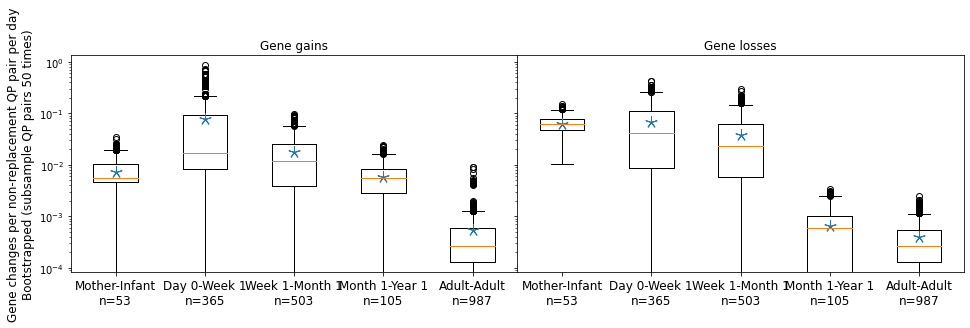

In [195]:
# Subsample QP pairs in a category to n and get #sweeps/day, bootstrap x times
bootstrapped_gain_rates_by_tp_type = bootstrapped_agg_from_list_dict(gain_tups_by_tp_type, get_rate_from_tuples,
                                                                    num_bootstraps=1000, n=40)
bootstrapped_loss_rates_by_tp_type = bootstrapped_agg_from_list_dict(loss_tups_by_tp_type, get_rate_from_tuples,
                                                                    num_bootstraps=1000, n=40)

# Gene gain/loss rates boxplot
fig, ax = plt.subplots(1, 2, figsize=(16,4), sharey=True)

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

# These are the true "average" rates per category
gain_annotations = []; loss_annotations = [] 

# These are used as x-axis labels
gain_tp_type_labels = []; loss_tp_type_labels = []

bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tt] for tt in tp_types]
bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tt] for tt in tp_types]

for tp_type in tp_types:
    
    # Store gain info
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days    
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i' % (tp_type, len(gain_tups_by_tp_type[tp_type])))
    
    # Store loss info
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i' % (tp_type, len(loss_tups_by_tp_type[tp_type])))

ax[0].set_yscale('log')
ax[0].boxplot(bootstrapped_gain_rates)
ax[0].plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[0].set_xticklabels(gain_tp_type_labels, fontsize=12)
ax[0].set_ylabel("Gene changes per non-replacement QP pair per day\nBootstrapped (subsample QP pairs 50 times)", fontsize=12)
ax[0].set_title("Gene gains")

ax[1].boxplot(bootstrapped_loss_rates)
ax[1].plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[1].set_xticklabels(loss_tp_type_labels, fontsize=12)
ax[1].set_title("Gene losses")

for tp_type, annotation in zip(tp_types, gain_annotations):
    print("%s: %s" % (tp_type, annotation))

for tp_type, annotation in zip(tp_types, loss_annotations):
    print("%s: %s" % (tp_type, annotation))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# fig.savefig('%s/gene_gain_and_loss_rates_by_tp_type_overall_with_zeros_labelled.png' % plot_dir, bbox_inches='tight', dpi=600)

T: 19.38	p: 7.801E-77


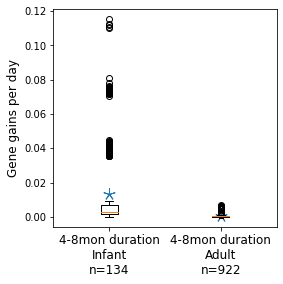

In [53]:
# Matched
# gene gain/loss rate boxplot
fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
gain_annotations = [] # These are the true "average" rates per category
gain_tp_type_labels = [] # These are used as x-axis labels

bootstrapped_gain_rates = [bootstrapped_gain_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    gain_count, total_days = (0,0)
    for num_gains, days in gain_tups_by_tp_type[tp_type]:
        gain_count += num_gains; total_days += days
    gain_annotations.append(float(gain_count)/total_days)
    gain_tp_type_labels.append('%s\nn=%i' % (label, len(gain_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_gain_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(gain_tp_type_labels, fontsize=12)
ax.set_ylabel("Gene gains per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_gain_rates[0], bootstrapped_gain_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

T: 32.40	p: 1.726E-185


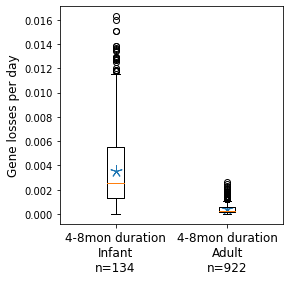

In [54]:
# Matched
# gene gain/loss rate boxplot
fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon duration\nInfant', '4-8mon duration\nAdult']
loss_annotations = [] # These are the true "average" rates per category
loss_tp_type_labels = [] # These are used as x-axis labels

bootstrapped_loss_rates = [bootstrapped_loss_rates_by_tp_type[tp_type] for tp_type in tp_types]
for tp_type, label in zip(tp_types, labels):
    loss_count, total_days = (0,0)
    for num_losss, days in loss_tups_by_tp_type[tp_type]:
        loss_count += num_losss; total_days += days
    loss_annotations.append(float(loss_count)/total_days)
    loss_tp_type_labels.append('%s\nn=%i' % (label, len(loss_tups_by_tp_type[tp_type])))

ax.plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax.boxplot(bootstrapped_loss_rates)
# ax.set_ylim(0, 0.14)
ax.set_xticklabels(loss_tp_type_labels, fontsize=12)
ax.set_ylabel("Gene losses per day", fontsize=12)
# ax.set_title("Bootstrapped (subsample QP pairs 50 times), include zeros")

t, p = stats.ttest_ind(bootstrapped_loss_rates[0], bootstrapped_loss_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))
plt.show()

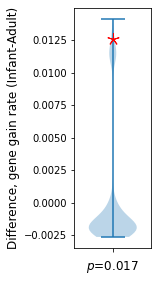

In [42]:
# Permutation test for infant vs. adult
label_set = ['4-8mon duration infant', '4-8mon duration adult']
orig_label_data_dict = {label: gain_tups_by_tp_type[label] for label in label_set}
null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                     aggregator_fn=get_rate_from_tuples,
                                                    num_bootstraps=10000)

# Plot permutation test results
fig, ax = plt.subplots(figsize=(2.3, 4))
p = permutation_test_p(null_differences, true_difference)
color = 'red' if p < 0.05 else 'black'
ax.violinplot(null_differences)
ax.plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
ax.set_xticks([1]); ax.set_xticklabels([]); ax.set_xlim((0.6, 1.4))
ax.set_ylabel("Difference, gene gain rate (Infant-Adult)", fontsize=12)
ax.set_xlabel(r'$\it{p}$' + ("<0.0001" if p == 0 else "=%.03f" % p), fontsize=12)
plt.tight_layout()
fig.savefig('%s/infant_vs_adult_comparison_gene_gain_rate.pdf' % config.analysis_directory)

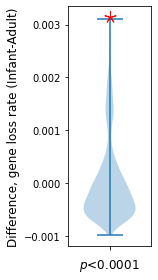

In [43]:
# Permutation test for infant vs. adult
label_set = ['4-8mon duration infant', '4-8mon duration adult']
orig_label_data_dict = {label: loss_tups_by_tp_type[label] for label in label_set}
null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                     aggregator_fn=get_rate_from_tuples,
                                                    num_bootstraps=10000)

# Plot permutation test results
fig, ax = plt.subplots(figsize=(2.3, 4))
p = permutation_test_p(null_differences, true_difference)
color = 'red' if p < 0.05 else 'gray'
ax.violinplot(null_differences)
ax.plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
ax.set_xticks([1]); ax.set_xticklabels([]); ax.set_xlim((0.6, 1.4))
ax.set_ylabel("Difference, gene loss rate (Infant-Adult)", fontsize=12)
ax.set_xlabel(r'$\it{p}$' + ("<0.0001" if p == 0 else "=%.03f" % p), fontsize=12)
plt.tight_layout()
fig.savefig('%s/infant_vs_adult_comparison_gene_loss_rate.pdf' % config.analysis_directory)

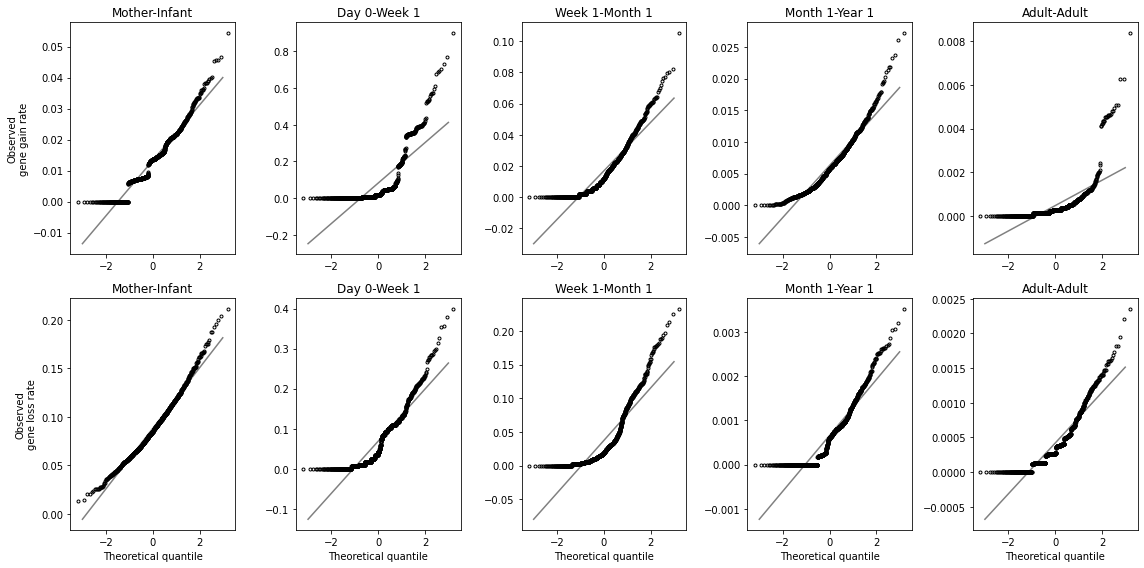

In [49]:
# QQ plots
from scipy import stats

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
xs = np.arange(-3, 3, 0.01)

for i, tp_type in zip(range(len(bootstrapped_gain_rates)), tp_types):
    vals = stats.probplot(bootstrapped_gain_rates[i])
    ax[0][i].set_title(tp_type)
    osm, osr = vals[0]; m, b, r = vals[1]
    ax[0][i].plot(xs, (m*xs)+b, color='gray')
    ax[0][i].plot(osm, osr, '.', color='black', mfc='none')

for i, tp_type in zip(range(len(bootstrapped_loss_rates)), tp_types):
    vals = stats.probplot(bootstrapped_loss_rates[i])
    ax[1][i].set_title(tp_type)
    osm, osr = vals[0]; m, b, r = vals[1]
    ax[1][i].plot(xs, (m*xs)+b, color='gray')
    ax[1][i].plot(osm, osr, '.', color='black', mfc='none')
    ax[1][i].set_xlabel("Theoretical quantile")

ax[0][0].set_ylabel("Observed\ngene gain rate")
ax[1][0].set_ylabel("Observed\ngene loss rate")

plt.tight_layout()

In [158]:
# Perform PERMUTATION tests between all pairs

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gene_gain_rate_tp_pair_ptests = {}

print("GENE GAIN RATE TIMEPOINT PAIRWISE COMPARISONS")

for i in range(len(tp_types)):
    tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        tp_type2 = tp_types[j]
        # Permutation test for tp_type 1 vs._tp type2
        label_set = [tp_type1, tp_type2]
        orig_label_data_dict = {label: gain_tups_by_tp_type[label] for label in label_set}
        null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                             aggregator_fn=get_rate_from_tuples,
                                                            num_bootstraps=10000)
        p = permutation_test_p(null_differences, true_difference)
        n1 = len(orig_label_data_dict[tp_type1])
        n2 = len(orig_label_data_dict[tp_type2])
        gene_gain_rate_tp_pair_ptests[(tp_type1, tp_type2)] = (n1, n2, p)
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        print(str(p) + '\t' + get_sig_str(p))

GENE GAIN RATE TIMEPOINT PAIRWISE COMPARISONS
Mother-Infant vs. Day 0-Week 1
0.1251	ns
Mother-Infant vs. Week 1-Month 1
0.3426	ns
Mother-Infant vs. Month 1-Year 1
0.39690000000000003	ns
Mother-Infant vs. Adult-Adult
0.0	***
Day 0-Week 1 vs. Week 1-Month 1
0.0	***
Day 0-Week 1 vs. Month 1-Year 1
0.0	***
Day 0-Week 1 vs. Adult-Adult
0.0	***
Week 1-Month 1 vs. Month 1-Year 1
0.0019000000000000128	**
Week 1-Month 1 vs. Adult-Adult
0.0	***
Month 1-Year 1 vs. Adult-Adult
0.0	***


In [67]:
# Perform tests between all pairs

gene_gain_rate_tp_pair_tests = {} # (tp1, tp2) -> (t, p, es) Store for later table

print("GENE GAIN RATE TIMEPOINT PAIRWISE COMPARISONS")
print("Note: all sample sizes are 50")

for i in range(len(tp_types)):
    ind_rates1 = bootstrapped_gain_rates[i]; tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        ind_rates2 = bootstrapped_gain_rates[j]; tp_type2 = tp_types[j]
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        stat, p, es = summarize_utest(ind_rates1, ind_rates2, simple=True)
        gene_gain_rate_tp_pair_tests[(tp_type1, tp_type2)] = (stat, p, es)
        print(get_sig_str(p))

GENE GAIN RATE TIMEPOINT PAIRWISE COMPARISONS
Note: all sample sizes are 50
Mother-Infant vs. Day 0-Week 1
U=370859.0000
P=1.0437532526931674e-23
Effect size: 0.22444338408817965
***
Mother-Infant vs. Week 1-Month 1
U=479078.0000
P=0.10467548529881807
Effect size: 0.036282382055306484
ns
Mother-Infant vs. Month 1-Year 1
U=741012.0000
P=8.948244045625506e-78
Effect size: 0.4174382671694281
***
Mother-Infant vs. Adult-Adult
U=866189.0000
P=1.2831135228262159e-177
Effect size: 0.6354008922241703
***
Day 0-Week 1 vs. Week 1-Month 1
U=602228.5000
P=1.9466521057066654e-15
Effect size: 0.17764883715780383
***
Day 0-Week 1 vs. Month 1-Year 1
U=704763.0000
P=9.786798861276592e-57
Effect size: 0.3549253310782417
***
Day 0-Week 1 vs. Adult-Adult
U=779512.5000
P=8.150795741437697e-105
Effect size: 0.4861750290894065
***
Week 1-Month 1 vs. Month 1-Year 1
U=669161.0000
P=3.179056977066036e-39
Effect size: 0.292984444778442
***
Week 1-Month 1 vs. Adult-Adult
U=865156.0000
P=1.3317900437108665e-176
Ef

In [159]:
# Perform PERMUTATION tests between all pairs

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gene_loss_rate_tp_pair_ptests = {}

print("GENE LOSS RATE TIMEPOINT PAIRWISE COMPARISONS")

for i in range(len(tp_types)):
    tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        tp_type2 = tp_types[j]
        # Permutation test for tp_type 1 vs._tp type2
        label_set = [tp_type1, tp_type2]
        orig_label_data_dict = {label: loss_tups_by_tp_type[label] for label in label_set}
        null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                             aggregator_fn=get_rate_from_tuples,
                                                            num_bootstraps=10000)
        p = permutation_test_p(null_differences, true_difference)
        n1 = len(orig_label_data_dict[tp_type1])
        n2 = len(orig_label_data_dict[tp_type2])
        gene_loss_rate_tp_pair_ptests[(tp_type1, tp_type2)] = (n1, n2, p)
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        print(str(p) + '\t' + get_sig_str(p))

GENE LOSS RATE TIMEPOINT PAIRWISE COMPARISONS
Mother-Infant vs. Day 0-Week 1
0.49539999999999995	ns
Mother-Infant vs. Week 1-Month 1
0.2593	ns
Mother-Infant vs. Month 1-Year 1
0.0	***
Mother-Infant vs. Adult-Adult
0.0	***
Day 0-Week 1 vs. Week 1-Month 1
0.10499999999999998	ns
Day 0-Week 1 vs. Month 1-Year 1
0.0	***
Day 0-Week 1 vs. Adult-Adult
0.0	***
Week 1-Month 1 vs. Month 1-Year 1
0.0	***
Week 1-Month 1 vs. Adult-Adult
0.0	***
Month 1-Year 1 vs. Adult-Adult
0.16779999999999995	ns


In [68]:
print("GENE LOSS RATE TIMEPOINT PAIRWISE COMPARISONS")
print("Note: all sample sizes are 50")

gene_loss_rate_tp_pair_tests = {} # (tp1, tp2) -> (t, p, es) Store for later table

for i in range(len(tp_types)):
    ind_rates1 = bootstrapped_loss_rates[i]; tp_type1 = tp_types[i]
    for j in range(i+1, len(tp_types)):
        ind_rates2 = bootstrapped_loss_rates[j]; tp_type2 = tp_types[j]
        print("==============================")
        print("%s vs. %s" % (tp_type1, tp_type2))        
        stat, p, es = summarize_utest(ind_rates1, ind_rates2, simple=True)
        gene_loss_rate_tp_pair_tests[(tp_type1, tp_type2)] = (stat, p, es)
        print(get_sig_str(p)) 

GENE LOSS RATE TIMEPOINT PAIRWISE COMPARISONS
Note: all sample sizes are 50
Mother-Infant vs. Day 0-Week 1
U=638570.5000
P=7.17128026873883e-27
Effect size: 0.23998365420082982
***
Mother-Infant vs. Week 1-Month 1
U=837592.5000
P=1.1465645798983957e-150
Effect size: 0.5846025287459281
***
Mother-Infant vs. Month 1-Year 1
U=1000000.0000
P=0.0
Effect size: inf
***
Mother-Infant vs. Adult-Adult
U=1000000.0000
P=0.0
Effect size: inf
***
Day 0-Week 1 vs. Week 1-Month 1
U=624965.0000
P=3.5622593424093912e-22
Effect size: 0.21651771817732796
***
Day 0-Week 1 vs. Month 1-Year 1
U=893875.0000
P=2.5066648317955067e-206
Effect size: 0.6853933427549802
***
Day 0-Week 1 vs. Adult-Adult
U=884875.0000
P=9.14188270299835e-196
Effect size: 0.6674359608616593
***
Week 1-Month 1 vs. Month 1-Year 1
U=924879.5000
P=3.9688165390947175e-239
Effect size: 0.73838709278692
***
Week 1-Month 1 vs. Adult-Adult
U=922434.0000
P=3.744566765174594e-235
Effect size: 0.7321692163839169
***
Month 1-Year 1 vs. Adult-Adult

In [160]:
# Perform PERMUTATION tests between all pairs

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gene_gain_vs_loss_rate_ptests = {}

print("GENE GAIN vs. LOSS RATE COMPARISONS")

for tp_type in tp_types:
    # Permutation test for gainvs .loss
    label_set = ['gain', 'loss']
    orig_label_data_dict = {'gain': gain_tups_by_tp_type[tp_type],
                           'loss': loss_tups_by_tp_type[tp_type]}
    null_differences, true_difference = permutation_test(orig_label_data_dict, label_set, 
                                                         aggregator_fn=get_rate_from_tuples,
                                                        num_bootstraps=10000)
    p = permutation_test_p(null_differences, true_difference)
    n1 = len(orig_label_data_dict['gain'])
    n2 = len(orig_label_data_dict['loss'])
    gene_gain_vs_loss_rate_ptests[tp_type] = (n1, n2, p)
    print("==============================")
    print("%s: %s vs. %s" % (tp_type, label_set[0], label_set[1]))        
    print(str(p) + '\t' + get_sig_str(p))

GENE GAIN vs. LOSS RATE COMPARISONS
Mother-Infant: gain vs. loss
0.0013	**
Day 0-Week 1: gain vs. loss
0.4474	ns
Week 1-Month 1: gain vs. loss
0.0648	ns
Month 1-Year 1: gain vs. loss
0.005299999999999971	**
Adult-Adult: gain vs. loss
0.29869999999999997	ns


In [69]:
print("GENE GAIN VS. LOSS RATE COMPARISONS")

gene_gain_vs_loss_rate_tests = {} # tp -> (t, p, es) Store for later table

for ind_rates1, ind_rates2, tp_type in zip(bootstrapped_gain_rates, bootstrapped_loss_rates, tp_types):
    print("==============================")
    print("%s: Gain vs. loss rate" % (tp_type))        
    stat, p, es = summarize_utest(ind_rates1, ind_rates2, simple=True)
    gene_gain_vs_loss_rate_tests[tp_type] = (stat, p, es)
    print(get_sig_str(p)) 

GENE GAIN VS. LOSS RATE COMPARISONS
Mother-Infant: Gain vs. loss rate
U=3055.5000
P=0.0
Effect size: inf
***
Day 0-Week 1: Gain vs. loss rate
U=420871.0000
P=7.876994646045529e-10
Effect size: 0.1374597445902544
***
Week 1-Month 1: Gain vs. loss rate
U=378958.0000
P=6.580747673949734e-21
Effect size: 0.20974908917047008
***
Month 1-Year 1: Gain vs. loss rate
U=960288.5000
P=2.5702494378635595e-279
Effect size: 0.7985456630468712
***
Adult-Adult: Gain vs. loss rate
U=463921.5000
P=0.005092948352536793
Effect size: 0.06263439400988904
**


In [57]:
# Store all test results in table

f = open('%s/temporal_change_rate_tests.csv' % (config.analysis_directory), 'w')
f.write(','.join(['type', 'tp_type_1', 'tp_type_2', 't', 'P', "Cohen's D"]) + '\n')

for change_rate_type, stored_dict in zip(['SNV change rate', 'replacement rate', 'gene gain', 'gene loss'], 
                                           [snp_change_rate_tp_pair_tests, replacement_rate_tp_pair_tests, 
                                            gene_gain_rate_tp_pair_tests, gene_loss_rate_tp_pair_tests]):
    for tp1, tp2 in stored_dict:
        t, p, es = stored_dict[(tp1, tp2)]
        f.write(','.join([str(val) for val in [change_rate_type, tp1, tp2, t, p, es]]) + '\n')

for tp in gene_gain_vs_loss_rate_tests:
    t, p, es = gene_gain_vs_loss_rate_tests[tp]
    f.write(','.join([str(val) for val in ['gene gain vs. loss', tp, 'NA', t, p, es]]) + '\n')

f.close()

In [161]:
# Store all permutation test results in table

f = open('%s/temporal_change_rate_permutation_tests_final.csv' % (config.analysis_directory), 'w')
f.write(','.join(['type', 'tp_type_1', 'tp_type_2', 'n1', 'n2', 'p']) + '\n')

for change_rate_type, stored_dict in zip(['SNV change rate', 'replacement rate', 'gene gain', 'gene loss'], 
                                           [snp_change_rate_tp_pair_ptests, replacement_rate_tp_pair_ptests, 
                                            gene_gain_rate_tp_pair_ptests, gene_loss_rate_tp_pair_ptests]):
    for tp1, tp2 in stored_dict:
        n1, n2, p = stored_dict[(tp1, tp2)]
        f.write(','.join([str(val) for val in [change_rate_type, tp1, tp2, n1, n2, p]]) + '\n')

for tp in gene_gain_vs_loss_rate_ptests:
    n1, n2, p = gene_gain_vs_loss_rate_ptests[tp]
    f.write(','.join([str(val) for val in ['gene gain vs. loss', tp, 'NA', n1, n2, p]]) + '\n')

f.close()

Sample pair ERR3405407, ERR3405406 | Bacteroides_vulgatus_57955
Num losses: 13 | Num gains: 0
Skipping Mother-Infant(all)
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping Mother-Infant(all)
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping II-1yr
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping II-1yr


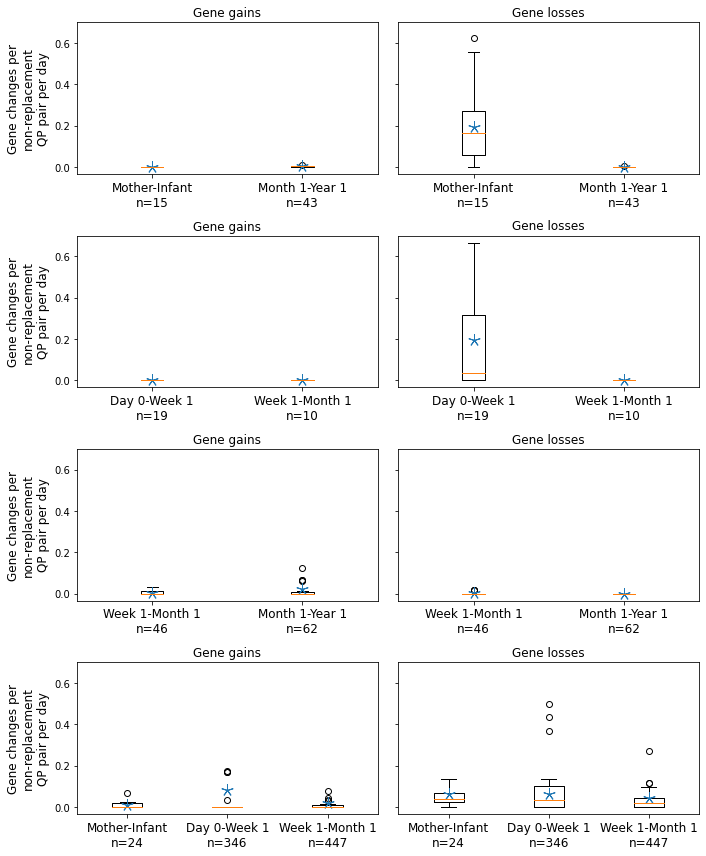

In [98]:
# Store gene change information

cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'hmp']
gain_tups_by_cohort_tp_type = {ds: defaultdict(list) for ds in cohorts}
loss_tups_by_cohort_tp_type = {ds: defaultdict(list) for ds in cohorts}
genes_gained_by_cohort_tp_type = {ds: defaultdict(set) for ds in cohorts}

# infant subject -> (species, gene) genes gained
genes_gained_m1y1 = defaultdict(list)

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        dataset = sample_cohort_map[s1]
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        # Try excluding the Mother-Infant(wk1) QP pair with unsually high number of losses
        if (num_losses >= 13) and ('Mother-Infant' in custom_cohorts):
            print("Sample pair %s, %s | %s" % (s1, s2, species))
            print("Num losses: %i | Num gains: %i" % (num_losses, num_gains))
            continue
        
        for custom_cohort in custom_cohorts:
            gain_tups_by_cohort_tp_type[dataset][custom_cohort].append((num_gains, days))
            loss_tups_by_cohort_tp_type[dataset][custom_cohort].append((num_losses, days))
            for gene, _, _, _, _ in gains:
                genes_gained_by_cohort_tp_type[dataset][custom_cohort].add((species, gene))
            
        if 'Month 1-Year 1' in custom_cohorts:
            if sample_subject_map[s1] != sample_subject_map[s2]:
                print("What??")
            infant_subject = sample_subject_map[s1]
            for gene, _, _, _, _ in gains:
                genes_gained_m1y1[infant_subject].append((species, gene))

# Gene change rates by cohort boxplot
fig, ax = plt.subplots(4, 2, figsize=(10, 12), sharey=True)

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

for i in range(4):
    
    dataset = cohorts[i]
    # Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
    bootstrapped_gain_rates_by_tp_type = bootstrapped_agg_from_list_dict(gain_tups_by_cohort_tp_type[dataset], get_rate_from_tuples, n=10)
    bootstrapped_loss_rates_by_tp_type = bootstrapped_agg_from_list_dict(loss_tups_by_cohort_tp_type[dataset], get_rate_from_tuples, n=10)
    
    gain_annotations = []; loss_annotations = [] # These are the true "average" rates per category
    gain_tp_type_labels = []; loss_tp_type_labels = [] # These are used as x-axis labels
    bootstrapped_gain_rates = []; bootstrapped_loss_rates = [] # Data
    
    for tp_type in tp_types:
        
        if len(bootstrapped_gain_rates_by_tp_type[tp_type]) > 0:
            # Store gain info
            gain_count, total_days = (0,0)
            for num_gains, days in gain_tups_by_cohort_tp_type[dataset][tp_type]:
                gain_count += num_gains; total_days += days    
            bootstrapped_gain_rates.append(bootstrapped_gain_rates_by_tp_type[tp_type])
            gain_annotations.append(float(gain_count)/total_days)
            gain_tp_type_labels.append('%s\nn=%i' % (tp_type, len(gain_tups_by_cohort_tp_type[dataset][tp_type])))
        
        if len(bootstrapped_loss_rates_by_tp_type[tp_type]) > 0:
            # Store loss info
            loss_count, total_days = (0,0)
            for num_losss, days in loss_tups_by_cohort_tp_type[dataset][tp_type]:
                loss_count += num_losss; total_days += days
            bootstrapped_loss_rates.append(bootstrapped_loss_rates_by_tp_type[tp_type])
            loss_annotations.append(float(loss_count)/total_days)
            loss_tp_type_labels.append('%s\nn=%i' % (tp_type, len(loss_tups_by_cohort_tp_type[dataset][tp_type])))
    
    ax[i][0].boxplot(bootstrapped_gain_rates)
    ax[i][0].plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12)
    ax[i][0].set_xticklabels(gain_tp_type_labels, fontsize=12)
    ax[i][0].set_ylabel("Gene changes per\nnon-replacement\nQP pair per day", fontsize=12)
    # ax[i][0].set_yscale('log')
    ax[i][0].set_title("Gene gains")

    ax[i][1].boxplot(bootstrapped_loss_rates)
    ax[i][1].plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12)
    ax[i][1].set_xticklabels(loss_tp_type_labels, fontsize=12)
    ax[i][1].set_title("Gene losses")

plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.show()

In [81]:
# Store gene change information
# Split by delivery mode

devmodes = ['Vaginal', 'C-section']

gain_tups_by_devmode_tp_type = {dm: defaultdict(list) for dm in devmodes}
subject_gain_tups_by_tp_type = defaultdict(list)
loss_tups_by_devmode_tp_type = {dm: defaultdict(list) for dm in devmodes}
subject_loss_tups_by_tp_type = defaultdict(list)
genes_gained_by_devmode_tp_type = {dm: defaultdict(set) for dm in devmodes}

restrict_cohort = [] # disabled for now

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        cohort = sample_cohort_map[s1]
        
        subject = sample_subject_map[s2]
        if subject not in subject_delivery_mode_map: # Skip non-infant second sample
            continue
        
        delivery_mode = subject_delivery_mode_map[subject]
        
        subject = sample_subject_map[s2]
        delivery_mode = subject_delivery_mode_map[subject]
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        # Try excluding the Mother-Infant(wk1) QP pair with unsually high number of losses
        if (num_losses >= 13) and ('Mother-Infant' in custom_cohorts):
            print("Sample pair %s, %s | %s" % (s1, s2, species))
            print("Num losses: %i | Num gains: %i" % (num_losses, num_gains))
            continue
        
        for custom_cohort in custom_cohorts:
            gain_tups_by_devmode_tp_type[delivery_mode][custom_cohort].append((num_gains, days))
            subject_gain_tups_by_tp_type[custom_cohort].append((subject, num_gains, days))
            loss_tups_by_devmode_tp_type[delivery_mode][custom_cohort].append((num_losses, days))
            subject_loss_tups_by_tp_type[custom_cohort].append((subject, num_losses, days))
            for gene, _, _, _, _ in gains:
                genes_gained_by_devmode_tp_type[delivery_mode][custom_cohort].add((species, gene))

Sample pair ERR3405407, ERR3405406 | Bacteroides_vulgatus_57955
Num losses: 13 | Num gains: 0


In [100]:
for dm in gain_tups_by_devmode_tp_type:
    for tp in gain_tups_by_devmode_tp_type[dm]:
        print("%i %s %s" % (len(gain_tups_by_devmode_tp_type[dm][tp]), dm, tp))

113 Vaginal 4-8mon duration infant
1003 Vaginal Infant-Infant
269 Vaginal II-1yr
734 Vaginal II-3mon
248 Vaginal Day 0-Week 1
707 Vaginal II-1mon
96 Vaginal Month 1-Year 1
153 Vaginal Mother-Infant(all)
91 Vaginal Mother-Infant(earliest)
310 Vaginal Week 1-Month 1
42 Vaginal Mother-Infant
11 Vaginal 6mon duration infant
375 C-section Infant-Infant
334 C-section II-3mon
193 C-section Week 1-Month 1
334 C-section II-1mon
117 C-section Day 0-Week 1
6 C-section Mother-Infant(all)
5 C-section Mother-Infant(earliest)
41 C-section II-1yr
9 C-section Month 1-Year 1
21 C-section 4-8mon duration infant
5 C-section 6mon duration infant
1 C-section Mother-Infant


In [58]:
tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']
for tp_type in tp_types:
    print(tp_type)
    print(len(gain_tups_by_devmode_tp_type['C-section'][tp_type]))

Mother-Infant
1
Day 0-Week 1
117
Week 1-Month 1
193
Month 1-Year 1
9
Adult-Adult
0


In [125]:
# Summarize distribution by delivery, feeding mode for gene gain rates
time_interval_category = 'Day 0-Week 1'
feeding_delivery_count_dict = {fmode: defaultdict(int) for fmode in ['breast', 'formula', 'mixed']}
for subject, count, days in subject_gain_tups_by_tp_type[time_interval_category]:
    if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
        feeding_mode = subject_feeding_mode_map[subject]
        delivery_mode = subject_delivery_mode_map[subject]
        feeding_delivery_count_dict[feeding_mode][delivery_mode] += 1

dmodes = ['Vaginal', 'C-section']
fmodes = ['breast', 'formula', 'mixed']
print("Gene gains | %s" % time_interval_category)
print('----------------------')
print('\t' + '\t'.join(dmodes))
for fmode in fmodes:
    vals = [str(feeding_delivery_count_dict[fmode][dmode]) for dmode in dmodes]
    print("%s\t" % (fmode) + '\t'.join(vals))

Gene gains | Day 0-Week 1
----------------------
	Vaginal	C-section
breast	83	29
formula	44	23
mixed	109	59


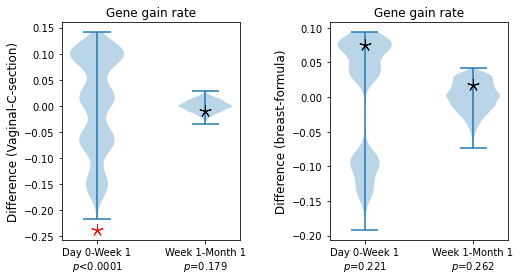

In [189]:
# Reproduce in the more elegant way heh
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']

# Vaginal vs. c-section
label_sets = [['Vaginal', 'C-section'], ['breast', 'formula']]
label_mode_type_list = [0, 1] # 0 for delivery mode, 1 for feeding mode

for i in range(2):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    
    null_differences_list = []
    true_difference_list = []
    labels = []
    color_list = []
    
    for time_interval_category in time_interval_categories:
        orig_label_subject_data_dict = defaultdict(list)
        for label in label_set:
            for subject, count, days in subject_gain_tups_by_tp_type[time_interval_category]:
                if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                    feeding_mode = subject_feeding_mode_map[subject]
                    delivery_mode = subject_delivery_mode_map[subject]
                    if label_mode_type == 0:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                    if label_mode_type == 1:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

        null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                     aggregator_fn=get_rate_from_tuples, num_bootstraps=10000)
        null_differences_list.append(null_differences)
        true_difference_list.append(true_difference)
        p = permutation_test_p(null_differences, true_difference)
        color = 'red' if p < 0.05 else 'black'
        color_list.append(color)
        labels.append('%s\n' % time_interval_category + r'$\it{p}$' + ("<0.0001" if p == 0 else "=%.03f" % p))
    
    ax[i].violinplot(null_differences_list)
    for j in range(len(true_difference_list)):
        ax[i].plot([j+1], [true_difference_list[j]], marker=(5, 2), linestyle='None', markersize=12, color=color_list[j], zorder=9)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(labels)
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    # ax[i].set_xlabel(r'$\it{p}$' + "=%.04f" % p, fontsize=12)
    ax[i].set_title("Gene gain rate")

plt.subplots_adjust(wspace=0.5)
plt.show()
fig.savefig('%s/mode_comparisons_gene_gain_rate.pdf' % config.analysis_directory)
fig.savefig('%s/mode_comparisons_gene_gain_rate.png' % config.analysis_directory, dpi=200)

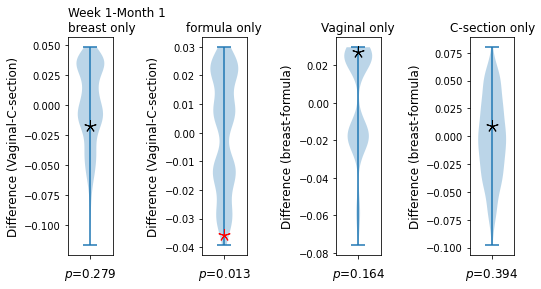

In [116]:
# Reproduce in the more elegant way heh
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 4, figsize=(8, 4))

time_interval_category = 'Week 1-Month 1'

label_sets = [['Vaginal', 'C-section'], ['Vaginal', 'C-section'], ['breast', 'formula'], ['breast', 'formula']]
label_mode_type_list = [0, 0, 1, 1] # 0 for delivery mode, 1 for feeding mode
restrict_other_mode_list = ['breast', 'formula', 'Vaginal', 'C-section']

for i in range(4):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    restrict_other_mode = restrict_other_mode_list[i]
    
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_gain_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                if label_mode_type == 0:
                    if feeding_mode == restrict_other_mode:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                if label_mode_type == 1:
                    if delivery_mode == restrict_other_mode:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))
    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, aggregator_fn=get_rate_from_tuples)
    
    p = permutation_test_p(null_differences, true_difference)
    color = 'red' if p < 0.05 else 'black'
    ax[i].violinplot(null_differences)
    ax[i].plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
    ax[i].set_xticks([1]); ax[i].set_xticklabels([]); ax[i].set_xlim((0.6, 1.4))
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    ax[i].set_xlabel(r'$\it{p}$' + "=%.03f" % p, fontsize=12)
    if i == 0:
        ax[i].set_title("%s\n%s only" % (time_interval_category, restrict_other_mode), loc='left')
    else:
        ax[i].set_title("%s only" % restrict_other_mode)

plt.subplots_adjust(wspace=2)
plt.show()

In [128]:
# Summarize distribution by delivery, feeding mode for gene loss rates
# Should be same as for gains
time_interval_category = 'Week 1-Month 1'
feeding_delivery_count_dict = {fmode: defaultdict(int) for fmode in ['breast', 'formula', 'mixed']}
for subject, count, days in subject_loss_tups_by_tp_type[time_interval_category]:
    if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
        feeding_mode = subject_feeding_mode_map[subject]
        delivery_mode = subject_delivery_mode_map[subject]
        feeding_delivery_count_dict[feeding_mode][delivery_mode] += 1

dmodes = ['Vaginal', 'C-section']
fmodes = ['breast', 'formula', 'mixed']
print("Gene loss | %s" % time_interval_category)
print('----------------------')
print('\t' + '\t'.join(dmodes))
for fmode in fmodes:
    vals = [str(feeding_delivery_count_dict[fmode][dmode]) for dmode in dmodes]
    print("%s\t" % (fmode) + '\t'.join(vals))

Gene loss | Week 1-Month 1
----------------------
	Vaginal	C-section
breast	105	31
formula	44	28
mixed	115	104


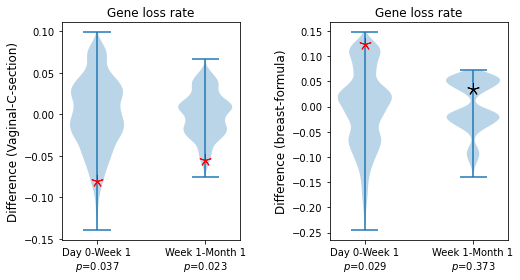

In [190]:
# Reproduce in the more elegant way heh
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']

# Vaginal vs. c-section
label_sets = [['Vaginal', 'C-section'], ['breast', 'formula']]
label_mode_type_list = [0, 1] # 0 for delivery mode, 1 for feeding mode

for i in range(2):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    
    null_differences_list = []
    true_difference_list = []
    labels = []
    color_list = []
    
    for time_interval_category in time_interval_categories:
        orig_label_subject_data_dict = defaultdict(list)
        for label in label_set:
            for subject, count, days in subject_loss_tups_by_tp_type[time_interval_category]:
                if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                    feeding_mode = subject_feeding_mode_map[subject]
                    delivery_mode = subject_delivery_mode_map[subject]
                    if label_mode_type == 0:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                    if label_mode_type == 1:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

        null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                     aggregator_fn=get_rate_from_tuples, num_bootstraps=10000)
        null_differences_list.append(null_differences)
        true_difference_list.append(true_difference)
        p = permutation_test_p(null_differences, true_difference)
        color = 'red' if p < (0.05) else 'black'
        color_list.append(color)
        labels.append('%s\n' % time_interval_category + r'$\it{p}$' + "=%.03f" % p)
    
    ax[i].violinplot(null_differences_list)
    for j in range(len(true_difference_list)):
        ax[i].plot([j+1], [true_difference_list[j]], marker=(5, 2), linestyle='None', markersize=12, color=color_list[j], zorder=9)
    ax[i].set_xticks([1, 2])
    ax[i].set_xticklabels(labels)
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    # ax[i].set_xlabel(r'$\it{p}$' + "=%.03f" % p, fontsize=12)
    ax[i].set_title("Gene loss rate")

plt.subplots_adjust(wspace=0.5)
plt.show()
fig.savefig('%s/mode_comparisons_gene_loss_rate.pdf' % config.analysis_directory)
fig.savefig('%s/mode_comparisons_gene_loss_rate.png' % config.analysis_directory, dpi=200)

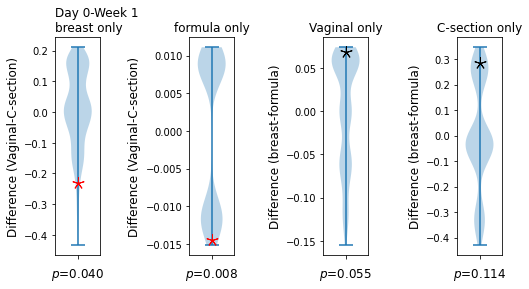

In [130]:
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 4, figsize=(8, 4))

time_interval_category = 'Day 0-Week 1'

label_sets = [['Vaginal', 'C-section'], ['Vaginal', 'C-section'], ['breast', 'formula'], ['breast', 'formula']]
label_mode_type_list = [0, 0, 1, 1] # 0 for delivery mode, 1 for feeding mode
restrict_other_mode_list = ['breast', 'formula', 'Vaginal', 'C-section']

for i in range(4):
    label_set = label_sets[i] # Which two labels we are comparing
    label_mode_type = label_mode_type_list[i]
    restrict_other_mode = restrict_other_mode_list[i]
    
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_loss_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                if label_mode_type == 0:
                    if feeding_mode == restrict_other_mode:
                        orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
                if label_mode_type == 1:
                    if delivery_mode == restrict_other_mode:
                        orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))
    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, aggregator_fn=get_rate_from_tuples)
    
    p = permutation_test_p(null_differences, true_difference)
    color = 'red' if p < 0.05 else 'black'
    ax[i].violinplot(null_differences)
    ax[i].plot([1], [true_difference], marker=(5, 2), linestyle='None', markersize=12, color=color, zorder=9)
    ax[i].set_xticks([1]); ax[i].set_xticklabels([]); ax[i].set_xlim((0.6, 1.4))
    ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
    ax[i].set_xlabel(r'$\it{p}$' + "=%.03f" % p, fontsize=12)
    if i == 0:
        ax[i].set_title("%s\n%s only" % (time_interval_category, restrict_other_mode), loc='left')
    else:
        ax[i].set_title("%s only" % restrict_other_mode)

plt.subplots_adjust(wspace=2)
plt.show()

In [105]:
i = 0
label_set = label_sets[i] # Which two labels we are comparing
label_mode_type = label_mode_type_list[i]
restrict_other_mode = restrict_other_mode_list[i]

orig_label_subject_data_dict = defaultdict(list)
for label in label_set:
    for subject, count, days in subject_gain_tups_by_tp_type[time_interval_category]:
        if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
            feeding_mode = subject_feeding_mode_map[subject]
            delivery_mode = subject_delivery_mode_map[subject]
            if label_mode_type == 0:
                if feeding_mode == restrict_other_mode:
                    orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))
            if label_mode_type == 1:
                if delivery_mode == restrict_other_mode:
                    orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

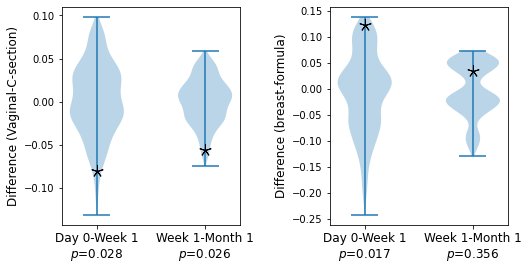

In [158]:
# Permutation tests for delivery and feeding mode

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# =====================================================================
# Delivery mode
time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']
mult_null_differences = []
mult_true_differences = []
plot_labels = []

label_set = ['Vaginal', 'C-section']

for time_interval_category in time_interval_categories:
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_loss_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                orig_label_subject_data_dict[delivery_mode].append((subject, (count, days)))

    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_rate_from_tuples)
    p = permutation_test_p(null_differences, true_difference)
    
    mult_null_differences.append(null_differences)
    mult_true_differences.append(true_difference)
    plot_labels.append(("%s\n" % time_interval_category) + r'$\it{p}$' + ("=%.03f" % (p)))

i = 0

xs = np.arange(1, 1+len(mult_true_differences))
ax[i].violinplot(mult_null_differences)
ax[i].plot(xs, mult_true_differences, marker=(5, 2), 
           linestyle='None', markersize=12, color=color, zorder=9)

ax[i].set_xticks(xs)
ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
ax[i].set_xticklabels(plot_labels, fontsize=12)
# =====================================================================

# =====================================================================
# Feeding mode
time_interval_categories = ['Day 0-Week 1', 'Week 1-Month 1']
mult_null_differences = []
mult_true_differences = []
plot_labels = []

label_set = ['breast', 'formula']

for time_interval_category in time_interval_categories:
    orig_label_subject_data_dict = defaultdict(list)
    for label in label_set:
        for subject, count, days in subject_loss_tups_by_tp_type[time_interval_category]:
            if subject in subject_delivery_mode_map and subject in subject_feeding_mode_map:
                feeding_mode = subject_feeding_mode_map[subject]
                delivery_mode = subject_delivery_mode_map[subject]
                orig_label_subject_data_dict[feeding_mode].append((subject, (count, days)))

    null_differences, true_difference = permutation_test_subject(orig_label_subject_data_dict, label_set, 
                                                                 aggregator_fn=get_rate_from_tuples)
    p = permutation_test_p(null_differences, true_difference)
    
    mult_null_differences.append(null_differences)
    mult_true_differences.append(true_difference)
    plot_labels.append(("%s\n" % time_interval_category) + r'$\it{p}$' + ("=%.03f" % (p)))

i += 1

xs = np.arange(1, 1+len(mult_true_differences))
ax[i].violinplot(mult_null_differences)
ax[i].plot(xs, mult_true_differences, marker=(5, 2), 
           linestyle='None', markersize=12, color=color, zorder=9)

ax[i].set_xticks(xs)
ax[i].set_ylabel("Difference (%s-%s)" % (label_set[0], label_set[1]), fontsize=12)
ax[i].set_xticklabels(plot_labels, fontsize=12)

plt.subplots_adjust(wspace=0.5)
plt.show()

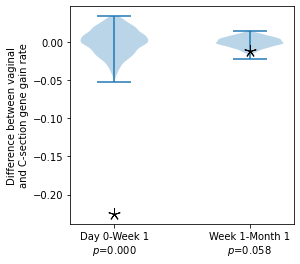

In [88]:
# Permutation test for delivery mode
# 1. permute C and V for all the babies
# 2. compute the SNV change rate for new C and new V babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between C and V

num_bootstraps = 1000
cats = ['Vaginal', 'C-section']

subjects = list(subject_delivery_mode_map.keys()) # Order matters!!
delivery_modes = [] # True/original
for subject in subjects:
    delivery_modes.append(subject_delivery_mode_map[subject])

true_gain_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in subject_gain_tups_by_tp_type:
    total_days_by_cat_dict = defaultdict(int)
    total_gain_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_gain_tups_by_tp_type[tp_type]:
        delivery_mode = subject_delivery_mode_map[subject]
        total_days_by_cat_dict[delivery_mode] += days
        total_gain_count_by_cat_dict[delivery_mode] += count
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        gain_rate = total_gain_count_by_cat_dict[cat]/days
        true_gain_rate_by_cat_tp_type_dict[cat][tp_type] = gain_rate

permuted_gain_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(delivery_modes) # Randomly permute delivery modes
    permuted_subject_delivery_mode_map = {}
    for subject, delivery_mode in zip(subjects, delivery_modes):
        permuted_subject_delivery_mode_map[subject] = delivery_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_gain_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            delivery_mode = permuted_subject_delivery_mode_map[subject]
            total_days_by_cat_dict[delivery_mode] += days
            total_gain_count_by_cat_dict[delivery_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                gain_rate = total_gain_count_by_cat_dict[cat]/days
            else:
                gain_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_gain_rates_by_cat_tp_type_dict[cat][tp_type].append(gain_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for vrate, crate in zip(permuted_gain_rates_by_cat_tp_type_dict['Vaginal'][tp_type], 
                            permuted_gain_rates_by_cat_tp_type_dict['C-section'][tp_type]):
        null_differences.append(vrate-crate)
    null_differences_by_tp_type.append(null_differences)
    true_vrate = true_gain_rate_by_cat_tp_type_dict['Vaginal'][tp_type]
    true_crate = true_gain_rate_by_cat_tp_type_dict['C-section'][tp_type]
    true_difference = true_vrate-true_crate
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between vaginal\nand C-section gene gain rate")
plt.show()
fig.savefig('%s/delivery_mode_comparison_gene_gain_rate.pdf' % config.analysis_directory)

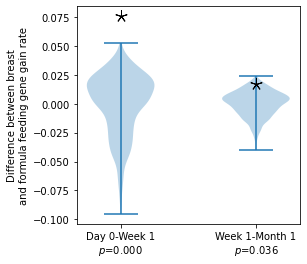

In [100]:
# Permutation test for feeding mode
# 1. permute C and V for all the babies
# 2. compute the SNV change rate for new C and new V babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between C and V

num_bootstraps = 1000
cats = ['breast', 'formula']
tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

subjects = list(subject_feeding_mode_map.keys()) # Order matters!!
feeding_modes = [] # True/original
for subject in subjects:
    feeding_modes.append(subject_feeding_mode_map[subject])

true_gain_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in tp_types:
    total_days_by_cat_dict = defaultdict(int)
    total_gain_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_gain_tups_by_tp_type[tp_type]:
        try:
            feeding_mode = subject_feeding_mode_map[subject]
        except:            
            continue # Lots of Shao samples, for example, have NA for feeding mode
        total_days_by_cat_dict[feeding_mode] += days
        total_gain_count_by_cat_dict[feeding_mode] += count
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        gain_rate = total_gain_count_by_cat_dict[cat]/days
        true_gain_rate_by_cat_tp_type_dict[cat][tp_type] = gain_rate

permuted_gain_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(feeding_modes) # Randomly permute feeding modes
    permuted_subject_feeding_mode_map = {}
    for subject, feeding_mode in zip(subjects, feeding_modes):
        permuted_subject_feeding_mode_map[subject] = feeding_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_gain_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            feeding_mode = permuted_subject_feeding_mode_map[subject]
            total_days_by_cat_dict[feeding_mode] += days
            total_gain_count_by_cat_dict[feeding_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                gain_rate = total_gain_count_by_cat_dict[cat]/days
            else:
                gain_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_gain_rates_by_cat_tp_type_dict[cat][tp_type].append(gain_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for rate1, rate2 in zip(permuted_gain_rates_by_cat_tp_type_dict['breast'][tp_type], 
                            permuted_gain_rates_by_cat_tp_type_dict['formula'][tp_type]):
        null_differences.append(rate1-rate2)
    null_differences_by_tp_type.append(null_differences)
    true_rate1 = true_gain_rate_by_cat_tp_type_dict['breast'][tp_type]
    true_rate2 = true_gain_rate_by_cat_tp_type_dict['formula'][tp_type]
    true_difference = true_rate1-true_rate2
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between breast\nand formula feeding gene gain rate")
plt.show()
fig.savefig('%s/feeding_mode_comparison_gene_gain_rate.pdf' % config.analysis_directory)

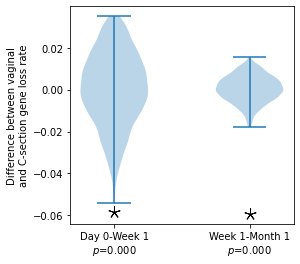

In [87]:
# Loss next
# Permutation test for delivery mode
# 1. permute C and V for all the babies
# 2. compute the SNV change rate for new C and new V babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between C and V

num_bootstraps = 1000
cats = ['Vaginal', 'C-section']

subjects = list(subject_delivery_mode_map.keys()) # Order matters!!
delivery_modes = [] # True/original
for subject in subjects:
    delivery_modes.append(subject_delivery_mode_map[subject])

true_loss_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in subject_loss_tups_by_tp_type:
    total_days_by_cat_dict = defaultdict(int)
    total_loss_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_loss_tups_by_tp_type[tp_type]:
        delivery_mode = subject_delivery_mode_map[subject]
        total_days_by_cat_dict[delivery_mode] += days
        total_loss_count_by_cat_dict[delivery_mode] += count
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        loss_rate = total_loss_count_by_cat_dict[cat]/days
        true_loss_rate_by_cat_tp_type_dict[cat][tp_type] = loss_rate

permuted_loss_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(delivery_modes) # Randomly permute delivery modes
    permuted_subject_delivery_mode_map = {}
    for subject, delivery_mode in zip(subjects, delivery_modes):
        permuted_subject_delivery_mode_map[subject] = delivery_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_loss_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            delivery_mode = permuted_subject_delivery_mode_map[subject]
            total_days_by_cat_dict[delivery_mode] += days
            total_loss_count_by_cat_dict[delivery_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                loss_rate = total_loss_count_by_cat_dict[cat]/days
            else:
                loss_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_loss_rates_by_cat_tp_type_dict[cat][tp_type].append(loss_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4, 4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for vrate, crate in zip(permuted_loss_rates_by_cat_tp_type_dict['Vaginal'][tp_type], 
                            permuted_loss_rates_by_cat_tp_type_dict['C-section'][tp_type]):
        null_differences.append(vrate-crate)
    null_differences_by_tp_type.append(null_differences)
    true_vrate = true_loss_rate_by_cat_tp_type_dict['Vaginal'][tp_type]
    true_crate = true_loss_rate_by_cat_tp_type_dict['C-section'][tp_type]
    true_difference = true_vrate-true_crate
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between vaginal\nand C-section gene loss rate")
plt.show()
fig.savefig('%s/delivery_mode_comparison_gene_loss_rate.pdf' % config.analysis_directory)

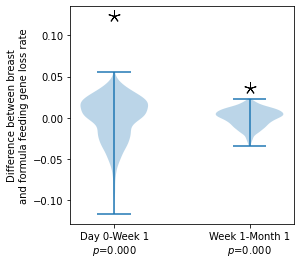

In [101]:
# Permutation test for feeding mode
# 1. permute C and V for all the babies
# 2. compute the SNV change rate for new C and new V babies;
# make sure to take the sum of the changes divided by the total time
# 3. compute difference in rate
# 4. Repeat x1000.
# 5. Compare true difference between C and V

num_bootstraps = 1000
cats = ['breast', 'formula']
tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

subjects = list(subject_feeding_mode_map.keys()) # Order matters!!
feeding_modes = [] # True/original
for subject in subjects:
    feeding_modes.append(subject_feeding_mode_map[subject])

true_loss_rate_by_cat_tp_type_dict = {cat: {} for cat in cats}

for tp_type in tp_types:
    total_days_by_cat_dict = defaultdict(int)
    total_loss_count_by_cat_dict = defaultdict(int)
    for subject, count, days in subject_loss_tups_by_tp_type[tp_type]:
        try:
            feeding_mode = subject_feeding_mode_map[subject]
        except:            
            continue # Lots of Shao samples, for example, have NA for feeding mode
        total_days_by_cat_dict[feeding_mode] += days
        total_loss_count_by_cat_dict[feeding_mode] += count
    
    for cat in cats:
        days = float(total_days_by_cat_dict[cat])
        loss_rate = total_loss_count_by_cat_dict[cat]/days
        true_loss_rate_by_cat_tp_type_dict[cat][tp_type] = loss_rate

permuted_loss_rates_by_cat_tp_type_dict = {cat: defaultdict(list) for cat in cats}

i = 0
while i < num_bootstraps:
    random.shuffle(feeding_modes) # Randomly permute feeding modes
    permuted_subject_feeding_mode_map = {}
    for subject, feeding_mode in zip(subjects, feeding_modes):
        permuted_subject_feeding_mode_map[subject] = feeding_mode
    
    bad = False # If end up with sample size 0 for any timepoint-cat pair, skip?? Not used for now
    
    # Compute SNV change rate from subject_count_time_tups_by_tp_type
    for tp_type in subject_count_time_tups_by_tp_type:
        total_days_by_cat_dict = defaultdict(int)
        total_loss_count_by_cat_dict = defaultdict(int)
        for subject, count, days in subject_count_time_tups_by_tp_type[tp_type]:
            feeding_mode = permuted_subject_feeding_mode_map[subject]
            total_days_by_cat_dict[feeding_mode] += days
            total_loss_count_by_cat_dict[feeding_mode] += count
        
        for cat in cats:
            days = float(total_days_by_cat_dict[cat])
            if days > 0:
                loss_rate = total_loss_count_by_cat_dict[cat]/days
            else:
                loss_rate = 0 # Consider it 0 if there are no samples/babies for this timepoint-cat
            permuted_loss_rates_by_cat_tp_type_dict[cat][tp_type].append(loss_rate)
    
    i += 1

# Just interested in Week 0-Month 1 and Month 1-Year

fig, ax = plt.subplots(figsize=(4,4))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

null_differences_by_tp_type = []
labels = []
true_differences_by_tp_type = []

for tp_type in tp_types:
    null_differences = []
    for rate1, rate2 in zip(permuted_loss_rates_by_cat_tp_type_dict['breast'][tp_type], 
                            permuted_loss_rates_by_cat_tp_type_dict['formula'][tp_type]):
        null_differences.append(rate1-rate2)
    null_differences_by_tp_type.append(null_differences)
    true_rate1 = true_loss_rate_by_cat_tp_type_dict['breast'][tp_type]
    true_rate2 = true_loss_rate_by_cat_tp_type_dict['formula'][tp_type]
    true_difference = true_rate1-true_rate2
    true_differences_by_tp_type.append(true_difference)
    
    p = permutation_test_p(null_differences, true_difference)
    labels.append(("%s\n" % tp_type) + r'$\it{p}$' + ("=%.03f" % (p)))

ax.violinplot(null_differences_by_tp_type, positions=[1, 2])
ax.plot(np.arange(1, 1+len(true_differences_by_tp_type)), true_differences_by_tp_type, 
        marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel("Difference between breast\nand formula feeding gene loss rate")
plt.show()
fig.savefig('%s/feeding_mode_comparison_gene_loss_rate.pdf' % config.analysis_directory)

Skipping Month 1-Year 1
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Mother-Infant(all)
Skipping Mother-Infant(earliest)
Skipping II-1yr
Skipping Month 1-Year 1
Skipping 4-8mon duration infant
Skipping 6mon duration infant
Skipping Mother-Infant
Skipping Adult-Adult
Skipping Month 1-Year 1
Skipping Mother-Infant(earliest)
Skipping Mother-Infant
Skipping 6mon duration infant
Skipping Mother-Infant(all)
Skipping Mother-Infant(earliest)
Skipping II-1yr
Skipping Month 1-Year 1
Skipping 4-8mon duration infant
Skipping 6mon duration infant
Skipping Mother-Infant


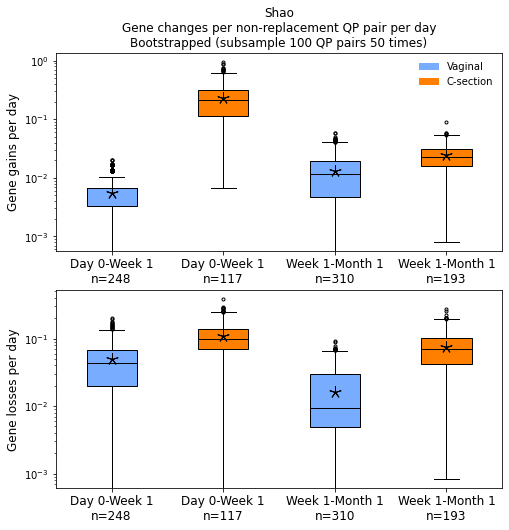

In [59]:
# Vaginal vs. C-section, gene change rates
# Uses previous x_tups_by_devmode_tp_type
# All based on 1000 bootstraps of size 100 subsample

devmodes = ['Vaginal', 'C-section']

# Subsample QP pairs in a category and bootstrap
bootstrapped_gain_rates_by_devmode_tp_type = {dm: bootstrapped_agg_from_list_dict(gain_tups_by_devmode_tp_type[dm], get_rate_from_tuples, 
                                                                                  num_bootstraps=1000, n=100) for dm in devmodes}
bootstrapped_loss_rates_by_devmode_tp_type = {dm: bootstrapped_agg_from_list_dict(loss_tups_by_devmode_tp_type[dm], get_rate_from_tuples, 
                                                                                  num_bootstraps=1000, n=100) for dm in devmodes}

# Gene gain/loss rates boxplot
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

tp_types = ['Day 0-Week 1', 'Week 1-Month 1']

bootstrapped_gain_rates = []
for tp_type in tp_types:
    for dm in devmodes:
        bootstrapped_gain_rates.append(bootstrapped_gain_rates_by_devmode_tp_type[dm][tp_type])

bootstrapped_loss_rates = []
for tp_type in tp_types:
    for dm in devmodes:
        bootstrapped_loss_rates.append(bootstrapped_loss_rates_by_devmode_tp_type[dm][tp_type])

# These are the true "average" rates per category
gain_annotations = []; loss_annotations = []
# These are used as x-axis labels
gain_tp_type_labels = []; loss_tp_type_labels = []

for tp_type in tp_types:
    for dm in devmodes:
        # Store gain info
        gain_count, total_days = (0,0)
        for num_gains, days in gain_tups_by_devmode_tp_type[dm][tp_type]:
            gain_count += num_gains; total_days += days    
        gain_annotations.append(float(gain_count)/total_days)
        gain_tp_type_labels.append('%s\nn=%i' % (tp_type, len(gain_tups_by_devmode_tp_type[dm][tp_type])))

        # Store loss info
        loss_count, total_days = (0,0)
        for num_losss, days in loss_tups_by_devmode_tp_type[dm][tp_type]:
            loss_count += num_losss; total_days += days
        loss_annotations.append(float(loss_count)/total_days)
        loss_tp_type_labels.append('%s\nn=%i' % (tp_type, len(loss_tups_by_devmode_tp_type[dm][tp_type])))

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')
boxplots = ax[0].boxplot(bootstrapped_gain_rates, patch_artist=True, medianprops=medianprops, flierprops=flierprops)
for i in np.arange(len(bootstrapped_gain_rates), step=2):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # C-section

ax[0].plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax[0].set_xticklabels(gain_tp_type_labels, fontsize=12)
ax[0].set_ylabel("Gene gains per day", fontsize=12)
ax[0].set_title("Shao\nGene changes per non-replacement QP pair per day\nBootstrapped (subsample 100 QP pairs 50 times)")
ax[0].set_yscale('log')

boxplots = ax[1].boxplot(bootstrapped_loss_rates, patch_artist=True, medianprops=medianprops, flierprops=flierprops)
for i in np.arange(len(bootstrapped_loss_rates), step=2):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # C-section

ax[1].plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax[1].set_xticklabels(loss_tp_type_labels, fontsize=12)
ax[1].set_ylabel("Gene losses per day", fontsize=12)
ax[1].set_yscale('log')

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Vaginal'), 
                   Patch(facecolor=plot_utils.col_orange, label='C-section')]
ax[0].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

In [60]:
# Store for combined plot
bootstrapped_gain_rates_devmode = bootstrapped_gain_rates
gain_annotations_devmode = gain_annotations
gain_tp_type_labels_devmode = gain_tp_type_labels

bootstrapped_loss_rates_devmode = bootstrapped_loss_rates
loss_annotations_devmode = loss_annotations
loss_tp_type_labels_devmode = loss_tp_type_labels

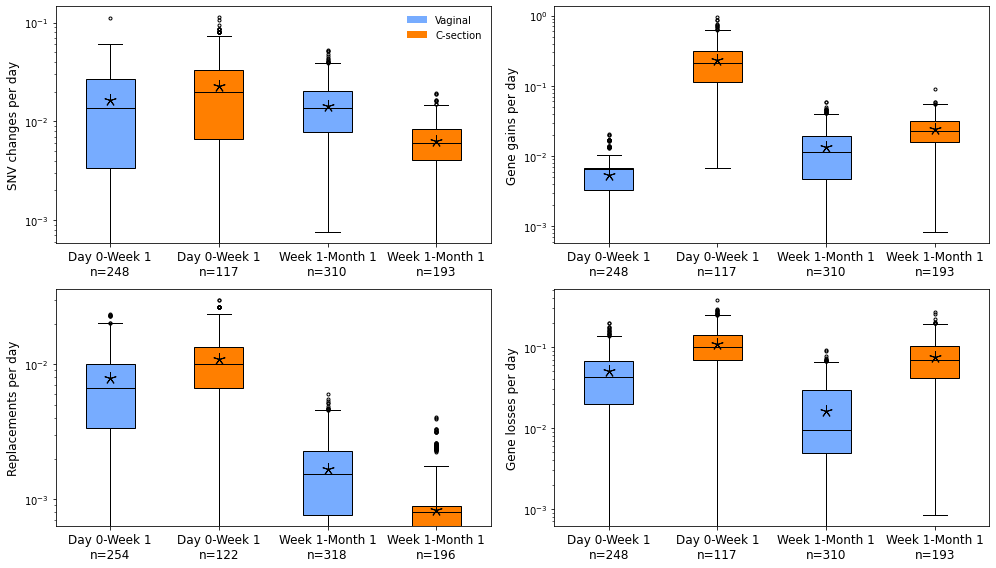

In [87]:
# POTENTIAL MAIN FIGURE
# C-section vs. vaginal for two main timepoint categories with enough data (mostly Shao)

# Vaginal vs. C-section, gene change rates
# Uses previous x_tups_by_devmode_tp_type
# All based on 1000 bootstraps of size 100 subsample

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

devmodes = ['Vaginal', 'C-section']
tp_types = ['Day 0-Week 1', 'Week 1-Month 1']
boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')

i = 0; j = 0
boxplots = ax[i][j].boxplot(snp_change_rates_devmode, patch_artist=True, medianprops=medianprops, flierprops=flierprops)
for k in np.arange(len(bootstrapped_loss_rates_devmode), step=2):
    boxplots['boxes'][k].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][k+1].set_facecolor(plot_utils.col_orange) # C-section

ax[i][j].plot(np.arange(1, 1+len(snp_change_rate_annotations_devmode)), 
              snp_change_rate_annotations_devmode, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax[i][j].set_xticklabels(snp_change_rate_tp_type_labels_devmode, fontsize=12)
ax[i][j].set_ylabel("SNV changes per day", fontsize=12)
ax[i][j].set_yscale('log')

i = 1; j = 0
boxplots = ax[i][j].boxplot(replacement_rates_devmode, patch_artist=True, medianprops=medianprops, flierprops=flierprops)
for k in np.arange(len(bootstrapped_loss_rates_devmode), step=2):
    boxplots['boxes'][k].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][k+1].set_facecolor(plot_utils.col_orange) # C-section

ax[i][j].plot(np.arange(1, 1+len(replacement_rate_annotations_devmode)), 
              replacement_rate_annotations_devmode, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax[i][j].set_xticklabels(replacement_rate_tp_type_labels_devmode, fontsize=12)
ax[i][j].set_ylabel("Replacements per day", fontsize=12)
ax[i][j].set_yscale('log')

i = 0; j = 1
boxplots = ax[i][j].boxplot(bootstrapped_gain_rates_devmode, patch_artist=True, medianprops=medianprops, flierprops=flierprops)
for k in np.arange(len(bootstrapped_loss_rates_devmode), step=2):
    boxplots['boxes'][k].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][k+1].set_facecolor(plot_utils.col_orange) # C-section

ax[i][j].plot(np.arange(1, 1+len(gain_annotations_devmode)), gain_annotations_devmode, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax[i][j].set_xticklabels(gain_tp_type_labels_devmode, fontsize=12)
ax[i][j].set_ylabel("Gene gains per day", fontsize=12)
ax[i][j].set_yscale('log')

i = 1; j = 1
boxplots = ax[i][j].boxplot(bootstrapped_loss_rates_devmode, patch_artist=True, medianprops=medianprops, flierprops=flierprops)
for k in np.arange(len(bootstrapped_loss_rates_devmode), step=2):
    boxplots['boxes'][k].set_facecolor(plot_utils.col_blue) # Vaginal
    boxplots['boxes'][k+1].set_facecolor(plot_utils.col_orange) # C-section

ax[i][j].plot(np.arange(1, 1+len(loss_annotations_devmode)), loss_annotations_devmode, marker=(5, 2), linestyle='None', markersize=12, color='black', zorder=9)
ax[i][j].set_xticklabels(loss_tp_type_labels_devmode, fontsize=12)
ax[i][j].set_ylabel("Gene losses per day", fontsize=12)
ax[i][j].set_yscale('log')

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Vaginal'), 
                   Patch(facecolor=plot_utils.col_orange, label='C-section')]
ax[0][0].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

fig.savefig('%s/SX_temporal_change_rates_vaginal_vs_csection.pdf' % plot_dir, bbox_inches='tight')

In [73]:
def get_confidence_interval(a, percent):
    lower = np.percentile(a, ((100-percent)/2.0))
    upper = np.percentile(a, (100-((100-percent)/2.0)))
    return (lower, upper)

In [86]:
def get_confidence_interval(a, r):
    half = r*scipy.stats.sem(a)
    avg = np.mean(a)
    lower = avg-half
    upper = avg+half
    return (lower, upper)

(0.015581755332394413, 0.017302297732185057)
(0.021974200666664535, 0.024399132666668794)
(0.014136237955286712, 0.015218292603074555)
(0.006143043197693018, 0.006528699225726437)


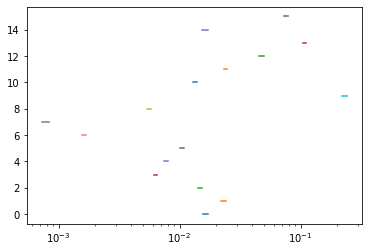

In [85]:
fig, ax = plt.subplots()

i = 0
for a in snp_change_rates_devmode:
    ax.plot(get_confidence_interval(a, 1.96), [i, i], '-')
    print(get_confidence_interval(a, 1.96))
    i += 1

for a in replacement_rates_devmode:
    ax.plot(get_confidence_interval(a, 1.96), [i, i], '-')
    i += 1

for a in bootstrapped_gain_rates_devmode:
    ax.plot(get_confidence_interval(a, 1.96), [i, i], '-')
    i += 1

for a in bootstrapped_loss_rates_devmode:
    ax.plot(get_confidence_interval(a, 1.96), [i, i], '-')
    i += 1

ax.set_xscale('log')
plt.show()

In [70]:
print("\nSNV change rate")
summarize_ttest(snp_change_rates_devmode[0], snp_change_rates_devmode[1])
print()
summarize_ttest(snp_change_rates_devmode[2], snp_change_rates_devmode[3])
print("\nReplacement rate")
summarize_ttest(replacement_rates_devmode[0], replacement_rates_devmode[1])
print()
summarize_ttest(replacement_rates_devmode[2], replacement_rates_devmode[3])
print("\nGene gain rate")
summarize_ttest(bootstrapped_gain_rates_devmode[0], bootstrapped_gain_rates_devmode[1])
print()
summarize_ttest(bootstrapped_gain_rates_devmode[2], bootstrapped_gain_rates_devmode[3])
print("\nGene loss rate")
summarize_ttest(bootstrapped_loss_rates_devmode[0], bootstrapped_loss_rates_devmode[1])
print()
summarize_ttest(bootstrapped_loss_rates_devmode[2], bootstrapped_loss_rates_devmode[3])


SNV change rate
Group 1 size: 1000 | Group 2 size: 1000
T-statistic: -8.8921
P-value: 1.3099742940863362e-18
Cohen's D: -0.397667341634112

Group 1 size: 1000 | Group 2 size: 1000
T-statistic: 28.4648
P-value: 6.751233416417725e-150
Cohen's D: 1.2729842218383314

Replacement rate
Group 1 size: 1000 | Group 2 size: 1000
T-statistic: -11.8362
P-value: 2.7420483920389014e-31
Cohen's D: -0.5293315116533924

Group 1 size: 1000 | Group 2 size: 1000
T-statistic: 19.8549
P-value: 3.2731490761186528e-80
Cohen's D: 0.8879391620903485

Gene gain rate
Group 1 size: 1000 | Group 2 size: 1000
T-statistic: -49.0836
P-value: 0.0
Cohen's D: -2.195086485666468

Group 1 size: 1000 | Group 2 size: 1000
T-statistic: -21.9056
P-value: 1.6595177006768496e-95
Cohen's D: -0.9796494390091058

Gene loss rate
Group 1 size: 1000 | Group 2 size: 1000
T-statistic: -29.1512
P-value: 5.689693664845243e-156
Cohen's D: -1.3036795286729903

Group 1 size: 1000 | Group 2 size: 1000
T-statistic: -40.5514
P-value: 7.7688141

(-40.55144000088083, 7.768814111032032e-263, -1.8135155285494733)

In [25]:
# Store gene change information
# Split by feeding mode

gain_tups_by_cat_tp_type = {dm: defaultdict(list) for dm in cats}
loss_tups_by_cat_tp_type = {dm: defaultdict(list) for dm in cats}
genes_gained_by_cat_tp_type = {dm: defaultdict(set) for dm in cats}

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        subject = sample_subject_map[s2]
        if subject not in subject_feeding_mode_map: # Skip non-infant second sample
            continue
        
        feeding_mode = subject_feeding_mode_map[subject]
        
        subject = sample_subject_map[s2]
        feeding_mode = subject_feeding_mode_map[subject]
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        # Try excluding the Mother-Infant(wk1) QP pair with unsually high number of losses
        if (num_losses >= 13) and ('Mother-Infant' in custom_cohorts):
            print("Sample pair %s, %s | %s" % (s1, s2, species))
            print("Num losses: %i | Num gains: %i" % (num_losses, num_gains))
            continue
        
        for custom_cohort in custom_cohorts:
            gain_tups_by_cat_tp_type[feeding_mode][custom_cohort].append((num_gains, days))
            loss_tups_by_cat_tp_type[feeding_mode][custom_cohort].append((num_losses, days))
            for gene, _, _, _, _ in gains:
                genes_gained_by_cat_tp_type[feeding_mode][custom_cohort].add((species, gene))

Sample pair ERR3405407, ERR3405406 | Bacteroides_vulgatus_57955
Num losses: 13 | Num gains: 0


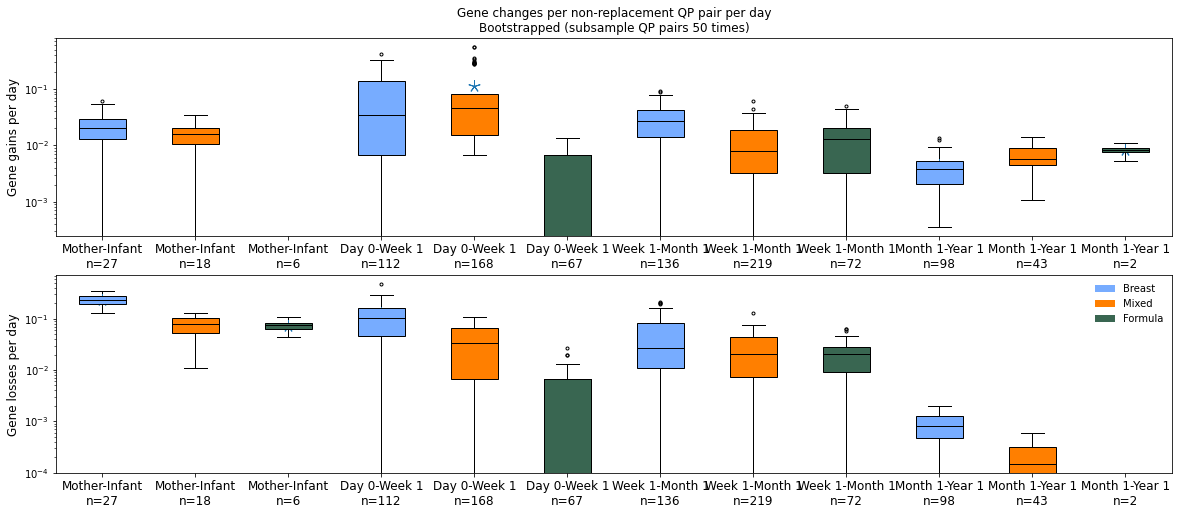

In [30]:
cats = ['breast', 'mixed', 'formula']

# Subsample QP pairs in a category to n=50 and get #sweeps/day, bootstrap 20 times
bootstrapped_gain_rates_by_cat_tp_type = {cat: bootstrapped_agg_from_list_dict(gain_tups_by_cat_tp_type[cat], get_rate_from_tuples) for cat in cats}
bootstrapped_loss_rates_by_cat_tp_type = {cat: bootstrapped_agg_from_list_dict(loss_tups_by_cat_tp_type[cat], get_rate_from_tuples) for cat in cats}

# Gene gain/loss rates boxplot
fig, ax = plt.subplots(2, 1, figsize=(20, 8))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1']

bootstrapped_gain_rates = []
for tp_type in tp_types:
    for cat in cats:
        bootstrapped_gain_rates.append(bootstrapped_gain_rates_by_cat_tp_type[cat][tp_type])

bootstrapped_loss_rates = []
for tp_type in tp_types:
    for cat in cats:
        bootstrapped_loss_rates.append(bootstrapped_loss_rates_by_cat_tp_type[cat][tp_type])

# These are the true "average" rates per category
gain_annotations = []; loss_annotations = []
# These are used as x-axis labels
gain_tp_type_labels = []; loss_tp_type_labels = []

for tp_type in tp_types:
    for cat in cats:
        # Store gain info
        gain_count, total_days = (0,0)
        for num_gains, days in gain_tups_by_cat_tp_type[cat][tp_type]:
            gain_count += num_gains; total_days += days    
        gain_annotations.append(float(gain_count)/total_days)
        gain_tp_type_labels.append('%s\nn=%i' % (tp_type, len(gain_tups_by_cat_tp_type[cat][tp_type])))

        # Store loss info
        loss_count, total_days = (0,0)
        for num_losss, days in loss_tups_by_cat_tp_type[cat][tp_type]:
            loss_count += num_losss; total_days += days
        loss_annotations.append(float(loss_count)/total_days)
        loss_tp_type_labels.append('%s\nn=%i' % (tp_type, len(loss_tups_by_cat_tp_type[cat][tp_type])))

boxprops = dict(color='#77acff'); medianprops = dict(color='black'); flierprops = dict(marker='.')

boxplots = ax[0].boxplot(bootstrapped_gain_rates, patch_artist=True, 
                         medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(gain_annotations), step=3):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Breast
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # Mixed
    boxplots['boxes'][i+2].set_facecolor(plot_utils.col_darkgreen) # Formula

ax[0].plot(np.arange(1, 1+len(gain_annotations)), gain_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[0].set_xticklabels(gain_tp_type_labels, fontsize=12)
ax[0].set_ylabel("Gene gains per day", fontsize=12)
ax[0].set_title("Gene changes per non-replacement QP pair per day\nBootstrapped (subsample QP pairs 50 times)")
ax[0].set_yscale('log')

boxplots = ax[1].boxplot(bootstrapped_loss_rates, patch_artist=True, 
                         medianprops=medianprops, flierprops=flierprops)

for i in np.arange(len(loss_annotations), step=3):
    boxplots['boxes'][i].set_facecolor(plot_utils.col_blue) # Breast
    boxplots['boxes'][i+1].set_facecolor(plot_utils.col_orange) # Mixed
    boxplots['boxes'][i+2].set_facecolor(plot_utils.col_darkgreen) # Formula

ax[1].plot(np.arange(1, 1+len(loss_annotations)), loss_annotations, marker=(5, 2), linestyle='None', markersize=12)
ax[1].set_xticklabels(loss_tp_type_labels, fontsize=12)
ax[1].set_ylabel("Gene losses per day", fontsize=12)
ax[1].set_yscale('log')

legend_elements = [Patch(facecolor=plot_utils.col_blue, label='Breast'), 
                   Patch(facecolor=plot_utils.col_orange, label='Mixed'),
                   Patch(facecolor=plot_utils.col_darkgreen, label='Formula')]
ax[1].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.show()

In [40]:
# quick overview of delivery mode info

cohort_devmode_dict = {cohort: {dm: 0 for dm in devmodes} for cohort in cohorts}

for sample in infant_samples:
    cohort = sample_cohort_map[sample]
    devmode = subject_delivery_mode_map[sample_subject_map[sample]]
    cohort_devmode_dict[cohort][devmode] += 1

cohort_devmode_dict

{'backhed': {'Vaginal': 248, 'C-section': 45},
 'ferretti': {'Vaginal': 98, 'C-section': 0},
 'yassour': {'Vaginal': 144, 'C-section': 26},
 'shao': {'Vaginal': 766, 'C-section': 735},
 'hmp': {'Vaginal': 0, 'C-section': 0}}

SNV change rate, infant vs adult
Group 1 size: 50 | Group 2 size: 50
U-statistic: 2383.0000
P-value: 5.781138607058978e-15
Effect size: 0.7808633397657665

Group 1 size: 50 | Group 2 size: 50
T-statistic: 11.7498
P-value: 2.0457085635875477e-20
Cohen's D: 2.349960118742019

Replacement rate, infant vs adult
Group 1 size: 50 | Group 2 size: 50
U-statistic: 2499.0000
P-value: 4.068648956978694e-18
Effect size: 0.8676854555094827

Group 1 size: 50 | Group 2 size: 50
T-statistic: 23.6285
P-value: 2.9614386448544264e-42
Cohen's D: 4.7256920938870435

Gene gain rate, infant vs adult
Group 1 size: 50 | Group 2 size: 50
U-statistic: 2315.0000
P-value: 1.9707431901320482e-13
Effect size: 0.735076589747217

Group 1 size: 50 | Group 2 size: 50
T-statistic: 4.7592
P-value: 6.706496306418466e-06
Cohen's D: 0.951848057076502

Gene loss rate, infant vs adult
Group 1 size: 50 | Group 2 size: 50
U-statistic: 2342.0000
P-value: 4.987460038260105e-14
Effect size: 0.7532246733115271

Group 1 size: 50 | Gr

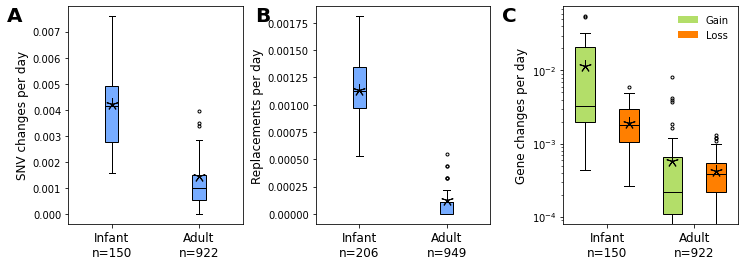

In [42]:
# Combined matched plot
# SUPPLEMENTAL FIGURE
# OLD version with 50 bootstraps

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon\nInfant', '4-8mon\nAdult']

# ====================
# SNP CHANGES
# ====================

boxplots_0 = ax[0].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[0].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[0].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in snp_change_rate_tp_type_labels], fontsize=12)
ax[0].set_ylabel("SNV changes per day", fontsize=12)
ax[0].text(-0.35, 0.93, 'A', size=20, transform=ax[0].transAxes, weight='bold')

print("SNV change rate, infant vs adult")
summarize_utest(snp_change_rates[0], snp_change_rates[1]); print()
summarize_ttest(snp_change_rates[0], snp_change_rates[1]); print()

# ====================
# Replacements
# ====================

boxplots_1 = ax[1].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[1].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in replacement_rate_tp_type_labels], fontsize=12)
ax[1].set_ylabel("Replacements per day", fontsize=12)
ax[1].text(-0.35, 0.93, 'B', size=20, transform=ax[1].transAxes, weight='bold')

print("Replacement rate, infant vs adult")
summarize_utest(replacement_rates[0], replacement_rates[1]); print()
summarize_ttest(replacement_rates[0], replacement_rates[1]); print()

# ====================
# Gene gain/loss
# ====================
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_2 = ax[2].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_2['boxes'][i+1].set_facecolor('#ff7f00') # loss

print("Gene gain rate, infant vs adult")
summarize_utest(bootstrapped_all_gene_change_rates[0], bootstrapped_all_gene_change_rates[2]); print()
summarize_ttest(bootstrapped_all_gene_change_rates[0], bootstrapped_all_gene_change_rates[2]); print()

print("Gene loss rate, infant vs adult")
summarize_utest(bootstrapped_all_gene_change_rates[1], bootstrapped_all_gene_change_rates[3]); print()
summarize_ttest(bootstrapped_all_gene_change_rates[1], bootstrapped_all_gene_change_rates[3]); print()

ax[2].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[2].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[2].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in gain_tp_type_labels], fontsize=12)
ax[2].set_ylabel("Gene changes per day", fontsize=12)
ax[2].set_yscale('log')
ax[2].text(-0.35, 0.93, 'C', size=20, transform=ax[2].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[2].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=0.42)
plt.show()

fig.savefig('%s/S8_snv_gene_change_replacement_matched_infant_adult_compare.pdf' % plot_dir, bbox_inches='tight')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


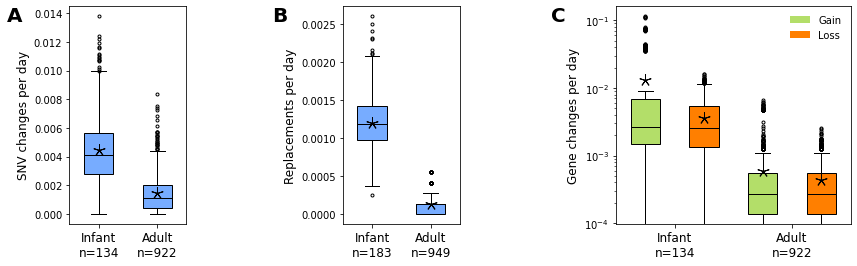

In [55]:
# Combined matched plot
# SUPPLEMENTAL FIGURE
# Updated VERSION with 1000 bootstraps
# Also add tests (MWU) ok scratched

fig, ax = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [1, 1, 2]})

tp_types = ['4-8mon duration infant', '4-8mon duration adult']
labels = ['4-8mon\nInfant', '4-8mon\nAdult']

# ====================
# SNP CHANGES
# ====================

boxplots_0 = ax[0].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'), widths=0.5)

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[0].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[0].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in snp_change_rate_tp_type_labels], fontsize=12)
ax[0].set_ylabel("SNV changes per day", fontsize=12)
# ax[0].set_yscale('log')
ax[0].text(-0.53, 0.93, 'A', size=20, transform=ax[0].transAxes, weight='bold')
'''
print("SNV change rate, infant vs adult")
U, p, es = summarize_utest(snp_change_rates[0], snp_change_rates[1]); print()
summarize_ttest(snp_change_rates[0], snp_change_rates[1]); print()

i1, i2 = (0, 1); j = 0.02
color = 'red' if p < 0.05 else 'gray'; offset = 0.36 if p < 0.01 else 0.23
plot_interval_on_ax(ax[0], j, i1+1, i2+1, color=color, tickh=0.0008); label = '{:.1e}'.format(p) if p < 0.01 else ('%.03f' % p)
ax[0].text(i1+1+((i2-i1)/2)-offset, j+0.0005, label, color=color)
'''
# ====================
# Replacements
# ====================

boxplots_1 = ax[1].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'), widths=0.5)

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[1].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in replacement_rate_tp_type_labels], fontsize=12)
ax[1].set_ylabel("Replacements per day", fontsize=12)
# ax[1].set_yscale('log')
ax[1].text(-0.6, 0.93, 'B', size=20, transform=ax[1].transAxes, weight='bold')
'''
print("Replacement rate, infant vs adult")
U, p, es = summarize_utest(replacement_rates[0], replacement_rates[1]); print()
summarize_ttest(replacement_rates[0], replacement_rates[1]); print()

i1, i2 = (0, 1); j = 0.0025
color = 'red' if p < 0.05 else 'gray'; offset = 0.36 if p < 0.01 else 0.23
plot_interval_on_ax(ax[1], j, i1+1, i2+1, color=color, tickh=0.0001); label = '{:.1e}'.format(p) if p < 0.01 else ('%.03f' % p)
ax[1].text(i1+1+((i2-i1)/2)-offset, j+0.0001, label, color=color)
'''
# ====================
# Gene gain/loss
# ====================
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_2 = ax[2].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'), widths=0.5)

for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_2['boxes'][i+1].set_facecolor('#ff7f00') # loss
'''
print("Gene gain rate, infant vs adult")
U, p, es = summarize_utest(bootstrapped_all_gene_change_rates[0], bootstrapped_all_gene_change_rates[2]); print()
summarize_ttest(bootstrapped_all_gene_change_rates[0], bootstrapped_all_gene_change_rates[2]); print()

i1, i2 = (0, 1); j = 0.2
color = 'red' if p < 0.05 else 'gray'; offset = 0.36 if p < 0.01 else 0.23
plot_interval_on_ax(ax[2], j, i1+1, i2+1, color=color, tickh=0.02); label = '{:.1e}'.format(p) if p < 0.01 else ('%.03f' % p)
ax[2].text(i1+1+((i2-i1)/2)-offset, j+0.04, label, color=color)

print("Gene loss rate, infant vs adult")
U, p, es = summarize_utest(bootstrapped_all_gene_change_rates[1], bootstrapped_all_gene_change_rates[3]); print()
summarize_ttest(bootstrapped_all_gene_change_rates[1], bootstrapped_all_gene_change_rates[3]); print()

i1, i2 = (2, 3); j = 0.02
color = 'red' if p < 0.05 else 'gray'; offset = 0.36 if p < 0.01 else 0.23
plot_interval_on_ax(ax[2], j, i1+1, i2+1, color=color, tickh=0.001); label = '{:.1e}'.format(p) if p < 0.01 else ('%.03f' % p)
ax[2].text(i1+1+((i2-i1)/2)-offset, j+0.005, label, color=color)
'''
ax[2].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=12)
ax[2].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[2].set_xticklabels(['\n'.join(label.split('\n')[1:]) for label in gain_tp_type_labels], fontsize=12)
ax[2].set_ylabel("Gene changes per day", fontsize=12)
ax[2].set_yscale('log')
ax[2].text(-0.28, 0.93, 'C', size=20, transform=ax[2].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[2].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=1) # Will do final formatting later
plt.show()

fig.savefig('%s/S8_snv_gene_change_replacement_matched_infant_adult_compare.pdf' % plot_dir, bbox_inches='tight')

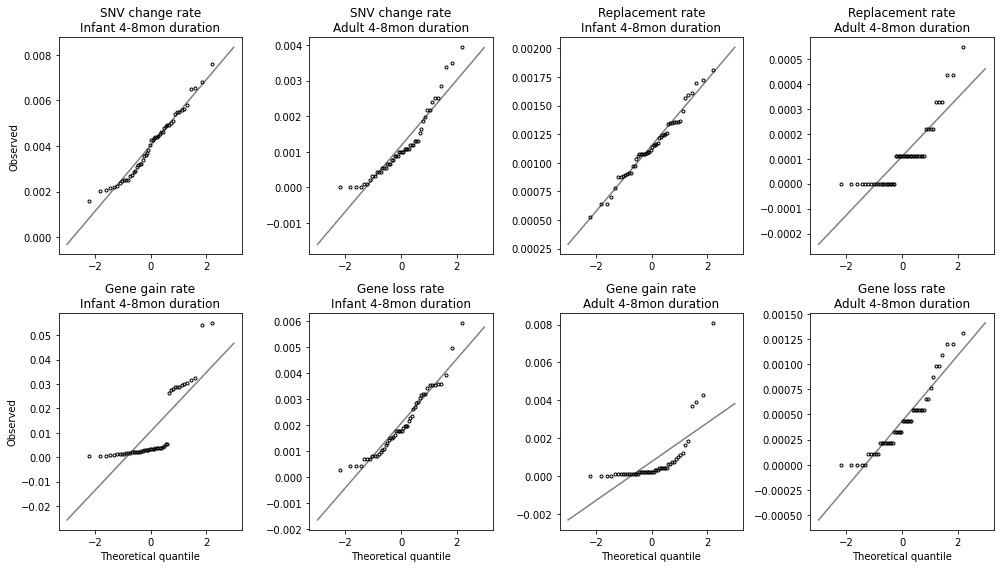

In [41]:
# QQ plots
from scipy import stats

fig, ax = plt.subplots(2, 4, figsize=(14, 8))
xs = np.arange(-3, 3, 0.01)

vals = stats.probplot(snp_change_rates[0]); ax[0][0].set_title('SNV change rate\nInfant 4-8mon duration')
osm, osr = vals[0]; m, b, r = vals[1]
ax[0][0].plot(xs, (m*xs)+b, color='gray'); ax[0][0].plot(osm, osr, '.', color='black', mfc='none')

vals = stats.probplot(snp_change_rates[1]); ax[0][1].set_title('SNV change rate\nAdult 4-8mon duration')
osm, osr = vals[0]; m, b, r = vals[1]
ax[0][1].plot(xs, (m*xs)+b, color='gray'); ax[0][1].plot(osm, osr, '.', color='black', mfc='none')

vals = stats.probplot(replacement_rates[0]); ax[0][2].set_title('Replacement rate\nInfant 4-8mon duration')
osm, osr = vals[0]; m, b, r = vals[1]
ax[0][2].plot(xs, (m*xs)+b, color='gray'); ax[0][2].plot(osm, osr, '.', color='black', mfc='none')

vals = stats.probplot(replacement_rates[1]); ax[0][3].set_title('Replacement rate\nAdult 4-8mon duration')
osm, osr = vals[0]; m, b, r = vals[1]
ax[0][3].plot(xs, (m*xs)+b, color='gray'); ax[0][3].plot(osm, osr, '.', color='black', mfc='none')

labels = ['Gene gain rate\nInfant 4-8mon duration', 'Gene loss rate\nInfant 4-8mon duration',
         'Gene gain rate\nAdult 4-8mon duration', 'Gene loss rate\nAdult 4-8mon duration']
for i, label in zip(range(len(bootstrapped_all_gene_change_rates)), labels):
    vals = stats.probplot(bootstrapped_all_gene_change_rates[i])
    ax[1][i].set_title(label)
    osm, osr = vals[0]; m, b, r = vals[1]
    ax[1][i].plot(xs, (m*xs)+b, color='gray')
    ax[1][i].plot(osm, osr, '.', color='black', mfc='none')
    ax[1][i].set_xlabel("Theoretical quantile")

ax[0][0].set_ylabel("Observed")
ax[1][0].set_ylabel("Observed")

plt.tight_layout()
fig.savefig('%s/SX_rates_4-8mon_qq_plots.pdf' % plot_dir, bbox_inches='tight')

In [27]:
# Get t test statistics
t, p = stats.ttest_ind(snp_change_rates[0], snp_change_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(replacement_rates[0], replacement_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(bootstrapped_gain_rates[0], bootstrapped_gain_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

t, p = stats.ttest_ind(bootstrapped_loss_rates[0], bootstrapped_loss_rates[1])
print("T: %.02f\tp: %.3E" % (t, p))

T: 14.18	p: 1.760E-25
T: 10.45	p: 1.257E-17
T: -4.36	p: 3.173E-05
T: 5.96	p: 3.954E-08


In [28]:
# Get Wilcoxon rank sum test statistics (two-sided is default)
U, p = stats.mannwhitneyu(snp_change_rates[0], snp_change_rates[1])
print("U: %.02f\tp: %.3E" % (U, p))

U, p = stats.mannwhitneyu(replacement_rates[0], replacement_rates[1])
print("U: %.02f\tp: %.3E" % (U, p))

U, p = stats.mannwhitneyu(bootstrapped_gain_rates[0], bootstrapped_gain_rates[1])
print("U: %.02f\tp: %.3E" % (U, p))

U, p = stats.mannwhitneyu(bootstrapped_loss_rates[0], bootstrapped_loss_rates[1])
print("U: %.02f\tp: %.3E" % (U, p))

U: 2470.00	p: 2.544E-17
U: 2393.00	p: 3.230E-15
U: 873.00	p: 9.285E-03
U: 2049.00	p: 3.689E-08


In [29]:
# Get statistics for paper
for tp_type, gain_val, loss_val in zip(tp_types, gain_annotations, loss_annotations):
    print(tp_type)
    print('Avg gain rate: %.3E \t Avg loss rate: %.3E' % (gain_val, loss_val))

Mother-Infant
Avg gain rate: 1.333E-02 	 Avg loss rate: 1.133E-01
Day 0-Week 1
Avg gain rate: 7.798E-02 	 Avg loss rate: 6.881E-02
Week 1-Month 1
Avg gain rate: 1.739E-02 	 Avg loss rate: 3.819E-02
Month 1-Year 1
Avg gain rate: 4.934E-03 	 Avg loss rate: 7.378E-04
Adult-Adult
Avg gain rate: 5.506E-04 	 Avg loss rate: 4.000E-04


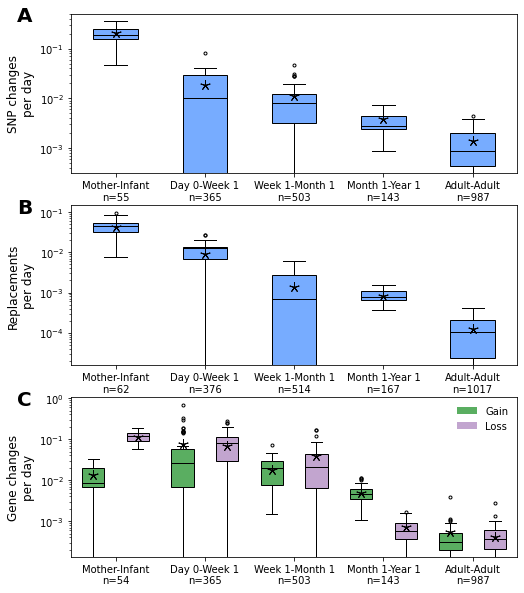

In [26]:
# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(3, 1, figsize=(8, 10))

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

boxplots_0 = ax[0].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[0].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[0].set_xticklabels(snp_change_rate_tp_type_labels)
ax[0].set_ylabel("SNP changes\nper day", fontsize=12)
# ax[0].set_title("SNP changes per non-replacement QP pair per day")
ax[0].set_yscale('log')
ax[0].text(-0.12, 0.95, 'A', size=20, transform=ax[0].transAxes, weight='bold')

boxplots_1 = ax[1].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[1].set_xticklabels(replacement_rate_tp_type_labels)
ax[1].set_ylabel("Replacements\nper day", fontsize=12)
# ax[1].set_title("Replacements per QP pair per day")
ax[1].set_yscale('log')
ax[1].text(-0.12, 0.95, 'B', size=20, transform=ax[1].transAxes, weight='bold')
    
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_2 = ax[2].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor(plot_utils.col_gain) # gain
    boxplots_2['boxes'][i+1].set_facecolor(plot_utils.col_loss) # loss

ax[2].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[2].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[2].set_xticklabels(gain_tp_type_labels)
ax[2].set_ylabel("Gene changes\nper day", fontsize=12)
# ax[2].set_title("Gene changes per non-replacement QP pair per day")
ax[2].set_yscale('log')
ax[2].text(-0.12, 0.95, 'C', size=20, transform=ax[2].transAxes, weight='bold')

legend_elements = [Patch(facecolor=plot_utils.col_gain, label='Gain'), Patch(facecolor=plot_utils.col_loss, label='Loss')]

ax[2].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

fig.savefig('%s/figure_3_v1.png' % plot_dir, bbox_inches='tight', dpi=600)

In [29]:
print(snp_change_rates[2])
# print(replacement_rates[1])
# print(bootstrapped_all_gene_change_rates[1])

[0.007451564828614009, 0.00782472613458529, 0.0051813471502590676, 0.0, 0.023154848046309694, 0.0029985007496251873, 0.0109375, 0.0, 0.001557632398753894, 0.0327613104524181, 0.0, 0.006622516556291391, 0.011608623548922056, 0.0074962518740629685, 0.0, 0.009174311926605505, 0.009554140127388535, 0.03731343283582089, 0.0, 0.0028530670470756064, 0.011412268188302425, 0.03672787979966611, 0.010819165378670788, 0.0014992503748125937, 0.008708272859216255, 0.028846153846153848, 0.020527859237536656, 0.0045045045045045045, 0.0029850746268656717, 0.0121765601217656, 0.007849293563579277, 0.023880597014925373, 0.004792332268370607, 0.0044444444444444444, 0.012441679626749611, 0.00778816199376947, 0.00463678516228748, 0.005067567567567568, 0.011254019292604502, 0.004524886877828055, 0.007363770250368188, 0.0064516129032258064, 0.006578947368421052, 0.03225806451612903, 0.009836065573770493, 0.02748091603053435, 0.006299212598425197, 0.01757188498402556, 0.016058394160583942, 0.004958677685950413

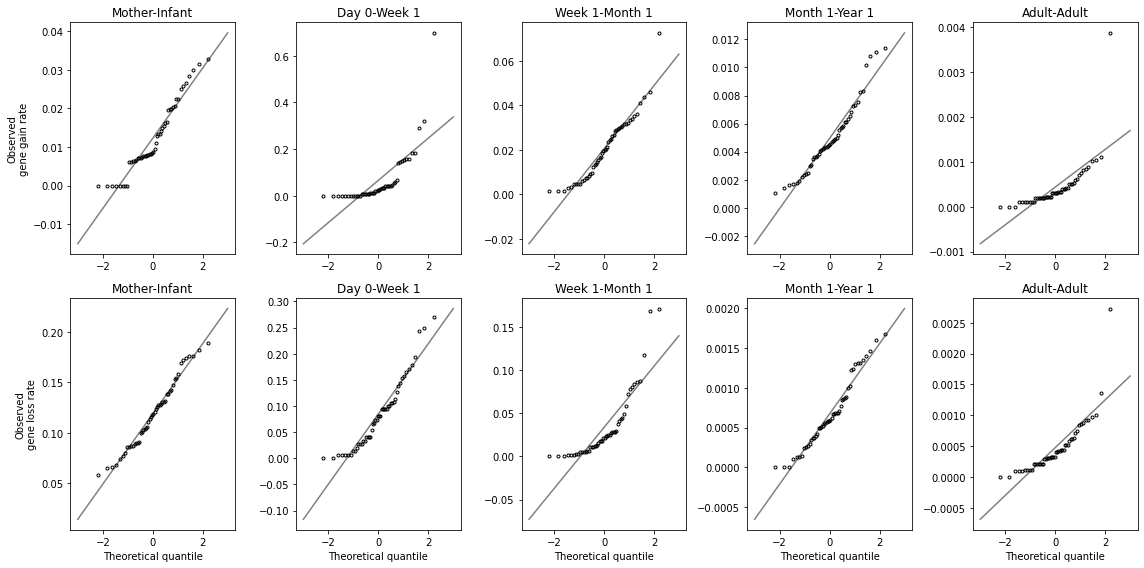

In [28]:
# QQ plots
from scipy import stats

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
xs = np.arange(-3, 3, 0.01)

for i, tp_type in zip(range(len(bootstrapped_gain_rates)), tp_types):
    vals = stats.probplot(bootstrapped_gain_rates[i])
    ax[0][i].set_title(tp_type)
    osm, osr = vals[0]; m, b, r = vals[1]
    ax[0][i].plot(xs, (m*xs)+b, color='gray')
    ax[0][i].plot(osm, osr, '.', color='black', mfc='none')

for i, tp_type in zip(range(len(bootstrapped_loss_rates)), tp_types):
    vals = stats.probplot(bootstrapped_loss_rates[i])
    ax[1][i].set_title(tp_type)
    osm, osr = vals[0]; m, b, r = vals[1]
    ax[1][i].plot(xs, (m*xs)+b, color='gray')
    ax[1][i].plot(osm, osr, '.', color='black', mfc='none')
    ax[1][i].set_xlabel("Theoretical quantile")

ax[0][0].set_ylabel("Observed\ngene gain rate")
ax[1][0].set_ylabel("Observed\ngene loss rate")

plt.tight_layout()

In [37]:
gain_tp_type_labels

['Mother-Infant\nn=54',
 'Day 0-Week 1\nn=365',
 'Week 1-Month 1\nn=503',
 'Month 1-Year 1\nn=143',
 'Adult-Adult\nn=987']

In [29]:
# Get statistics for paper
for tp_type, gain_val, loss_val in zip(tp_types, gain_annotations, loss_annotations):
    print(tp_type)
    print('Avg gain rate: %.3E \t Avg loss rate: %.3E' % (gain_val, loss_val))

print('')

t, p = stats.ttest_ind(bootstrapped_gain_rates[0], bootstrapped_loss_rates[0])
print("Gain vs loss, mother-infant transition")
summarize_ttest(bootstrapped_gain_rates[0], bootstrapped_loss_rates[0])
# print("T: %.02f\tp: %.3E" % (t, p))

print()

t, p = stats.ttest_ind(bootstrapped_gain_rates[3], bootstrapped_loss_rates[3])
print("Gain vs loss, month 1-year 1")
summarize_ttest(bootstrapped_gain_rates[3], bootstrapped_loss_rates[3])
# print("T: %.02f\tp: %.3E" % (t, p))

Mother-Infant
Avg gain rate: 1.333E-02 	 Avg loss rate: 1.133E-01
Day 0-Week 1
Avg gain rate: 7.798E-02 	 Avg loss rate: 6.881E-02
Week 1-Month 1
Avg gain rate: 1.739E-02 	 Avg loss rate: 3.819E-02
Month 1-Year 1
Avg gain rate: 4.934E-03 	 Avg loss rate: 7.378E-04
Adult-Adult
Avg gain rate: 5.506E-04 	 Avg loss rate: 4.000E-04

Gain vs loss, mother-infant transition
Group 1 size: 50 | Group 2 size: 50
T-statistic: -21.1774
P-value: 2.376779820455528e-38
Cohen's D: -4.235486237324067

Gain vs loss, month 1-year 1
Group 1 size: 50 | Group 2 size: 50
T-statistic: 11.8753
P-value: 1.1047859893921518e-20
Cohen's D: 2.3750696383246206


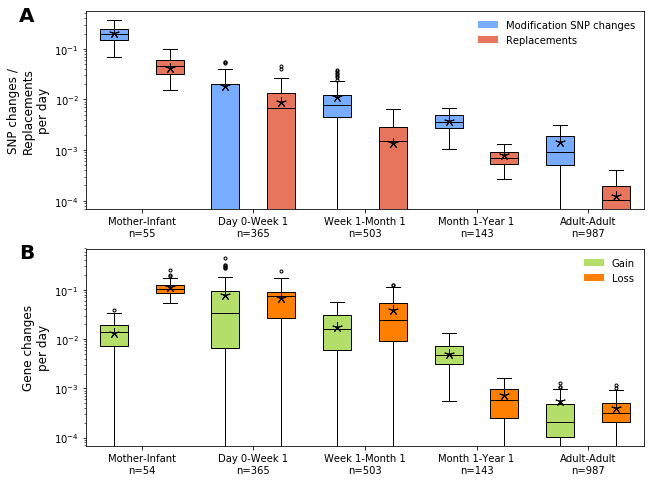

In [31]:
# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

tp_types = ['MI', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'AA']

bootstrapped_snp_change_and_replacement_rates = []
for sc_rates_cat, r_rates_cat in zip(snp_change_rates, replacement_rates):
    bootstrapped_snp_change_and_replacement_rates.append(sc_rates_cat)
    bootstrapped_snp_change_and_replacement_rates.append(r_rates_cat)

snp_change_and_replacement_annotations = []
for sc_annotation, r_annotation in zip(snp_change_rate_annotations, replacement_rate_annotations):
    snp_change_and_replacement_annotations.append(sc_annotation)
    snp_change_and_replacement_annotations.append(r_annotation)

boxplots_0 = ax[0].boxplot(bootstrapped_snp_change_and_replacement_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_snp_change_and_replacement_rates), step=2):
    boxplots_0['boxes'][i].set_facecolor('#77acff') # SNP change
    boxplots_0['boxes'][i+1].set_facecolor('#e7755b') # Replacement

ax[0].plot(np.arange(1, 1+len(snp_change_and_replacement_annotations)), snp_change_and_replacement_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[0].set_xticks(np.arange(2*len(snp_change_rate_tp_type_labels), step=2) + 1.5)
ax[0].set_xticklabels(snp_change_rate_tp_type_labels)
ax[0].set_ylabel("SNP changes /\nReplacements\nper day", fontsize=12)
ax[0].set_yscale('log')
ax[0].text(-0.12, 0.95, 'A', size=20, transform=ax[0].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#77acff', label='Modification SNP changes'), Patch(facecolor='#e7755b', label='Replacements')]

ax[0].legend(handles=legend_elements, loc='upper right', frameon=False)

bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

boxplots_1 = ax[1].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_1['boxes'][i].set_facecolor('#b3de69') # gain
    boxplots_1['boxes'][i+1].set_facecolor('#ff7f00') # loss

ax[1].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[1].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[1].set_xticklabels(gain_tp_type_labels)
ax[1].set_ylabel("Gene changes\nper day", fontsize=12)
ax[1].set_yscale('log')
ax[1].text(-0.12, 0.95, 'B', size=20, transform=ax[1].transAxes, weight='bold')

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[1].legend(handles=legend_elements, loc='upper right', frameon=False)

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

fig.savefig('%s/figure_3_v2.png' % plot_dir, bbox_inches='tight', dpi=600)

In [57]:
custom_cohort_tests

{'Mother-Infant(all)': <function __main__.<lambda>(s1, s2, sp)>,
 'Mother-Infant': <function __main__.<lambda>(s1, s2, sp)>,
 'Infant-Infant': <function __main__.<lambda>(s1, s2, sp)>,
 'Day 0-Week 1': <function __main__.<lambda>(s1, s2, sp)>,
 'Week 1-Month 1': <function __main__.<lambda>(s1, s2, sp)>,
 'Month 1-Year 1': <function __main__.<lambda>(s1, s2, sp)>,
 'Adult-Adult': <function __main__.<lambda>(s1, s2, sp)>,
 'II-1mon': <function __main__.<lambda>(s1, s2, sp)>,
 'II-3mon': <function __main__.<lambda>(s1, s2, sp)>,
 'II-1yr': <function __main__.<lambda>(s1, s2, sp)>,
 '6mon duration infant': <function __main__.<lambda>(s1, s2, sp)>,
 '6mon duration adult': <function __main__.<lambda>(s1, s2, sp)>,
 '4-8mon duration infant': <function __main__.<lambda>(s1, s2, sp)>,
 '4-8mon duration adult': <function __main__.<lambda>(s1, s2, sp)>}

In [137]:
# Plot SNP change distribution with all infant-infant QP pairs combined
'''
def custom_cohort_of_sample_pair(custom_cohort_tests, sample_i, sample_j):
    for cohort in custom_cohort_tests:
        if custom_cohort_tests[cohort](sample_i, sample_j):
            return cohort

custom_cohort_tests = {}
# custom_cohort_tests['MI'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in infant_samples)
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['II-1mon'] = lambda sample_i, sample_j: ((sample_i in infant_samples and sample_j in infant_samples) and (sample_pair_to_days(sample_i, sample_j) <= 32))
custom_cohort_tests['II-1yr'] = lambda sample_i, sample_j: ((sample_i in infant_samples and sample_j in infant_samples) and (sample_pair_to_days(sample_i, sample_j) > 90))
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)
'''
pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

time_length_dist = []

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species)
        if 'II-1yr' in custom_cohorts:
            time_length_dist.append(sample_pair_to_days(sample_i, sample_j))
        for custom_cohort in custom_cohorts:
            pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
        
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        if sample_i in hmp_samples and sample_j in hmp_samples:
            pooled_between_snp_change_distribution['AA'].append(num_snp_changes_between)
        else:
            pooled_between_snp_change_distribution['MI'].append(num_snp_changes_between)

In [138]:
pooled_snp_change_distribution.keys()

dict_keys(['Infant-Infant', 'Week 1-Month 1', 'II-1mon', 'II-3mon', 'Day 0-Week 1', 'Adult-Adult', '6mon duration adult', '4-8mon duration adult', 'II-1yr', '4-8mon duration infant', 'Month 1-Year 1', 'Mother-Infant(all)', 'Mother-Infant', '6mon duration infant'])

In [49]:
# Old and scrapped custom cohort code
'''
custom_cohort_tests = {}
custom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)
custom_cohort_tests['MI-other'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples))
custom_cohort_tests['II'] = lambda sample_i, sample_j: (sample_i in infant_samples and sample_j in infant_samples)
custom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)
custom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)
'''

"\ncustom_cohort_tests = {}\ncustom_cohort_tests['MI'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples) and mi_sample_day_dict[sample_i] >= 0 and mi_sample_day_dict[sample_j] <= 7)\ncustom_cohort_tests['MI-other'] = lambda sample_i, sample_j: ((sample_i in mother_samples and sample_j in infant_samples))\ncustom_cohort_tests['II'] = lambda sample_i, sample_j: (sample_i in infant_samples and sample_j in infant_samples)\ncustom_cohort_tests['MM'] = lambda sample_i, sample_j: (sample_i in mother_samples and sample_j in mother_samples)\ncustom_cohort_tests['AA'] = lambda sample_i, sample_j: (sample_i in hmp_samples and sample_j in hmp_samples)\n"

In [139]:
# Get statistics for paper

pooled_snp_change_distribution = defaultdict(list)
pooled_between_snp_change_distribution = defaultdict(list)

time_length_dist = []

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        val = snp_changes[species][(sample_i, sample_j)]
        num_snp_changes = val if (type(val) == type(1)) else len(val)
        num_snp_changes_between = between_snp_change_counts[species][(sample_i, sample_j)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species)
        '''
        if custom_cohort == None:
            print(sample_order_map[sample_i])
            print(sample_order_map[sample_j])
        '''
        time_length_dist.append(sample_pair_to_days(sample_i, sample_j))
        
        for custom_cohort in custom_cohorts:
            pooled_snp_change_distribution[custom_cohort].append(num_snp_changes)
            pooled_between_snp_change_distribution[custom_cohort].append(num_snp_changes_between)

'''
Most QP sample pairs experience zero SNV changes over timescales of less than a week, 
but a small percentage undergo a small number of SNV changes (< 20). 
An even smaller percentage of hosts harbor ~104 SNV differences, 
which is on the same order of magnitude of the number of SNV differences between unrelated hosts
'''

print("\nWITHIN\n")
for tp_type in pooled_snp_change_distribution:
    print(tp_type)
    num_total = len(pooled_snp_change_distribution[tp_type])
    num_zero = sum(np.array(pooled_snp_change_distribution[tp_type]) == 0)
    num_small = sum(np.array(pooled_snp_change_distribution[tp_type]) < 20)
    num_mod = num_small - num_zero
    num_large = sum(np.array(pooled_snp_change_distribution[tp_type]) > 500)
    print("%i out of %i (%.03f) QP pairs have 0 SNP diffs" % (num_zero, num_total, float(num_zero)/num_total))
    print("%i out of %i (%.03f) QP pairs have less than 20 SNP diffs" % (num_small, num_total, float(num_small)/num_total))
    print("%i out of %i (%.03f) QP pairs have 1-20 SNP diffs" % (num_mod, num_total, float(num_mod)/num_total))
    print("%i out of %i (%.03f) QP pairs have greater than 500 SNP diffs" % (num_large, num_total, float(num_large)/num_total))
    print('')

print("\nBETWEEN\n")
for tp_type in pooled_between_snp_change_distribution:
    print(tp_type)
    num_total = len(pooled_between_snp_change_distribution[tp_type])
    num_zero = sum(np.array(pooled_between_snp_change_distribution[tp_type]) == 0)
    num_small = sum(np.array(pooled_between_snp_change_distribution[tp_type]) < 20)
    num_mod = num_small - num_zero
    num_large = sum(np.array(pooled_between_snp_change_distribution[tp_type]) > 500)
    print("%i out of %i (%.03f) QP pairs have 0 SNP diffs" % (num_zero, num_total, float(num_zero)/num_total))
    print("%i out of %i (%.03f) QP pairs have less than 20 SNP diffs" % (num_small, num_total, float(num_small)/num_total))
    print("%i out of %i (%.03f) QP pairs have 1-20 SNP diffs" % (num_mod, num_total, float(num_mod)/num_total))
    print("%i out of %i (%.03f) QP pairs have greater than 500 SNP diffs" % (num_large, num_total, float(num_large)/num_total))
    print('')


WITHIN

Infant-Infant
1224 out of 1534 (0.798) QP pairs have 0 SNP diffs
1378 out of 1534 (0.898) QP pairs have less than 20 SNP diffs
154 out of 1534 (0.100) QP pairs have 1-20 SNP diffs
143 out of 1534 (0.093) QP pairs have greater than 500 SNP diffs

Week 1-Month 1
474 out of 514 (0.922) QP pairs have 0 SNP diffs
503 out of 514 (0.979) QP pairs have less than 20 SNP diffs
29 out of 514 (0.056) QP pairs have 1-20 SNP diffs
9 out of 514 (0.018) QP pairs have greater than 500 SNP diffs

II-1mon
994 out of 1078 (0.922) QP pairs have 0 SNP diffs
1041 out of 1078 (0.966) QP pairs have less than 20 SNP diffs
47 out of 1078 (0.044) QP pairs have 1-20 SNP diffs
33 out of 1078 (0.031) QP pairs have greater than 500 SNP diffs

II-3mon
1018 out of 1105 (0.921) QP pairs have 0 SNP diffs
1068 out of 1105 (0.967) QP pairs have less than 20 SNP diffs
50 out of 1105 (0.045) QP pairs have 1-20 SNP diffs
33 out of 1105 (0.030) QP pairs have greater than 500 SNP diffs

Day 0-Week 1
359 out of 376 (0.9

In [35]:
# Understand durations and initial timepoints of II-1mon and II-1yr categories

custom_cohort_durations = defaultdict(list)
custom_cohort_day1s = defaultdict(list)

for species in snp_changes:
    for sample_i, sample_j in snp_changes[species]:
        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, sample_i, sample_j, species)
        days = sample_pair_to_days(sample_i, sample_j)
        day1 = mi_sample_day_dict[sample_i] if sample_i in mi_sample_day_dict else -1
        
        for custom_cohort in custom_cohorts:
            custom_cohort_durations[custom_cohort].append(days)
            custom_cohort_day1s[custom_cohort].append(day1)

II-1mon category
Day 1	Count
0	4
1	11
3	16
4	410
6	2
7	415
8	4
9	5
10	13
11	9
12	13
13	2
14	52
18	1
30	57
61	64



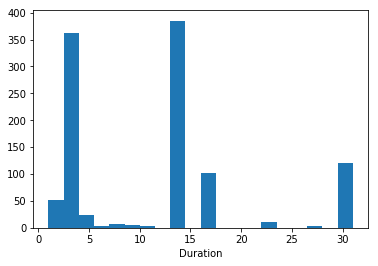

In [51]:
# Print histogram for list of integers
def print_histogram(vals):
    for val in sorted(list(set(vals))):
        print("%i\t%i" % (val, vals.count(val)))
    print('')

print("=============================================")
print("II-1mon category")
print("=============================================")
print("Day 1\tCount")
print_histogram(custom_cohort_day1s['II-1mon'])

plt.hist(custom_cohort_durations['II-1mon'], bins=20)
plt.xlabel("Duration")
plt.show()

II-3mon category
Day 1	Count
0	4
1	11
3	16
4	410
6	2
7	415
8	4
9	5
10	13
11	9
12	13
13	2
14	65
18	1
30	71
61	64



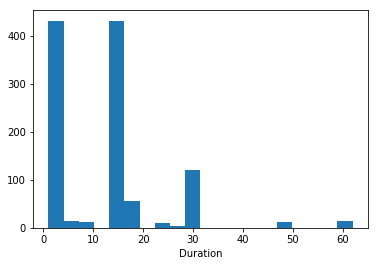

In [54]:
print("=============================================")
print("II-3mon category")
print("=============================================")
print("Day 1\tCount")
print_histogram(custom_cohort_day1s['II-3mon'])

plt.hist(custom_cohort_durations['II-3mon'], bins=20)
plt.xlabel("Duration")
plt.show()

II-1yr category
Day 1	Count
0	1
1	1
3	117
4	12
7	93
21	92
30	10
122	103



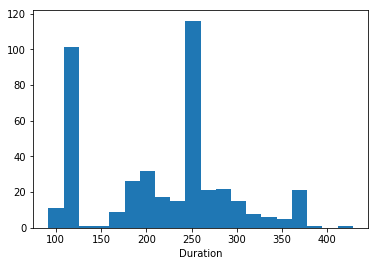

In [53]:
print("=============================================")
print("II-1yr category")
print("=============================================")

print("Day 1\tCount")
print_histogram(custom_cohort_day1s['II-1yr'])

plt.hist(custom_cohort_durations['II-1yr'], bins=20)
plt.xlabel("Duration")
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


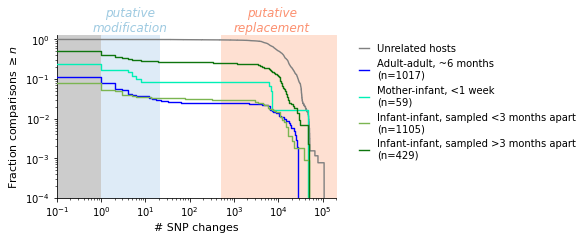

In [140]:
# Plot SNP change distribution survival curve plot

fig_snp, ax_snp = plt.subplots(figsize=(5,3))

num_colors = 8
colormap = cmx.get_cmap('viridis', num_colors)
colors = [colormap(x) for x in np.array([x for x in range(0,num_colors)])/float(num_colors)]
colors = ['gray', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

ax_snp.set_xscale('log')
ax_snp.set_yscale('log')
ax_snp.set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax_snp.set_xlabel('# SNP changes', fontsize=11)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax_snp.fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax_snp.fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax_snp.fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax_snp.text( exp((log(1e05)+log(replacement_difference_threshold))/2), ymax*1.2, 'putative\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax_snp.text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'putative\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)

# Unrelated hosts (adults OR mother/infant)
counts = []
for cat in ['Adult-Adult', 'Mother-Infant', 'II-1mon', 'II-1yr']:
    counts += pooled_between_snp_change_distribution[cat]
# counts = pooled_between_snp_change_distribution['Adult-Adult'] + pooled_between_snp_change_distribution['Mother-Infant'] + pooled_between_snp_change_distribution['Infant-Infant']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated hosts", where='pre',zorder=4)
color_i += 1

# Within-host, adult
counts = pooled_snp_change_distribution['Adult-Adult']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'Adult-adult, ~6 months' + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, mother-infant
counts = pooled_snp_change_distribution['Mother-Infant']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant, <1 week" + ('\n(n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, infant-infant
for infant_custom_cohort, infant_custom_label in zip(['II-3mon', 'II-1yr'], ['Infant-infant, sampled <3 months apart', 'Infant-infant, sampled >3 months apart']):
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ('%s\n(n=%d)' % (infant_custom_label, ns[0]))
    ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1, frameon=False)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_infant_combined_v2.pdf' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)
plt.show()

In [57]:
# Compare between with within, combined across Adult-Adult, Mother-Infant, II-1mon and II-1yr
# cats = ['Adult-Adult', 'Mother-Infant', 'II-1mon', 'II-1yr']
cats = ['Mother-Infant']
between_counts = []
within_counts = []
for cat in cats:
    between_counts += pooled_between_snp_change_distribution[cat]
    within_counts += pooled_snp_change_distribution[cat]

for counts in [between_counts, within_counts]:
    num_zero = 0
    num_mod = 0
    num_replace = 0
    for count in counts:
        if count == 0:
            num_zero += 1
        elif count <= 20:
            num_mod += 1
        elif count > 500:
            num_replace += 1

    print("Proportion no change: %.04f" % (float(num_zero)/len(counts)))
    print("Proportion <= 20: %.04f" % (float(num_mod)/len(counts)))
    print("Proportion > 500: %.04f" % (float(num_replace)/len(counts)))
    print('')

ZeroDivisionError: float division by zero

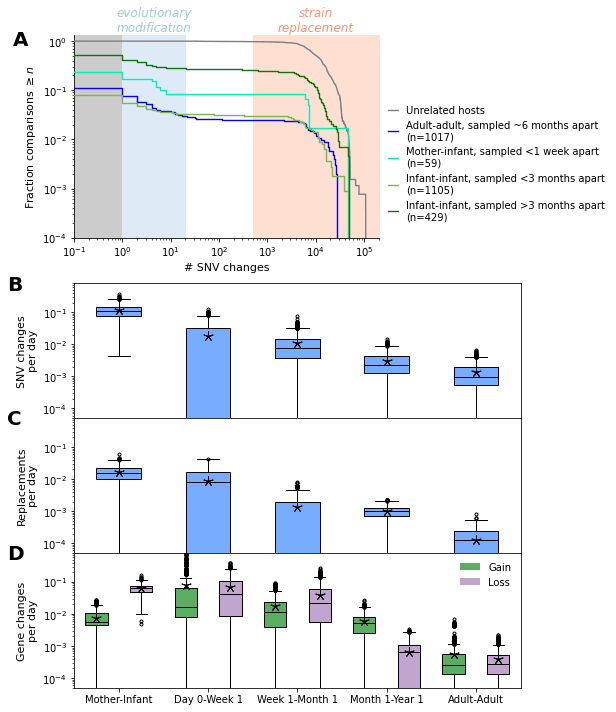

In [141]:
# THIS IS FIGURE 2
# Combined SNP change, replacement, gene gain and loss rate plot, AND SNP changes plot

# fig, ax = plt.subplots(4, 1, figsize=(8, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 6], hspace=0.15)

ax = []
# =============================================================================================
# First SNP diff survival curve plot
# =============================================================================================

ax.append(fig.add_subplot(gs[0, 0]))

num_colors = 8
colormap = cmx.get_cmap('viridis', num_colors)
colors = [colormap(x) for x in np.array([x for x in range(0,num_colors)])/float(num_colors)]
colors = ['gray', 'blue', '#00f0b6', '#7bb551', '#0e750e']

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax[0].set_xlabel('# SNV changes', fontsize=11)
ax[0].spines['top'].set_visible(False); ax[0].spines['right'].set_visible(False)
ax[0].get_xaxis().tick_bottom(); ax[0].get_yaxis().tick_left()

color_i = 0

ymin, ymax = 0.0001, 1.3; ax[0].set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05; ax[0].set_xlim([xmin, xmax])

# Now fill in the graphics
ax[0].fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax[0].fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax[0].fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax[0].text( exp((log(xmax)+log(replacement_difference_threshold))/2), ymax*1.2, 'strain\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax[0].text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'evolutionary\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)

# Unrelated hosts (adults OR mother/infant)
counts = []
for cat in ['Adult-Adult', 'Mother-Infant', 'II-3mon', 'II-1yr']:
    counts += pooled_between_snp_change_distribution[cat]
xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated hosts", where='pre',zorder=4)
color_i += 1

# Within-host, adult
counts = pooled_snp_change_distribution['Adult-Adult']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'Adult-adult, sampled ~6 months apart' + ('\n(n=%d)' % ns[0])
ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, mother-infant
counts = pooled_snp_change_distribution['Mother-Infant']
xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant, sampled <1 week apart" + ('\n(n=%d)' % ns[0])
ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Within-host, infant-infant
for infant_custom_cohort, infant_custom_label in zip(['II-3mon', 'II-1yr'], ['Infant-infant, sampled <3 months apart', 'Infant-infant, sampled >3 months apart']):
    counts = pooled_snp_change_distribution[infant_custom_cohort]
    xs, ns = calculate_unnormalized_survival_from_vector(counts)
    mlabel = ('%s\n(n=%d)' % (infant_custom_label, ns[0]))
    ax[0].step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
    color_i += 1

ax[0].legend(loc='best', bbox_to_anchor=(1.002, 0.7), fontsize=10, numpoints=1, ncol=1, handlelength=1, frameon=False)
ax[0].text(-0.2, 0.95, 'A', size=20, transform=ax[0].transAxes, weight='bold')

# =============================================================================================

ylim_lower = 5e-5

ylabel_size=11
tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1, :], hspace=0)
ax_snps = fig.add_subplot(gs1[0])
ax.append(ax_snps)
boxplots_0 = ax[1].boxplot(snp_change_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(snp_change_rates)):
    boxplots_0['boxes'][i].set_facecolor('#77acff')

ax[1].plot(np.arange(1, 1+len(snp_change_rate_annotations)), snp_change_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[1].set_xticklabels(snp_change_rate_tp_type_labels)
ax[1].get_xaxis().set_visible(False)
ax[1].set_ylabel("SNV changes\nper day", fontsize=ylabel_size)
# ax[0].set_title("SNP changes per non-replacement QP pair per day")
ax[1].set_yscale('log')
ax[1].set_ylim((ylim_lower,0.8))
ax[1].text(-0.15, 0.95, 'B', size=20, transform=ax[1].transAxes, weight='bold')

ax.append(fig.add_subplot(gs1[1]))
boxplots_1 = ax[2].boxplot(replacement_rates, patch_artist=True, zorder=-1, 
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))

for i in np.arange(len(replacement_rates)):
    boxplots_1['boxes'][i].set_facecolor('#77acff')

ax[2].plot(np.arange(1, 1+len(replacement_rate_annotations)), replacement_rate_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[2].set_xticklabels(replacement_rate_tp_type_labels)
ax[2].get_xaxis().set_visible(False)
ax[2].set_ylabel("Replacements\nper day", fontsize=ylabel_size)
# ax[1].set_title("Replacements per QP pair per day")
ax[2].set_yscale('log')
ax[2].set_ylim((ylim_lower,0.8))
ax[2].text(-0.15, 0.95, 'C', size=20, transform=ax[2].transAxes, weight='bold')
    
bootstrapped_all_gene_change_rates = []
for gain_rates, loss_rates in zip(bootstrapped_gain_rates, bootstrapped_loss_rates):
    bootstrapped_all_gene_change_rates.append(gain_rates)
    bootstrapped_all_gene_change_rates.append(loss_rates)

all_gene_change_annotations = []
for gain_annotation, loss_annotation in zip(gain_annotations, loss_annotations):
    all_gene_change_annotations.append(gain_annotation)
    all_gene_change_annotations.append(loss_annotation)

ax.append(fig.add_subplot(gs1[2]))
boxplots_2 = ax[3].boxplot(bootstrapped_all_gene_change_rates, patch_artist=True, zorder=-1,
                           medianprops=dict(color='black'), 
                           flierprops=dict(marker='.'))
for i in np.arange(len(bootstrapped_all_gene_change_rates), step=2):
    boxplots_2['boxes'][i].set_facecolor(plot_utils.col_gain) # gain
    boxplots_2['boxes'][i+1].set_facecolor(plot_utils.col_loss) # loss

ax[3].plot(np.arange(1, 1+len(all_gene_change_annotations)), all_gene_change_annotations, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[3].set_xticks(np.arange(2*len(gain_tp_type_labels), step=2) + 1.5)
ax[3].set_xticklabels(tp_types) # ax[3].set_xticklabels(gain_tp_type_labels)
ax[3].set_ylabel("Gene changes\nper day", fontsize=ylabel_size)
# ax[2].set_title("Gene changes per non-replacement QP pair per day")
ax[3].set_yscale('log')
ax[3].set_ylim((ylim_lower,0.8))
ax[3].text(-0.15, 0.95, 'D', size=20, transform=ax[3].transAxes, weight='bold')

legend_elements = [Patch(facecolor=plot_utils.col_gain, label='Gain'), Patch(facecolor=plot_utils.col_loss, label='Loss')]

ax[3].legend(handles=legend_elements, loc='upper right', frameon=False)

# plt.subplots_adjust(wspace=0, hspace=0.3)
plt.show()

fig.savefig('%s/figure_3_v7.png' % plot_dir, bbox_inches='tight', dpi=600)
fig.savefig('%s/figure_3_v7.pdf' % plot_dir, bbox_inches='tight')

In [145]:
# Linear regression
# log(SNV rates) vs. log(infant timepoint)

adult_interval_days = 183
adult_initial_days = 40*365

# Store SNP change information: including starting day

replacement_time_tups_by_tp_type = defaultdict(list)
all_time_tups_by_tp_type = defaultdict(list)

for species in snp_changes:
    for s1, s2 in snp_changes[species]:
        
        val = snp_changes[species][(s1, s2)]        
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # SPECIAL: try recoding mother-infant duration as sum
        if 'Mother-Infant' in custom_cohorts:
            day1 = mi_sample_day_dict[s1]
            day2 = mi_sample_day_dict[s2]
            days = day1 + day2
            if days == 0:
                days = 1
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        '''
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        '''
        if 'Adult-Adult' in custom_cohorts:
            day1 = adult_initial_days + ((sample_order_map[s1][1]-1)*adult_interval_days)
        else:
            day1 = mi_sample_day_dict[s1]
        
        if isinstance(val, int): # Replacement
            for custom_cohort in custom_cohorts:
                replacement_time_tups_by_tp_type[custom_cohort].append((1, days, day1))
                all_time_tups_by_tp_type[custom_cohort].append((val, days, day1))
        else: # Not replacement (modifications/no change)
            for custom_cohort in custom_cohorts:
                count_time_tups_by_tp_type[custom_cohort].append((len(val), days, day1))
                all_time_tups_by_tp_type[custom_cohort].append((len(val), days, day1))

# Store gene change information: include starting day

gain_tups_by_tp_type = defaultdict(list)
loss_tups_by_tp_type = defaultdict(list)

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # SPECIAL: try recoding mother-infant duration as sum
        if 'Mother-Infant' in custom_cohorts:
            day1 = mi_sample_day_dict[s1]
            day2 = mi_sample_day_dict[s2]
            days = day1 + day2
            if days == 0:
                days = 1
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        '''
        # Arbitrarily set mother 0 - infant 0 as 1 day
        if is_mother(s1) and mi_sample_day_dict[s1] == 0 and is_infant(s2) and mi_sample_day_dict[s2] == 0:
            days = 1
        '''
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            continue# num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        # Try excluding the Mother-Infant(wk1) QP pair with unsually high number of losses
        if (num_losses >= 13) and ('Mother-Infant' in custom_cohorts):
            print("Sample pair %s, %s | %s" % (s1, s2, species))
            print("Num losses: %i | Num gains: %i" % (num_losses, num_gains))
            continue
        
        if 'Adult-Adult' in custom_cohorts:
            day1 = adult_initial_days + ((sample_order_map[s1][1]-1)*adult_interval_days)
        else:
            day1 = mi_sample_day_dict[s1]
        
        for custom_cohort in custom_cohorts:
            gain_tups_by_tp_type[custom_cohort].append((num_gains, days, day1))
            loss_tups_by_tp_type[custom_cohort].append((num_losses, days, day1))

Sample pair ERR3405407, ERR3405406 | Bacteroides_vulgatus_57955
Num losses: 13 | Num gains: 0


In [146]:
tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

gain_rates = []
gain_day1s = []
gain_means = []

loss_rates = []
loss_day1s = []
loss_means = []

rates = [] # Modification SNP change rate
day1s = []
means = []

gain_middle_days_lists = []
loss_middle_days_lists = []
middle_days_lists = []

for tp_type in tp_types:
    
    # SNP change rates ========================================================
    total_count = 0; total_days = 0
    middle_days = []
    
    for count, days, day1 in all_time_tups_by_tp_type[tp_type]:
        if count <= 20: # Restrict to modification/no change
            rate = count/float(days)

            if day1 == 0:
                day1 = 0.1 # Arbitrary number << 1 for visualization purposes
            if count == 0:
                rate = 0 # Arbitrary number << 0.002 for visualization purposes

            rates.append(rate)
            day1s.append(day1)

            total_count += count
            total_days += days
            middle_days.append((day1) + (days/2.0))
    
    middle_days_lists.append(middle_days)
    means.append(total_count/float(total_days))
    # ==========================================================================
    
    # Gene gain rates ==========================================================
    total_count = 0; total_days = 0
    middle_days = []
    
    for count, days, day1 in gain_tups_by_tp_type[tp_type]:
        # Already excludes replacements
        rate = count/float(days)
        
        if day1 == 0:
            day1 = 0.1 # Arbitrary number << 1 for visualization purposes
        
        gain_rates.append(rate)
        gain_day1s.append(day1)
        
        total_count += count
        total_days += days
        middle_days.append((day1) + (days/2.0))
    
    gain_middle_days_lists.append(middle_days)
    gain_means.append(total_count/float(total_days))
    # ==========================================================================
    
    # Gene loss rates ==========================================================
    total_count = 0; total_days = 0
    middle_days = []
    
    for count, days, day1 in loss_tups_by_tp_type[tp_type]:
        # Already excludes replacements
        rate = count/float(days)
        
        if day1 == 0:
            day1 = 0.1 # Arbitrary number << 1 for visualization purposes
        
        loss_rates.append(rate)
        loss_day1s.append(day1)
        
        total_count += count
        total_days += days
        middle_days.append((day1) + (days/2.0))
    
    loss_middle_days_lists.append(middle_days)
    loss_means.append(total_count/float(total_days))
    # ==========================================================================

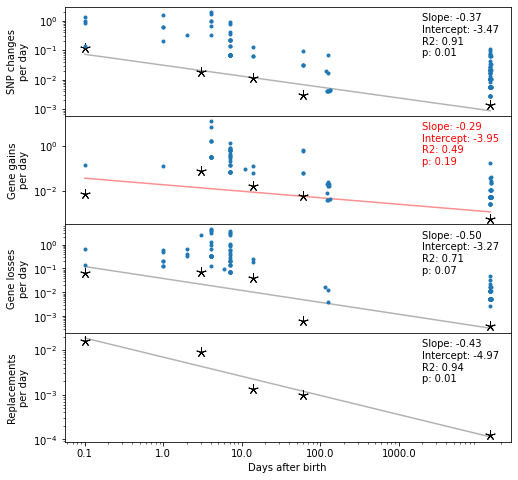

In [147]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True) # , sharey=True)

xs = np.array([0.1, 3, 14, 60, 14600])
ax[0].plot([0.1, 3, 14, 60, 14600], means, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[0].plot(day1s, rates, '.')

m, b = np.polyfit(np.log(xs), np.log(means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(means))
ax[0].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[0].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylabel("SNP changes\nper day")

# ================================================================================

ax[1].plot([0.1, 3, 14, 60, 14600], gain_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[1].plot(gain_day1s, gain_rates, '.')

m, b = np.polyfit(np.log(xs), np.log(gain_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(gain_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(gain_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color='red', alpha=0.44, zorder=-1)
ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes,
          color='red')

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_ylabel("Gene gains\nper day")

# ================================================================================

ax[2].plot([0.1, 3, 14, 60, 14600], loss_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
ax[2].plot(loss_day1s, loss_rates, '.')

m, b = np.polyfit(np.log(xs), np.log(loss_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(loss_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(loss_means))
ax[2].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[2].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[2].transAxes)

ax[2].set_yscale('log')
ax[2].set_xscale('log')

ax[2].set_ylabel("Gene losses\nper day")

# ================================================================================
replace_means = replacement_rate_annotations

ax[3].plot([0.1, 3, 14, 60, 14600], replace_means, marker=(5, 2), color='black', linestyle='None', markersize=10)

m, b = np.polyfit(np.log(xs), np.log(replace_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(replace_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(replace_means))
ax[3].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[3].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[3].transAxes)

ax[3].set_yscale('log')

ax[3].set_xlabel("Days after birth")
ax[3].set_ylabel("Replacements\nper day")

ax[3].set_xticks([1e-1, 1, 10, 100, 1000])
ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(hspace=0)
plt.show()

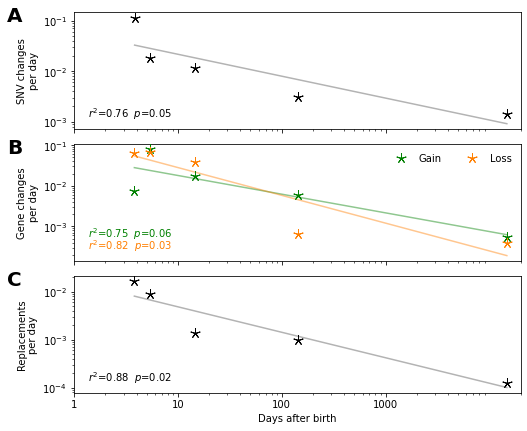

In [151]:
# Second version: put gains and losses on same subplot

gain_color = 'green'
loss_color = '#ff7f00'

fig, ax = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

xs = np.array([0.1, 3, 14, 60, 14600])
xs = [np.mean(days) for days in middle_days_lists]
ax[0].plot(xs, means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[0].scatter(xs, means, marker='D', color='black', linestyle='None', s=16)
# ax[0].scatter(day1s, rates, alpha=0.6)

m, b = np.polyfit(np.log(xs), np.log(means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(means))
ax[0].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[0].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[0].transAxes)
# ax[0].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[0].transAxes)
ax[0].text(-0.15, 0.92, 'A', size=20, transform=ax[0].transAxes, weight='bold')

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylabel("SNV changes\nper day")

# ================================================================================

xs = [np.mean(days) for days in gain_middle_days_lists]

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[1].plot(xs, gain_means, marker=(5, 2), color=gain_color, linestyle='None', markersize=10, zorder=5, label='Gain')
# gainr_all = ax[1].scatter(xs, gain_means, marker='^', color='green', linestyle='None', s=16, zorder=5, label='Gain')
# gainr_means = ax[1].scatter(gain_day1s, gain_rates, color='#b3de69', alpha=0.6, label='Gain')

m, b = np.polyfit(np.log(xs), np.log(gain_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(gain_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(gain_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color=gain_color, alpha=0.44, zorder=-2)
ax[1].text(0.03, 0.2, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes, color=gain_color)
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes, color='red')

xs = [np.mean(days) for days in loss_middle_days_lists]

ax[1].plot(xs, loss_means, marker=(5, 2), color=loss_color, linestyle='None', markersize=10, zorder=6, label='Loss')
# lossr_all = ax[1].scatter(xs, loss_means, marker='v', color='orange', linestyle='None', s=16, zorder=6, label='Loss')
# lossr_means = ax[1].scatter(loss_day1s, loss_rates, color='#ff7f00', alpha=0.6, zorder=5, label='Loss')

m, b = np.polyfit(np.log(xs), np.log(loss_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(loss_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(loss_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color=loss_color, alpha=0.44, zorder=-1)
ax[1].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes, color=loss_color)
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes)
ax[1].text(-0.15, 0.92, 'B', size=20, transform=ax[1].transAxes, weight='bold')

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].legend(frameon=False, ncol=2)
# ax[1].legend([(gainr_means, gainr_all), (lossr_means, lossr_all)], ["Gain", "Loss"], frameon=False, ncol=2)

ax[1].set_ylabel("Gene changes\nper day")

# ================================================================================
replace_means = replacement_rate_annotations

ax[2].plot(xs, replace_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[2].scatter(xs, replace_means, marker='D', color='black', linestyle='None', s=16)

m, b = np.polyfit(np.log(xs), np.log(replace_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(replace_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(replace_means))
ax[2].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[2].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[2].transAxes)
# ax[2].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[2].transAxes)
ax[2].text(-0.15, 0.92, 'C', size=20, transform=ax[2].transAxes, weight='bold')

ax[2].set_yscale('log')

ax[2].set_xlabel("Days after birth")
ax[2].set_ylabel("Replacements\nper day")

ax[2].set_xlim((1, 20000))
ax[2].set_xticks([1, 10, 100, 1000])
ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(hspace=0.13)
plt.show()
fig.savefig('%s/S7_rates_vs_median_time.pdf' % plot_dir, bbox_inches='tight')

In [ ]:
# Second version: put gains and losses on same subplot

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

xs = np.array([0.1, 5.4, 14.5, 171, 14750])

ax[0].plot(xs, means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[0].scatter(xs, means, marker='D', color='black', linestyle='None', s=16)
# ax[0].scatter(day1s, rates, alpha=0.6)

m, b = np.polyfit(np.log(xs), np.log(means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(means))
ax[0].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[0].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[0].transAxes)
# ax[0].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[0].transAxes)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylabel("SNP changes\nper day")

# ================================================================================

legend_elements = [Patch(facecolor='#b3de69', label='Gain'), Patch(facecolor='#ff7f00', label='Loss')]

ax[1].plot(xs, gain_means, marker=(5, 2), color='green', linestyle='None', markersize=10, zorder=5, label='Gain')
# gainr_all = ax[1].scatter(xs, gain_means, marker='^', color='green', linestyle='None', s=16, zorder=5, label='Gain')
# gainr_means = ax[1].scatter(gain_day1s, gain_rates, color='#b3de69', alpha=0.6, label='Gain')

m, b = np.polyfit(np.log(xs), np.log(gain_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(gain_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(gain_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color='red', alpha=0.44, zorder=-2)
ax[1].text(0.03, 0.2, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes, color='red')
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes, color='red')

ax[1].plot(xs, loss_means, marker=(5, 2), color='orange', linestyle='None', markersize=10, zorder=6, label='Loss')
# lossr_all = ax[1].scatter(xs, loss_means, marker='v', color='orange', linestyle='None', s=16, zorder=6, label='Loss')
# lossr_means = ax[1].scatter(loss_day1s, loss_rates, color='#ff7f00', alpha=0.6, zorder=5, label='Loss')

m, b = np.polyfit(np.log(xs), np.log(loss_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(loss_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(loss_means))
ax[1].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[1].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[1].transAxes)
# ax[1].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[1].transAxes)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].legend(frameon=False, ncol=2)
# ax[1].legend([(gainr_means, gainr_all), (lossr_means, lossr_all)], ["Gain", "Loss"], frameon=False, ncol=2)

ax[1].set_ylabel("Gene changes\nper day")

# ================================================================================
replace_means = replacement_rate_annotations

ax[2].plot(xs, replace_means, marker=(5, 2), color='black', linestyle='None', markersize=10)
# ax[2].scatter(xs, replace_means, marker='D', color='black', linestyle='None', s=16)

m, b = np.polyfit(np.log(xs), np.log(replace_means), deg=1)
r2 = np.corrcoef(np.log(xs), np.log(replace_means))[0, 1]**2
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(xs),np.log(replace_means))
ax[2].plot(xs, np.exp(m*np.log(xs) + b), color='0.7', zorder=-1)
ax[2].text(0.03, 0.1, r'$r^2$=%.02f  $\it{p}$=%.02f' % (r2, p_value), transform=ax[2].transAxes)
# ax[2].text(0.8, 0.55, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f\np: %.02f" % (m, b, r2, p_value), transform=ax[2].transAxes)

ax[2].set_yscale('log')

ax[2].set_xlabel("Days after birth")
ax[2].set_ylabel("Replacements\nper day")

ax[2].set_xlim((0.05, 20000))
ax[2].set_xticks([0.1, 1, 10, 100, 1000])
ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
# Linear regression

# Combined SNP change, replacement, gene gain and loss rate plot: final version??

fig, ax = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

xs = np.arange(1, 1+len(tp_types))

ax[0].plot(xs, snp_change_rate_annotations, '.b', linestyle='None', markersize=10)
ax[0].set_yscale('log')
m, b = np.polyfit(xs, np.log(snp_change_rate_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(snp_change_rate_annotations))[0, 1]**2
ax[0].plot(xs, np.exp(m*xs + b))
ax[0].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[0].transAxes)
ax[0].set_title("SNP changes per day (per non-replacement QP pair)")

ax[1].plot(xs, replacement_rate_annotations, '.b', linestyle='None', markersize=10)
ax[1].set_yscale('log')
m, b = np.polyfit(xs, np.log(replacement_rate_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(replacement_rate_annotations))[0, 1]**2
ax[1].plot(xs, np.exp(m*xs + b))
ax[1].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[1].transAxes)
ax[1].set_title("Replacements per day (per QP pair)")

ax[2].plot(xs, gain_annotations, '.b', linestyle='None', markersize=10)
ax[2].set_yscale('log')
m, b = np.polyfit(xs, np.log(gain_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(gain_annotations))[0, 1]**2
ax[2].plot(xs, np.exp(m*xs + b))
ax[2].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[2].transAxes)
ax[2].set_title("Gene gains per day (per non-replacement QP pair)")

ax[3].plot(xs, loss_annotations, '.b', linestyle='None', markersize=10)
ax[3].set_yscale('log')
m, b = np.polyfit(xs, np.log(loss_annotations), deg=1)
r2 = np.corrcoef(xs, np.log(loss_annotations))[0, 1]**2
ax[3].plot(xs, np.exp(m*xs + b))
ax[3].text(0.8, 0.6, "Slope: %.02f\nIntercept: %.02f\nR2: %.02f" % (m, b, r2), transform=ax[3].transAxes)
ax[3].set_title("Gene losses per day (per non-replacement QP pair)")
ax[3].set_xticks(xs)
ax[3].set_xticklabels(tp_types)

plt.show()

In [3]:
# Statistics for plot
for tp_type, rate in zip(tp_types, replacement_rate_annotations):
    print("Rate for %s: %.2E" % (tp_type, rate))

NameError: name 'tp_types' is not defined

In [ ]:
# Store gene change information

tp_types = ['Mother-Infant', 'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1', 'Adult-Adult']

num_gain_by_species_tp_type = {tt: defaultdict(int) for tt in tp_types}
num_loss_by_species_tp_type = {tt: defaultdict(int) for tt in tp_types}

for species in gene_changes:
    for s1, s2 in gene_changes[species]:
        
        gains, losses = gene_changes[species][(s1, s2)]
        custom_cohorts = custom_cohorts_of_sample_pair(custom_cohort_tests, s1, s2, species)
        days = sample_pair_to_days(s1, s2)
        
        # Skip negative days for now (seems to be either Yassour 3rd mom tp, Ferretti reverse IM)
        if days < 0:
            continue
        
        if isinstance(snp_changes[species][(s1, s2)], int): # Replacement (in terms of SNP changes)
            pass
            # num_gains, num_losses = gene_changes[species][(s1, s2)]
        else:
            num_gains = len(gene_changes[species][(s1, s2)][0])
            num_losses = len(gene_changes[species][(s1, s2)][1])
        
        for custom_cohort in custom_cohorts:
            num_gain_by_species_tp_type[custom_cohort][species] += num_gains
            num_loss_by_species_tp_type[custom_cohort][species] += num_losses

In [ ]:
'Day 0-Week 1', 'Week 1-Month 1', 'Month 1-Year 1'

In [ ]:
custom_cohort = 'Mother-Infant'
fig, ax = plt.subplots(figsize=(6, 12))
species_count_dict = num_gain_by_species_tp_type[custom_cohort]
species_count_tups_sorted = sorted(species_count_dict.items(), key=lambda x: x[1])
counts = [x[1] for x in species_count_tups_sorted]
species = [x[0] for x in species_count_tups_sorted]
ys = np.arange(len(species))
ax.barh(species, counts)
ax.set_title(custom_cohort + ": gene gains")
plt.show()

In [ ]:
custom_cohort = 'Mother-Infant'
fig, ax = plt.subplots(figsize=(6, 12))
species_count_dict = num_loss_by_species_tp_type[custom_cohort]
species_count_tups_sorted = sorted(species_count_dict.items(), key=lambda x: x[1])
counts = [x[1] for x in species_count_tups_sorted]
species = [x[0] for x in species_count_tups_sorted]
ys = np.arange(len(species))
ax.barh(species, counts)
ax.set_title(custom_cohort + ": gene losses")
plt.show()

In [ ]:
sample_species_qp_dict = pickle.load(open("%s/pickles/sample_species_qp_dict.pkl" % config.data_directory, 'rb'))

In [ ]:
total_infant_lowcov_samples = 0
total_infant_highcov_samples = 0
total_infant_qp_samples = 0

for sample in sample_species_qp_dict['infant']:
    
    # Skip  Olm
    if sample not in infant_samples:
        continue
    
    for species in sample_species_qp_dict['infant'][sample]:
        status = sample_species_qp_dict['infant'][sample][species]
        if status == 'low-coverage':
            total_infant_lowcov_samples += 1
        else:
            total_infant_highcov_samples += 1
        if status == 'qp':
            total_infant_qp_samples += 1

In [ ]:
print(total_infant_qp_samples)

In [ ]:
total_mother_lowcov_samples = 0
total_mother_highcov_samples = 0
total_mother_qp_samples = 0

for sample in sample_species_qp_dict['mother']:
    
    # Skip  Olm
    if sample not in mother_samples:
        continue
    
    for species in sample_species_qp_dict['mother'][sample]:
        status = sample_species_qp_dict['mother'][sample][species]
        if status == 'low-coverage':
            total_mother_lowcov_samples += 1
        else:
            total_mother_highcov_samples += 1
        if status == 'qp':
            total_mother_qp_samples += 1

In [ ]:
print(total_mother_highcov_samples)

In [ ]:
sample_species_qp_dict['hmp']